# 09. LoRA for Linear Regression and GRPO on Verifiable Sorting

This tutorial extends the previous notebooks by combining **Low-Rank Adapters (LoRA)** with a lightweight reinforcement learning pipeline on verifiable tasks. We begin with a concrete linear regression example that highlights the memory advantages of LoRA on a single layer. We then move to a reinforcement learning in verifiable domains (RLVR) setting where we adapt a Qwen 2.5 7B model with **Group Relative Policy Optimization (GRPO)** to sort lists of integers using the [PEFT](https://huggingface.co/docs/peft/index) library while explicitly modelling `<think>` reasoning tokens and structured answers.

I recommend watching [Stanford CME295 Lecture on LoRA](https://youtu.be/VlA_jt_3Qc4?t=5858).


## Roadmap

1. Refresh the intuition for LoRA and quantify how low-rank adapters reduce the memory footprint of a single linear layer.
2. Implement the adapter for a synthetic multi-target linear regression problem and compare full fine-tuning vs. LoRA.
3. Build a verifiable sorting reward, warm-start the policy with a small cold-start dataset of `<think>` exemplars, run a short supervised fine-tuning (SFT) stage, and drive a GRPO loop with PEFT to adapt Qwen 2.5 7B.


>
💡 **Dependencies**

If you are running in a clean environment you may need to install a few extra packages such as `transformers`, `datasets`, `peft`, `trl`, and `accelerate`.


In [3]:
%%capture
%pip install -q torch transformers datasets accelerate peft trl evaluate openai

## 1. Revisiting LoRA on a Single Linear Layer

LoRA decomposes the weight update of a frozen matrix $W$ into a product $BA$ where $A \in \mathbb{R}^{r \times d}$ and $B \in \mathbb{R}^{m \times r}$. Instead of storing gradients and optimizer states for the full $m \times d$ matrix, we only update the low-rank factors. The effective weight during adaptation is

$$W_{\text{eff}} = W + \frac{\alpha}{r} BA,$$

where $\alpha$ rescales the update. For wide layers (large $m$ and $d$) and small rank $r$, this reduces the number of trainable parameters and the accompanying optimizer state by orders of magnitude.


### 1.1 Synthetic regression setup

We construct a multi-target linear regression task with a 512 → 256 linear layer. The ground-truth weight matrix is the sum of a frozen base matrix and a low-rank update, mirroring the scenario where LoRA is expected to shine.


In [1]:
import math
import random
from dataclasses import dataclass
from contextlib import nullcontext
from typing import Dict, Iterable, List, Sequence, Tuple

import pandas as pd
import plotly.graph_objects as go
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(0)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
in_features = 512
out_features = 256
lora_rank = 8
num_samples = 4096
batch_size = 256
noise_std = 0.05

# Construct a frozen base weight and a low-rank update that represents the target task.
base_weight = torch.randn(out_features, in_features).to(DEVICE)
adapter_A_true = torch.randn(lora_rank, in_features).to(DEVICE)
adapter_B_true = torch.randn(out_features, lora_rank).to(DEVICE)
delta_weight = adapter_B_true @ adapter_A_true
target_weight = base_weight + delta_weight

features = torch.randn(num_samples, in_features).to(DEVICE)
targets = features @ target_weight.T + noise_std * torch.randn(num_samples, out_features).to(DEVICE)
targets = targets.to(DEVICE)

dataset = TensorDataset(features, targets)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### 1.2 Implementing a LoRA-augmented linear layer

The class below mirrors the adapter structure used in larger language models. Only the low-rank matrices `A` and `B` are trainable; the base weight stays frozen.


In [3]:
class LoRALinear(nn.Module):
    def __init__(self, base_weight: torch.Tensor, rank: int, alpha: float = 1.0, bias: bool = False):
        super().__init__()
        out_features, in_features = base_weight.shape
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha
        # Frozen base weight
        self.weight = nn.Parameter(base_weight.clone())
        self.weight.requires_grad = False
        # Trainable low-rank factors
        self.A = nn.Parameter(torch.zeros(rank, in_features))
        self.B = nn.Parameter(torch.zeros(out_features, rank))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)
        self.scaling = alpha / max(rank, 1)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

    def effective_weight(self) -> torch.Tensor:
        return self.weight + (self.B @ self.A) * self.scaling

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(x, self.effective_weight(), self.bias)

Let's see the training code now. 

In [4]:
def count_trainable_parameters(module: nn.Module) -> int:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def train_linear_module(module: nn.Module, loader: DataLoader, steps: int, lr: float) -> List[float]:
    module.to(DEVICE)
    module.train()
    optimizer = torch.optim.Adam([p for p in module.parameters() if p.requires_grad], lr=lr)
    history: List[float] = []
    iterator = iter(loader)
    for step in range(steps):
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(loader)
            batch = next(iterator)
        x, y = (tensor.to(DEVICE) for tensor in batch)
        optimizer.zero_grad()
        preds = module(x)
        loss = F.mse_loss(preds, y)
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    return history

def evaluate_mse(module: nn.Module, features: torch.Tensor, targets: torch.Tensor) -> float:
    module.eval()
    with torch.no_grad():
        preds = module(features.to(DEVICE))
        loss = F.mse_loss(preds, targets)
    return float(loss)

def relative_weight_error(module: nn.Module, target: torch.Tensor) -> float:
    if isinstance(module, LoRALinear):
        weight = module.effective_weight().detach()
    else:
        weight = module.weight.detach()
    return float(torch.norm(weight - target) / torch.norm(target))

Comparing dense linear layer with the `LoRALinear` layer written above.

In [5]:
full_linear = nn.Linear(in_features, out_features, bias=False)
full_linear.weight.data.copy_(base_weight.clone())

lora_linear = LoRALinear(base_weight=base_weight, rank=lora_rank, alpha=lora_rank)

full_history = train_linear_module(full_linear, loader, steps=2000, lr=1e-3)
lora_history = train_linear_module(lora_linear, loader, steps=2000, lr=5e-3)

full_mse = evaluate_mse(full_linear, features, targets)
lora_mse = evaluate_mse(lora_linear, features, targets)

full_error = relative_weight_error(full_linear, target_weight)
lora_error = relative_weight_error(lora_linear, target_weight)

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=full_history, name="Full fine-tuning"))
fig.add_trace(go.Scatter(y=lora_history, name="LoRA (rank=8)"))
fig.update_layout(title="Training loss comparison", xaxis_title="Step", yaxis_title="MSE loss")
fig.show()

def format_mb(params: int, dtype=torch.float32) -> float:
    bytes_per_param = torch.finfo(dtype).bits // 8
    return params * bytes_per_param / (1024 ** 2)

results_table = pd.DataFrame([
    {
        "Model": "Full fine-tuning",
        "Trainable params": count_trainable_parameters(full_linear),
        "Approx optimizer state (MB)": format_mb(count_trainable_parameters(full_linear) * 2),
        "Final MSE": full_mse,
        "Relative weight error": full_error,
    },
    {
        "Model": "LoRA (rank=8)",
        "Trainable params": count_trainable_parameters(lora_linear),
        "Approx optimizer state (MB)": format_mb(count_trainable_parameters(lora_linear) * 2),
        "Final MSE": lora_mse,
        "Relative weight error": lora_error,
    },
])
results_table

Model  Trainable params  Approx optimizer state (MB)  \
0  Full fine-tuning            131072                     1.000000   
1     LoRA (rank=8)              6144                     0.046875   

     Final MSE  Relative weight error  
0  1635.135498               0.651816  
1     0.002480               0.000063

LoRA matches the full fine-tuning loss while updating only a few thousand parameters. The optimizer state memory shrinks proportionally, which is critical when the base layer contains millions of parameters.


## 2. RLVR with GRPO on a Sorting Task

We now move from a single layer to a causal language model. The goal is to sort a list of integers — a domain where the reward can be **verified automatically**. We will:

* Load a small cold-start dataset of prompts and structured `<think>` answers.
* Run a lightweight supervised warm-start so the LoRA adapter learns to emit the reasoning and output tags.
* Apply a LoRA adapter to Qwen 2.5 7B with the [PEFT](https://huggingface.co/docs/peft/index) library.
* Implement a GRPO-style policy gradient loop that samples multiple completions per prompt and shapes the reward with verifiable checks.

Typically, RLVR is applied for a large number of math and coding like tasks where the result can be verified against a ground truth. These could include proof verifiers or code testing. We are using Qwen 2.5 because Qwen3 is already trained with `<think>` and `</think>` tokens and Qwen1 is not optimised for inference (no GQA). 

For a more in-depth discussion, please watch [Stanford CS336 - RL Lecture](https://www.youtube.com/watch?v=JdGFdViaOJk&list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_&index=17).


### 2.1 Cold-start data and prompt construction

The helper below loads a JSONL file (also easy to host on the Hugging Face Hub) and augments it with synthetic permutations so that the policy has a warm start before RL. Every prompt enforces the structure “think inside `<think>...</think>` and then the answer with a strict structured response reminder. We shall use the `Claude Sonnet 4.5` model to generate thinking tokens as it provides precise reasoning while maintaining brevity. 


In [2]:
from datasets import Dataset, load_dataset
from typing import Any, Dict, List, Optional
from rich.progress import (
    Progress,
    SpinnerColumn,
    BarColumn,
    TextColumn,
    TimeElapsedColumn,
)
import statistics
import random
import asyncio
import json
import re
import os

import nest_asyncio
nest_asyncio.apply()

STRUCTURED_INSTRUCTIONS = (
    "First think between <think> and </think> tags and then provide a response as a sorted list and nothing else. No tools."
)

def render_numbers(numbers):
    return ', '.join(str(n) for n in numbers)

def build_prompt(numbers):
    return f"Sort the numbers [{render_numbers(numbers)}]. {STRUCTURED_INSTRUCTIONS}"

async def build_response(numbers, client):
    sorted_numbers = sorted(numbers)
    response = await client.chat.completions.create(
        model="anthropic/claude-sonnet-4.5",
        messages=[
            {"role": "user", "content": f"Briefly think step by step and sort this list by hand: {numbers}."}
        ],
    )
    return f"<think>{response.choices[0].message.content}</think>[{render_numbers(sorted_numbers)}]"

async def _gen_one(i: int, seed: int, client) -> Dict[str, Any]:
    rng = random.Random(seed + i)
    length = rng.randint(10, 50)
    numbers = [rng.uniform(-20, 30) for _ in range(length)]

    prompt = build_prompt(numbers)
    response = await build_response(numbers, client)

    return {
        "prompt": prompt,
        "response": response,
        "numbers": numbers,
        "rationale": response.split("</think>")[0].replace("<think>", "").strip(),
    }

def generate_synthetic_sorting(num_examples: int = 128, client = None, seed: int = 0) -> Dataset:
    rng = random.Random(seed)
    samples = []
    for i in track(range(num_examples), description="Generating synthetic sorting examples"):
        length = rng.randint(10, 50)
        numbers = [rng.uniform(-20, 30) for _ in range(length)]
        prompt = build_prompt(numbers)
        response = build_response(numbers, client)
        samples.append(
            {
                "prompt": prompt,
                "response": response,
                "numbers": numbers,
                "rationale": response.split('</think>')[0].replace('<think>', '').strip(),
            }
        )
    return Dataset.from_list(samples)

async def generate_synthetic_sorting_async(num_examples: int = 128, client=None, seed: int = 0, concurrency: int = 50) -> Dataset:
    sem = asyncio.Semaphore(concurrency)
    results: List[Optional[Dict[str, Any]]] = [None] * num_examples

    async def guarded(i: int):
        async with sem:
            out = await _gen_one(i, seed, client)
            results[i] = out

    tasks = [asyncio.create_task(guarded(i)) for i in range(num_examples)]

    with Progress(SpinnerColumn(), TextColumn("[bold]Generating synthetic sorting examples[/]"), BarColumn(), TextColumn("{task.completed}/{task.total}"), TimeElapsedColumn()) as progress:
        task_id = progress.add_task("gen", total=num_examples)
        for fut in asyncio.as_completed(tasks):
            await fut
            progress.update(task_id, advance=1)

    return Dataset.from_list([r for r in results if r is not None])

def generate_synthetic_sorting(num_examples: int = 128, client=None, seed: int = 0, concurrency: int = 50) -> Dataset:
    return asyncio.run(generate_synthetic_sorting_async(num_examples=num_examples, client=client, seed=seed, concurrency=concurrency))

if not os.path.exists('data/sorting_synthetic_training.jsonl'):
    from openai import AsyncOpenAI
    client = AsyncOpenAI(base_url="https://openrouter.ai/api/v1", api_key="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")
    test_ds = generate_synthetic_sorting(10, client, seed=42)
    test_ds.to_json('data/sorting_synthetic_test.jsonl')
    training_ds = generate_synthetic_sorting(200, client, seed=42)
    training_ds.to_json('data/sorting_synthetic_training.jsonl')
else:
    training_ds = load_dataset('json', data_files='data/sorting_synthetic_training.jsonl', split='train')
    test_ds = load_dataset('json', data_files='data/sorting_synthetic_test.jsonl', split='train')
    
print(json.dumps(training_ds[0], indent=2))

{
  "prompt": "Sort the numbers [-14.433446591715981, 17.077524987991644, -7.7554073098261895, -13.023103573742805, -14.875241191424625, 17.03338723338379, 7.268326687417488, 9.524625622451982, -18.41086602591082, -15.315238006920378, -8.366955330463021, 10.100936452499017, 8.06225314693065, 15.800980646120173, 15.066248679511794, 0.9759910480829355, 2.460452314192679, -6.090464588466864, 23.4650160396467, 17.940368356488364, -12.017034181155495, 1.1307199076751289, -6.1064329164179085, -9.23431189462056, 18.174706450326198, -14.889486174007565, -1.003634968133131, -2.0510309757685796, -2.8022138760514466, -6.773956638899346, -17.82747785384514, 2.971243983592128, -13.758691857339532, 26.114768601407995, -16.05999009607709, -5.341085929645356, 11.431989974722168, 24.272587396840343, -1.9182486916511756, -10.385570487167005, -16.522242558812955, 13.063165928385509, 18.653417039434594, 29.261076033037888, 22.765886050757345, 23.324183337763486, -0.9936887480416914, 2.6705151184217755, 21

### 2.2 Supervised warm-start with structured reasoning tokens

Before optimising with RL we align the policy to the desired format by running a brief supervised fine-tuning pass on the combined cold-start and synthetic data. We mask the prompt tokens so that only the completion (the `<think>` rationale plus the answer) contributes to the loss, ensuring the LoRA adapter reliably emits the control tokens.

* `autotokenizer.from_pretrained`: this loads the pre-trained tokenizer specifically designed for the `qwen2.5-7b model` from the hugging face hub. it knows how to break text into tokens that the model understands.
* `tokenizer.add_special_tokens`: we're adding custom tokens like <think> and <output>. this is important because these tokens help the model learn the structured reasoning format we're aiming for in the sorting task.
* `tokenizer.pad_token` and `tokenizer.padding_side`: models often require inputs of the same length, so padding tokens (<eos>) are used to make shorter sequences match the max_length. setting padding_side='left' means padding will be added to the beginning of sequences.

In [3]:
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model

base_model_name = 'Qwen/Qwen2.5-7B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
policy_model = AutoModelForCausalLM.from_pretrained(base_model_name, trust_remote_code=True).to(DEVICE)

def test_model(model, prompt=test_ds[0]['prompt']):
    messages = [
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    outputs = model.generate(**model_inputs, max_new_tokens=8192)
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=False)[0]
    return decoded

base_response = test_model(policy_model)
print(base_response)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Sort the numbers [-14.433446591715981, 17.077524987991644, -7.7554073098261895, -13.023103573742805, -14.875241191424625, 17.03338723338379, 7.268326687417488, 9.524625622451982, -18.41086602591082, -15.315238006920378, -8.366955330463021, 10.100936452499017, 8.06225314693065, 15.800980646120173, 15.066248679511794, 0.9759910480829355, 2.460452314192679, -6.090464588466864, 23.4650160396467, 17.940368356488364, -12.017034181155495, 1.1307199076751289, -6.1064329164179085, -9.23431189462056, 18.174706450326198, -14.889486174007565, -1.003634968133131, -2.0510309757685796, -2.8022138760514466, -6.773956638899346, -17.82747785384514, 2.971243983592128, -13.758691857339532, 26.114768601407995, -16.05999009607709, -5.341085929645356, 11.431989974722168, 24.272587396840343, -1.9182486916511756, -10.385570487167005, -16.522242558812955, 13.063165928385509, 18.653417039434594, 29.

Clearly, the response is incorrect, does not use thinking tokens correctly, and does not give the response with  the required structure.

Hence, we perform some simple SFT. 
* `prepare_sft_example`: this function takes each example from our dataset (prompt and response), combines them, and tokenizes them using the tokenizer. it also creates labels for supervised training. the key part here is setting `labels[idx] = -100` for the prompt tokens, which means the model won't calculate loss on the prompt itself, only on its generated response. this is standard for causal language modeling fine-tuning.
* `training_ds.map`: this applies the prepare_sft_example function to every entry in our training_ds (which comes from the datasets library), effectively tokenizing the entire dataset.
* `datacollatorforlanguagemodeling`: this is responsible for taking a list of tokenized examples and batching them together. it handles padding them to the same length (as mlm=false means it's for causal language modeling, not masked language modeling).
* `trainingarguments`: this is where we define all the hyperparameters and configurations for our training run, like batch size, learning rate, how many steps to train for, where to save logs, and whether to use fp16 (mixed-precision training for faster training on gpus).
* `trainer`: this is the main class from transformers that orchestrates the training. you pass it the model, training arguments, our prepared dataset, and the data collator.
* `sft_trainer.train()`: this kicks off the supervised fine-tuning process, where the policy_model learns from our sft_dataset according to the sft_args.
* `policy_model.to(device)` and `policy_model.eval()`: after training, the model is moved to the appropriate device (gpu, if available) and set to evaluation mode, which turns off things like dropout for consistent predictions.

In [11]:
from transformers import DataCollatorForSeq2Seq
from os import path
import gc

SFT_MAX_LENGTH = 8192

def prepare_sft_example(example):
    prompt = example["prompt"].strip()
    response = example["response"].strip()
    text = f"{prompt}{response}"
    tokenized = tokenizer(text, truncation=True, max_length=SFT_MAX_LENGTH)
    prompt_ids = tokenizer(prompt, add_special_tokens=False, truncation=True, max_length=SFT_MAX_LENGTH)["input_ids"]
    labels = tokenized["input_ids"][:]
    labels = labels.copy()
    prompt_len = min(len(prompt_ids), len(labels))
    for idx in range(prompt_len):
        labels[idx] = -100
    tokenized["labels"] = labels
    return tokenized

sft_dataset = training_ds.map(
    prepare_sft_example,
    remove_columns=training_ds.column_names,
)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

sft_args = TrainingArguments(
    output_dir="checkpoints/qwen2_sorting_sft",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=5e-7,
    max_steps=50,
    logging_steps=10,
    save_only_model=True,
    bf16=torch.cuda.is_bf16_supported(),
    gradient_checkpointing=True,
    report_to="none",
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    padding=True,
    label_pad_token_id=-100,
    pad_to_multiple_of=8 if sft_args.fp16 else None,
)

sft_trainer = Trainer(
    model=policy_model,
    args=sft_args,
    train_dataset=sft_dataset,
    data_collator=data_collator,
)

if path.exists("checkpoints/qwen2_sorting_sft/checkpoint-50/config.json"):
    print("Loading from existing checkpoint...")
    policy_model = AutoModelForCausalLM.from_pretrained("checkpoints/qwen2_sorting_sft/checkpoint-50/").to(DEVICE)
else:
    sft_trainer.train()

policy_model.eval()

torch.cuda.empty_cache(); gc.collect()

response = test_model(policy_model)
print(response)

Loading from existing checkpoint...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Sort the numbers [-14.433446591715981, 17.077524987991644, -7.7554073098261895, -13.023103573742805, -14.875241191424625, 17.03338723338379, 7.268326687417488, 9.524625622451982, -18.41086602591082, -15.315238006920378, -8.366955330463021, 10.100936452499017, 8.06225314693065, 15.800980646120173, 15.066248679511794, 0.9759910480829355, 2.460452314192679, -6.090464588466864, 23.4650160396467, 17.940368356488364, -12.017034181155495, 1.1307199076751289, -6.1064329164179085, -9.23431189462056, 18.174706450326198, -14.889486174007565, -1.003634968133131, -2.0510309757685796, -2.8022138760514466, -6.773956638899346, -17.82747785384514, 2.971243983592128, -13.758691857339532, 26.114768601407995, -16.05999009607709, -5.341085929645356, 11.431989974722168, 24.272587396840343, -1.9182486916511756, -10.385570487167005, -16.522242558812955, 13.063165928385509, 18.653417039434594, 29.

### 2.3 Reward shaping with verifiable checks

Sorting is verifiable because we can deterministically extract integers from the prompt and the model output. The reward below blends several signals:

* **Exact match** — full credit when the completion equals the sorted list.
* **Monotonicity** — partial credit if the answer is sorted but numbers differ.
* **Prefix accuracy** — rewards early correct numbers to stabilise learning.
* **Coverage** — encourages the model to reuse the original numbers.
* **Format compliance** — bonus for emitting the `<think>` block.
* **Length penalty** — discourages hallucinating or dropping numbers.

The function also returns diagnostic components so we can reason about learning progress.


In [16]:
from collections import Counter

THINK_PATTERN = re.compile(r"<think>([\s\S]*?)</think>", re.IGNORECASE)
OUTPUT_PATTERN = re.compile(r"</think>([\s\S]*?)(?:<\|im_end\|>|$)", re.IGNORECASE)

def extract_numbers(text: str) -> List[int]:
    numbers = re.findall(r'[-+]?\d*\.\d+|\d+', text)
    numbers = [float(i) for i in numbers]
    return numbers

def sorting_reward(prompt: str, completion: str, test: bool = False) -> Tuple[float, Dict[str, float]]:
    target_numbers = extract_numbers(prompt)
    target_sorted = sorted(target_numbers)
    output_section = re.findall(OUTPUT_PATTERN, completion)[1].strip() if len(re.findall(OUTPUT_PATTERN, completion)) > 1 else ""
    if not output_section:
        return -1.0, {"exact": 0.0, "monotonic": 0.0, "prefix": 0.0, "coverage": 0.0, "format": 0.0}

    predicted_numbers = extract_numbers(output_section)
    if not predicted_numbers:
        return -1.0, {"exact": 0.0, "monotonic": 0.0, "prefix": 0.0, "coverage": 0.0, "format": 0.0}

    think_section = re.findall(THINK_PATTERN, completion)[1].strip() if len(re.findall(THINK_PATTERN, completion)) > 1 else ""
    format_score = 1.0 if think_section and '[' in output_section and ']' in output_section else 0.0

    length_penalty = -0.05 * abs(len(predicted_numbers) - len(target_sorted))

    target_counter = Counter(target_sorted)
    predicted_counter = Counter(predicted_numbers)
    coverage = sum((target_counter & predicted_counter).values()) / max(len(target_sorted), 1)

    monotonic = 1.0 if predicted_numbers == sorted(predicted_numbers) else 0.0

    prefix = 0.0
    for t, p in zip(target_sorted, predicted_numbers):
        if t == p:
            prefix += 1
        else:
            break
    prefix = prefix / max(len(target_sorted), 1)

    exact = 1.0 if predicted_numbers == target_sorted else 0.0

    reward = (
        0.55 * exact
        + 0.2 * monotonic
        + 0.1 * prefix
        + 0.1 * coverage
        + 0.05 * format_score
        + (length_penalty if not test else 0.0)
    )
    reward = float(max(-1.0, min(reward, 1.0)))
    return reward, {
        "exact": exact,
        "monotonic": monotonic,
        "prefix": prefix,
        "coverage": coverage,
        "format": format_score,
    }

example_prompt = test_ds[0]['prompt']
base_reward = sorting_reward(example_prompt, base_response, test=True)
sft_reward = sorting_reward(example_prompt, response, test=True)

print(f"Base model reward: {base_reward}")
print(f"SFT model reward: {sft_reward}")

Base model reward: (0.338, {'exact': 0.0, 'monotonic': 1.0, 'prefix': 0.0, 'coverage': 0.88, 'format': 1.0})
SFT model reward: (0.34, {'exact': 0.0, 'monotonic': 1.0, 'prefix': 0.0, 'coverage': 0.9, 'format': 1.0})


Let's see what the average reward is for the pre-SFT and post-SFT models on the test dataset.

In [17]:
from tqdm import tqdm 

def evaluate_model_on_dataset(model, dataset: Dataset) -> Dict[str, float]:
    rewards = []
    for example in tqdm(dataset, desc="Evaluating model", total=len(dataset)):
        prompt = example['prompt']
        response = test_model(model, prompt=prompt)
        reward, _ = sorting_reward(prompt, response, test=True)
        rewards.append(reward)
    avg_reward = statistics.mean(rewards)
    return avg_reward


reference_model = AutoModelForCausalLM.from_pretrained(base_model_name, trust_remote_code=True)
reference_model.to(DEVICE)
reference_model.eval()
for param in reference_model.parameters():
    param.requires_grad = False

base_eval_results = evaluate_model_on_dataset(reference_model, test_ds.select(range(10)))
print("Base model average reward:", base_eval_results)

sft_eval_results = evaluate_model_on_dataset(policy_model, test_ds.select(range(10)))
print("SFT model average reward:", sft_eval_results)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating model: 100%|██████████| 10/10 [01:47<00:00, 10.75s/it]


Base model average reward: 0.46372391921538264


Evaluating model: 100%|██████████| 10/10 [03:06<00:00, 18.65s/it]

SFT model average reward: 0.5281940379403794


### 2.4 Qwen 2.5 7B with PEFT LoRA

We attach a LoRA adapter to Qwen 2.5 7B so that only a few attention projections are updated while the base weights stay frozen. The tokenizer is augmented with `<think>` specials so the adapter can model the reasoning format, and the frozen reference model provides the KL anchor in the RL loss.

The `LoraConfig` (low-rank adaptation configuration) is used here to set up how your policymodel will be fine-tuned efficiently. lora works by injecting small, trainable matrices into the model's layers instead of fine-tuning all of the original model's parameters, which significantly reduces the number of parameters that need to be updated.

* `r=16`: this sets the rank of the update matrices. a higher r means more expressive lora layers (closer to full fine-tuning) but also more trainable parameters. 16 is a common choice, balancing performance and efficiency.
* `lora_alpha=32`: this is a scaling factor for the lora updates. it's typically set to 2 r or r itself. a larger lora_alpha gives more weight to the lora-adapted features.
* `target_modules`: this specifies which layers within the base model (Qwen 2 7B in our case) will have lora adapters applied to them. these are typically the attention mechanism's projection layers (query, key, value, output) and the feed-forward network's projections (gate, up, down).
* `lora_dropout=0.05`: this applies dropout to the lora layers during training. dropout helps prevent overfitting by randomly setting a fraction of the lora activations to zero.
* `bias='none'`: this indicates that no bias terms will be trained with lora. you can also choose to train all bias terms ('all') or only those in the lora layers ('lora_only'). 'none' is a common default.
* `task_type='CAUSAL_LM'`: this tells the peft library that you're working with a causal language model (like gpt-style models that generate text one token at a time). this helps the library apply lora correctly for this type of architecture.


In [6]:
from copy import deepcopy 
torch.cuda.empty_cache(); gc.collect()

lora_config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.05,
    bias='none',
    task_type='CAUSAL_LM',
)

get_peft_model(policy_model, lora_config).print_trainable_parameters()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


trainable params: 161,480,704 || all params: 7,777,097,216 || trainable%: 2.0764


### 2.5 GRPO Utilities

Group Relative Policy Optimization (GRPO) is a reinforcement learning technique designed to make fine-tuning large language models (LLMs) more stable and efficient—especially in scenarios where multiple responses per prompt are available. Traditional methods like PPO (Proximal Policy Optimization) optimize policies based on scalar rewards per sample. However, in LLM fine-tuning (e.g., aligning with human preference data), rewards are often relative — we know which response is better, not by how much. GRPO was first introduced in [DeepSeek-R1 Technical Report](https://arxiv.org/pdf/2501.12948), but we use the Dr. GRPO (GRPO Done Right) variance introduced by [Liu et al. (2025)](https://arxiv.org/pdf/2503.20783?).

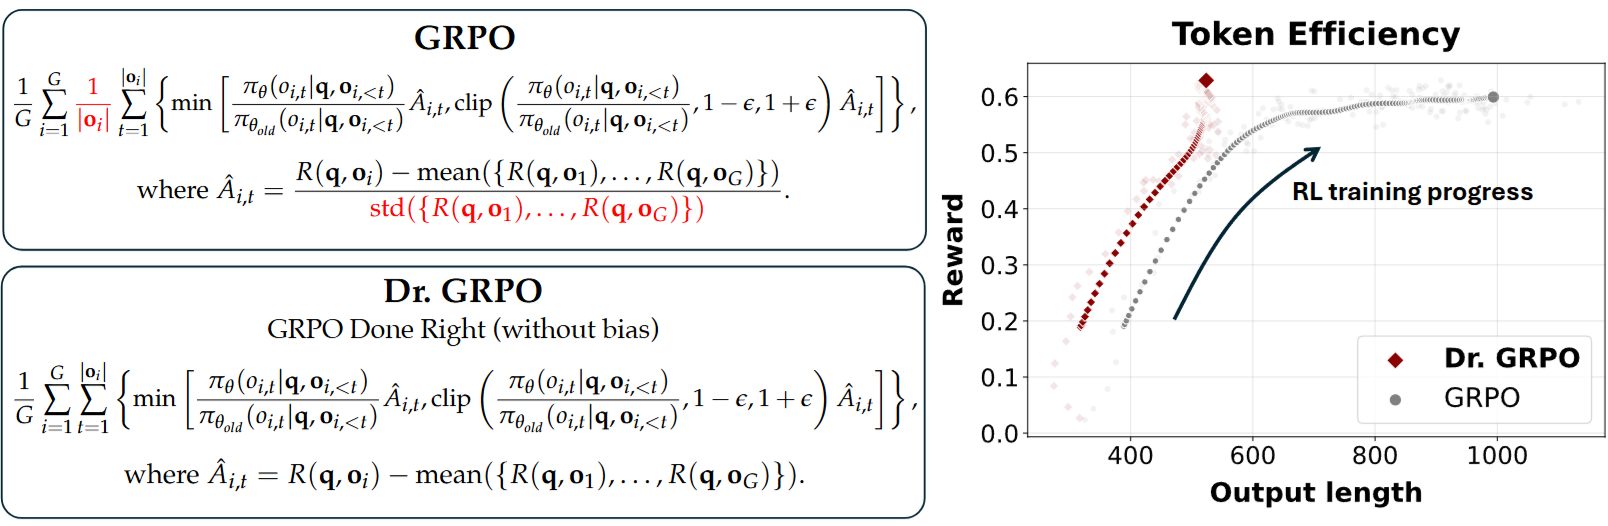

GRPO leverages this **relative preference** more effectively by comparing samples **within a group** of responses to the same prompt. Instead of updating the policy using individual sample rewards, GRPO:

1. Groups responses by the same prompt.
2. Computes **relative advantages** within each group:
   $$
   A_i = \text{reward}_i - \text{mean(rewards in group)}
   $$
3. Uses these relative advantages to update the model using a PPO-style objective:
   $$
   \mathcal{L}*{\text{GRPO}} = \mathbb{E}*i \Big[\min(r_i A_i, \text{clip}(r_i, 1 - \epsilon, 1 + \epsilon) A_i)\Big]
   $$
   where ( $r_i = \frac{\pi*\theta(a_i | s_i)}{\pi*{\text{ref}}(a_i | s_i)}$ ) is the **likelihood ratio** between the policy and reference models.

This ensures the model learns to *prefer relatively better responses* without depending on absolute reward scaling.


Key Benefits:

* **Stable training:** By normalizing rewards within groups, it mitigates outlier effects.
* **More sample-efficient:** Every group yields multiple gradient signals.
* **Alignment-friendly:** Works well with human or model preference data (as in RLHF or DPO setups).


GRPO needs log-probabilities for each sampled completion under both the policy and the frozen reference model. The helpers below combine prompts with completions, build attention masks that isolate the generated tokens, and return per-sequence log-probs.


In [10]:
from datasets import load_dataset, Dataset

# GRPOTrainer will pass lists of prompts and completions.
def grpo_reward_fn(prompts, completions, **kwargs):
    # Return only the scalar reward per (prompt, completion)
    rewards = []
    for p, c in zip(prompts, completions):
        r, _ = sorting_reward(p[0].get('content'), p[0].get('content')+'<|im_end|>'+c[0].get('content')+'<|im_end|>')  # Append end token to completion
        rewards.append(r)
    return rewards

# Keep only 'prompt', rename → 'content', and add 'role' = 'user'
train_prompts = training_ds.map(
    lambda ex: {"prompt": [{"role": "user", "content": ex["prompt"]}]},
    remove_columns=training_ds.column_names
)

test_prompts = test_ds.map(
    lambda ex: {"prompt": [{"role": "user", "content": ex["prompt"]}]},
    remove_columns=test_ds.column_names
)

print(train_prompts[0])

{'prompt': [{'content': 'Sort the numbers [-14.433446591715981, 17.077524987991644, -7.7554073098261895, -13.023103573742805, -14.875241191424625, 17.03338723338379, 7.268326687417488, 9.524625622451982, -18.41086602591082, -15.315238006920378, -8.366955330463021, 10.100936452499017, 8.06225314693065, 15.800980646120173, 15.066248679511794, 0.9759910480829355, 2.460452314192679, -6.090464588466864, 23.4650160396467, 17.940368356488364, -12.017034181155495, 1.1307199076751289, -6.1064329164179085, -9.23431189462056, 18.174706450326198, -14.889486174007565, -1.003634968133131, -2.0510309757685796, -2.8022138760514466, -6.773956638899346, -17.82747785384514, 2.971243983592128, -13.758691857339532, 26.114768601407995, -16.05999009607709, -5.341085929645356, 11.431989974722168, 24.272587396840343, -1.9182486916511756, -10.385570487167005, -16.522242558812955, 13.063165928385509, 18.653417039434594, 29.261076033037888, 22.765886050757345, 23.324183337763486, -0.9936887480416914, 2.6705151184

### 2.6 GRPO Config

Important knobs:
 - num_generations: K samples per prompt to compute group-relative baselines.
 - scale_rewards: Dr. GRPO sets this False.
 - kl_coef: mild KL to keep outputs close to reference (0 disables).
 - max_new_tokens / min_new_tokens: make sure the model can output the list.
 - stop: we stop at ']' to avoid rambling after the sorted list.

In [16]:
from trl import GRPOTrainer, GRPOConfig

training_args = GRPOConfig(
    # — standard Trainer args —
    output_dir="logs/grpo_sorting",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=5e-6,
    logging_steps=1,
    log_completions=True,
    num_completions_to_print=1,
    save_steps=200,
    num_train_epochs=2,           # or use max_steps
    seed=42,
    bf16=True,                    # if supported; otherwise set False

    # — GRPO data/generation knobs (doc names) —
    max_prompt_length=2048,
    num_generations=4,            # “G” completions per prompt
    temperature=0.7,
    max_completion_length=8192,
    repetition_penalty=1.0,       # keep default unless you need it

    # You can choose one of these: generation_batch_size OR steps_per_generation
    # generation_batch_size: if None, it’s derived from effective train batch. 
    generation_batch_size=None,

    # — GRPO objective/regularization (doc names) —
    beta=0.0,                     # KL weight; 0.0 is the doc default for GRPO. 
    num_iterations=1,             # μ in the paper (updates per generation)
    epsilon=0.2,                  # PPO clip range
    importance_sampling_level="token",

    # >>> Dr. GRPO setting <<<
    scale_rewards=False,          # disable std scaling to avoid difficulty bias. 

    # Loss variant (we use "dr_grpo", which avoids length bias)
    loss_type="dr_grpo",             # keep default unless you want classic sample-level. 

    # Training stability (recommended in docs)
    mask_truncated_completions=True,  # don’t penalize truncated samples. 

    # Optional reference-model syncing (off by default)
    sync_ref_model=False,
)

### 2.7 GRPO Training

In [ ]:
import torch
from transformers import TrainerCallback

class RewardAndSamplePrinter(TrainerCallback):
    def __init__(self, tokenizer, dataset, sample_every=10, sample_idx=0):
        self.tokenizer = tokenizer
        self.dataset = dataset
        self.sample_every = sample_every
        self.sample_idx = sample_idx  

    def on_log(self, args, state, control, logs=None, model=None, **kwargs):
        if not logs:
            return

        step = state.global_step
        reward_keys = [k for k in logs.keys() if "reward" in k.lower()]
        if reward_keys:
            reward_str = " | ".join([f"{k}: {logs[k]:.4f}" for k in reward_keys])
            print(f"[Step {step}] {reward_str}")

printer_callback = RewardAndSamplePrinter(
    tokenizer=tokenizer,
    dataset=train_prompts,    # dataset
    sample_every=10,          # print every 10 steps
    sample_idx=0,             # or random index if you prefer
)

trainer = GRPOTrainer(
    model=policy_model,
    args=training_args,
    train_dataset=train_prompts,   # dataset 
    eval_dataset=test_prompts,     # optional
    reward_funcs=grpo_reward_fn,   # our sorting reward adapter
)

trainer.add_callback(printer_callback)

trainer.train()
trainer.save_model("checkpoints/qwen2_sorting_grpo")

[Step 1] rewards/grpo_reward_fn/mean: 0.2410 | rewards/grpo_reward_fn/std: 0.0949 | reward: 0.2410 | reward_std: 0.0378 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 1 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.34 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first arrange them in ascending  │                │           │ │
│ │ user                                   │ order. I will do this step by step,   │                │           │ │
│ │ Sort the numbers [-19.60999777894772,  │ comparing each number and placing     │                │           │ │
│ │ 14.746730302158745,                    │ them in the correct position.         │                │           │ │
│ │ 26.495234482045873,                    │ </think>                              │                │           │ │
│ │ -3.772494892304877,                    │ [-19.60999777894772,                  │                │           │ │
│ │ -3.1121851466439914,                   │ -19.33250174925503,                   │                │           │ │
│ │ 26.370054000069487,                    │ -13.462073985396666,                  │                │           │ │
│ │ 22.526618369651878,                    │ -11.377610952358735,                  │                │           │ │
│ │ 16.244187361970013, 6.635781648431518, │ -9.61139364347266,                    │                │           │ │
│ │ -9.61139364347266, 2.5204771703569335, │ -8.292872880505147,                   │                │           │ │
│ │ 13.567069101275528,                    │ -5.996586704622697,                   │                │           │ │
│ │ -13.462073985396666,                   │ -3.8634629603956974,                  │                │           │ │
│ │ -5.996586704622697,                    │ -3.7990447296941454,                  │                │           │ │
│ │ -11.377610952358735,                   │ -3.772494892304877,                   │                │           │ │
│ │ -8.292872880505147,                    │ -3.1121851466439914,                  │                │           │ │
│ │ 22.485095794503067,                    │ 0.9569326023344153,                   │                │           │ │
│ │ -3.7990447296941454,                   │ 2.5204771703569335,                   │                │           │ │
│ │ 12.339559786506882, 26.21973749376923, │ 6.635781648431518, 6.955439177500747, │                │           │ │
│ │ 18.473035380692068, 6.955439177500747, │ 12.339559786506882,                   │                │           │ │
│ │ 5.018718006631545, 28.843000575540515, │ 13.567069101275528,                   │                │           │ │
│ │ -19.33250174925503,                    │ 14.746730302158745,                   │                │           │ │
│ │ -3.8634629603956974,                   │ 16.244187361970013,                   │                │           │ │
│ │ 0.9569326023344153]. First think       │ 18.473035380692068,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 22.485095794503067,                   │                │           │ │
│ │ then provide a response as a sorted    │ 22.526618369651878,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 26.21973749376923,                    │                │           │ │
│ │ assistant                              │ 26.370054000069487,                   │                │           │ │
│ │                                        │ 26.49523448

[Step 2] rewards/grpo_reward_fn/mean: 0.5129 | rewards/grpo_reward_fn/std: 0.3467 | reward: 0.5129 | reward_std: 0.3014 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 2 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.34 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will use a sorting algorithm. Given   │                │           │ │
│ │ user                                   │ the size of the list, a comparison    │                │           │ │
│ │ Sort the numbers [5.809500949425519,   │ sort would be appropriate. I will     │                │           │ │
│ │ 7.504309847258195, 19.59913089456041,  │ sort the numbers in ascending order.  │                │           │ │
│ │ -6.7028877881238, 20.185550960479965,  │ </think>                              │                │           │ │
│ │ 23.86765907429549, 18.110779899658702, │ [-18.69670061700258,                  │                │           │ │
│ │ -15.276657652007485,                   │ -17.824615291476547,                  │                │           │ │
│ │ 6.133457001856463,                     │ -16.09774478801258,                   │                │           │ │
│ │ -12.055232138063381,                   │ -15.276657652007485,                  │                │           │ │
│ │ 21.50942973641645, -16.09774478801258, │ -14.063840555461143,                  │                │           │ │
│ │ 13.396310221790749,                    │ -12.260527316096958,                  │                │           │ │
│ │ -3.078199601861673,                    │ -12.055232138063381,                  │                │           │ │
│ │ -17.824615291476547,                   │ -12.029747141175022,                  │                │           │ │
│ │ -18.69670061700258,                    │ -11.79296691384849,                   │                │           │ │
│ │ 24.280951333651345,                    │ -11.714985775574826,                  │                │           │ │
│ │ 19.993543611820392, 23.13197306592008, │ -11.023429401366297,                  │                │           │ │
│ │ -12.029747141175022, 10.7454284864552, │ -6.7028877881238, -6.353838477951472, │                │           │ │
│ │ 16.373068918121035, 4.140054264504741, │ -3.078199601861673,                   │                │           │ │
│ │ 13.75255122039173,                     │ 0.5609955024565814,                   │                │           │ │
│ │ -11.714985775574826,                   │ 1.660885349797205, 3.149672548561952, │                │           │ │
│ │ -14.063840555461143,                   │ 4.140054264504741, 5.809500949425519, │                │           │ │
│ │ 23.326454218888614,                    │ 6.133457001856463, 7.504309847258195, │                │           │ │
│ │ -12.260527316096958,                   │ 9.713210157841896, 10.7454284864552,  │                │           │ │
│ │ 3.149672548561952, 1.660885349797205,  │ 13.396310221790749,                   │                │           │ │
│ │ 0.5609955024565814,                    │ 13.75255122039173,                    │                │           │ │
│ │ -6.353838477951472,                    │ 16.373068918121035,                   │                │           │ │
│ │ -11.79296691384849,                    │ 18.110779899658702,                   │                │           │ │
│ │ -11.023429401366297,                   │ 19.59913089456041,                    │                │           │ │
│ │ 9.713210157841896,                     │ 19.99354361

[Step 3] rewards/grpo_reward_fn/mean: 0.5074 | rewards/grpo_reward_fn/std: 0.4426 | reward: 0.5074 | reward_std: 0.1999 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 3 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.37 │      0.02 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will go through them and arrange them │                │           │ │
│ │ user                                   │ from the smallest to the largest.     │                │           │ │
│ │ Sort the numbers [1.2732159619486616,  │ I'll start with the negative numbers  │                │           │ │
│ │ 19.225821845530966,                    │ and then the positive ones.           │                │           │ │
│ │ 13.009889273987866,                    │ </think>                              │                │           │ │
│ │ 2.0074853477049537,                    │ [-18.949139038424438,                 │                │           │ │
│ │ 2.9438897304001195,                    │ -18.61938172722239,                   │                │           │ │
│ │ -2.081906408066672, 9.057696960267986, │ -17.69760275351616,                   │                │           │ │
│ │ -8.904255264861753,                    │ -15.96134175971796,                   │                │           │ │
│ │ -3.017421268558266, 27.18359020681828, │ -13.325979664736646,                  │                │           │ │
│ │ 24.187461461968923,                    │ -12.690316949939277,                  │                │           │ │
│ │ 15.943909401256427, 7.917566405008131, │ -8.904255264861753,                   │                │           │ │
│ │ 27.547061239689768, 29.3408725445855,  │ -5.91612561163563, -5.13213503517083, │                │           │ │
│ │ 21.05935892425059,                     │ -3.017421268558266,                   │                │           │ │
│ │ -18.949139038424438,                   │ -2.081906408066672,                   │                │           │ │
│ │ -18.61938172722239,                    │ -1.234200678905701,                   │                │           │ │
│ │ 17.633346531915343,                    │ 0.12803595642522936,                  │                │           │ │
│ │ -12.690316949939277,                   │ 1.2104582564413349,                   │                │           │ │
│ │ 12.733426173812994, 4.965085783698797, │ 1.2732159619486616,                   │                │           │ │
│ │ 1.2104582564413349, 4.430252136929255, │ 2.0074853477049537,                   │                │           │ │
│ │ -1.234200678905701,                    │ 2.9438897304001195,                   │                │           │ │
│ │ 20.290940699537437,                    │ 4.430252136929255, 4.965085783698797, │                │           │ │
│ │ -15.96134175971796,                    │ 5.454725299357463, 6.204978502489407, │                │           │ │
│ │ -17.69760275351616,                    │ 7.917566405008131, 9.057696960267986, │                │           │ │
│ │ 19.126898925038326, 6.204978502489407, │ 11.013404523927473,                   │                │           │ │
│ │ 11.82294102173946,                     │ 11.82294102173946,                    │                │           │ │
│ │ -13.325979664736646,                   │ 12.733426173812994,                   │                │           │ │
│ │ 5.454725299357463, 15.206471804364185, │ 13.009889273987866,                   │                │           │ │
│ │ 11.013404523927473, -5.13213503517083, │ 15.20647180

[Step 4] rewards/grpo_reward_fn/mean: 0.3430 | rewards/grpo_reward_fn/std: 0.2733 | reward: 0.3430 | reward_std: 0.2317 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 4 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.55 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll first list  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ them out clearly, then sort them in   │                │           │ │
│ │ user                                   │ ascending order.                      │                │           │ │
│ │ Sort the numbers [0.3436010407276271,  │ The numbers are:                      │                │           │ │
│ │ -5.789941616393673,                    │ 0.3436010407276271,                   │                │           │ │
│ │ -10.555745953196604,                   │ -5.789941616393673,                   │                │           │ │
│ │ 7.114586349860186, 25.623302202541133, │ -10.555745953196604,                  │                │           │ │
│ │ -11.994085405995756,                   │ 7.114586349860186,                    │                │           │ │
│ │ 1.723644629571254, 25.414523861803765, │ 25.623302202541133,                   │                │           │ │
│ │ 9.852784922911685, 26.853756737272917, │ -11.994085405995756,                  │                │           │ │
│ │ 3.145643422674855, 15.908351389702972, │ 1.723644629571254,                    │                │           │ │
│ │ -9.969164577904253, 8.808586180213027, │ 25.414523861803765,                   │                │           │ │
│ │ 9.529546416958418, 19.436693227268094, │ 9.852784922911685,                    │                │           │ │
│ │ 29.99604477071523,                     │ 26.853756737272917,                   │                │           │ │
│ │ -14.604739645847513,                   │ 3.145643422674855,                    │                │           │ │
│ │ -6.638336139033761]. First think       │ 15.908351389702972,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -9.969164577904253,                   │                │           │ │
│ │ then provide a response as a sorted    │ 8.808586180213027, 9.529546416958418, │                │           │ │
│ │ list and nothing else. No tools.       │ 19.436693227268094,                   │                │           │ │
│ │ assistant                              │ 29.99604477071523,                    │                │           │ │
│ │                                        │ -14.604739645847513,                  │                │           │ │
│ │                                        │ -6.638336139033761                    │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ Now, I'll sort them:                  │                │           │ │
│ │                                        │ -14.604739645847513,                  │                │           │ │
│ │                                        │ -11.994085405995756,                  │                │           │ │
│ │                                        │ -10.555745953196604,                  │                │           │ │
│ │                                        │ -9.969164577904253,                   │                │           │ │
│ │                                        │ -6.638336139033761,                   │                │           │ │
│ │                                        │ -5.78994161

[Step 5] rewards/grpo_reward_fn/mean: -0.0290 | rewards/grpo_reward_fn/std: 0.6132 | reward: -0.0290 | reward_std: 0.4321 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 5 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>I will sort these numbers in   │           0.20 │     -0.05 │ │
│ │ You are Qwen, created by Alibaba       │ ascending order.</think>              │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ [-16.79351991447972,                  │                │           │ │
│ │ user                                   │ -14.673807287094924,                  │                │           │ │
│ │ Sort the numbers [23.010470302946317,  │ -9.759855653927257,                   │                │           │ │
│ │ 26.255848029221028,                    │ -9.724813653743357,                   │                │           │ │
│ │ -9.527980933825086,                    │ -9.527980933825086,                   │                │           │ │
│ │ 0.5790588565413977, 23.10192999696877, │ -8.619818428901153,                   │                │           │ │
│ │ -14.673807287094924,                   │ -6.620188081894501,                   │                │           │ │
│ │ 8.254300414752326,                     │ -3.6314316960768345,                  │                │           │ │
│ │ -3.6314316960768345,                   │ -2.070753416297883,                   │                │           │ │
│ │ 0.6529964031450284,                    │ -1.4206127441441723,                  │                │           │ │
│ │ 1.9354603692407153, 3.036155728371181, │ 0.30333896046570175,                  │                │           │ │
│ │ 24.209177786121487, 6.223060437140649, │ 0.5790588565413977,                   │                │           │ │
│ │ -2.070753416297883,                    │ 0.6529964031450284,                   │                │           │ │
│ │ 21.631806698178238,                    │ 1.9354603692407153,                   │                │           │ │
│ │ 27.029832079321643,                    │ 2.388805972225235, 6.223060437140649, │                │           │ │
│ │ -8.619818428901153, 22.99347074221739, │ 7.7153426588119025,                   │                │           │ │
│ │ -9.759855653927257,                    │ 8.254300414752326,                    │                │           │ │
│ │ 26.789086351001636,                    │ 10.185440940824588,                   │                │           │ │
│ │ 2.4858393435748525,                    │ 17.301500079832365,                   │                │           │ │
│ │ -9.724813653743357, 27.91276447756875, │ 18.718905651698535,                   │                │           │ │
│ │ 17.301500079832365,                    │ 20.747645769206372,                   │                │           │ │
│ │ -6.620188081894501,                    │ 21.631806698178238,                   │                │           │ │
│ │ 0.30333896046570175,                   │ 22.99347074221739,                    │                │           │ │
│ │ 20.747645769206372,                    │ 23.010470302946317,                   │                │           │ │
│ │ 10.185440940824588,                    │ 23.10192999696877,                    │                │           │ │
│ │ 18.718905651698535,                    │ 24.209177786121487,                   │                │           │ │
│ │ -13.646976885648947,                   │ 26.255848029221028,                   │                │           │ │
│ │ 7.7153426588119025, 2.388805972225235, │ 26.789086351001636,                   │                │           │ │
│ │ -1.4206127441441723,                   │ 27.02983207

[Step 6] rewards/grpo_reward_fn/mean: 0.4768 | rewards/grpo_reward_fn/std: 0.3768 | reward: 0.4768 | reward_std: 0.1384 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 6 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.37 │     -0.13 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers,    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ I'll start by comparing each number   │                │           │ │
│ │ user                                   │ to determine their relative order.    │                │           │ │
│ │ Sort the numbers [-1.3775275759889496, │ I'll go through the list and arrange  │                │           │ │
│ │ 5.3999345330845685,                    │ the numbers from the smallest to the  │                │           │ │
│ │ -0.355001879176541,                    │ largest.                              │                │           │ │
│ │ -19.151606712313946,                   │ </think>                              │                │           │ │
│ │ 18.95581137227876,                     │ [-19.151606712313946,                 │                │           │ │
│ │ -13.840620909596606,                   │ -16.70292324990966,                   │                │           │ │
│ │ 8.252332133742929, 28.270692713681775, │ -13.840620909596606,                  │                │           │ │
│ │ 15.496652562868455,                    │ -9.650596811327897,                   │                │           │ │
│ │ -8.892534859787753, 14.54213312008509, │ -8.892534859787753,                   │                │           │ │
│ │ 14.145800292633353,                    │ -6.778867082433569,                   │                │           │ │
│ │ 28.299121648723123, 28.88025018908224, │ -1.3775275759889496,                  │                │           │ │
│ │ 17.419210076512115, 27.32922882713411, │ -0.355001879176541,                   │                │           │ │
│ │ 7.205470223299066, 16.136118012598942, │ 1.6851591376753916,                   │                │           │ │
│ │ 25.12608328858935, 16.3334210931434,   │ 5.3999345330845685,                   │                │           │ │
│ │ 19.27616877019272, -9.650596811327897, │ 7.205470223299066, 8.252332133742929, │                │           │ │
│ │ 1.6851591376753916,                    │ 12.131259175989143,                   │                │           │ │
│ │ 17.055295607912434,                    │ 14.145800292633353,                   │                │           │ │
│ │ -16.70292324990966,                    │ 14.54213312008509,                    │                │           │ │
│ │ 16.576455044709014,                    │ 15.496652562868455,                   │                │           │ │
│ │ 18.449981621221873,                    │ 16.136118012598942, 16.3334210931434, │                │           │ │
│ │ -6.778867082433569,                    │ 16.576455044709014,                   │                │           │ │
│ │ 12.131259175989143,                    │ 17.055295607912434,                   │                │           │ │
│ │ 20.835721847900324]. First think       │ 17.419210076512115,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 18.449981621221873,                   │                │           │ │
│ │ then provide a response as a sorted    │ 18.95581137227876,                    │                │           │ │
│ │ list and nothing else. No tools.       │ 20.835721847900324,                   │                │           │ │
│ │ assistant                              │ 25.12608328

[Step 7] rewards/grpo_reward_fn/mean: 0.2272 | rewards/grpo_reward_fn/std: 0.0863 | reward: 0.2272 | reward_std: 0.0705 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 7 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.20 │     -0.01 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first compare each number and    │                │           │ │
│ │ user                                   │ arrange them in ascending order. I'll │                │           │ │
│ │ Sort the numbers [4.545114571154276,   │ start from the smallest to the        │                │           │ │
│ │ -11.969603293977208,                   │ largest.                              │                │           │ │
│ │ -18.515334222686903,                   │ </think>                              │                │           │ │
│ │ -2.67090051198106, -4.11769762031447,  │ [-19.08383670815834,                  │                │           │ │
│ │ -13.069044094330833,                   │ -18.656667900429902,                  │                │           │ │
│ │ -11.063731452754372,                   │ -18.515334222686903,                  │                │           │ │
│ │ 16.840298811227804,                    │ -16.703807446432585,                  │                │           │ │
│ │ -19.08383670815834,                    │ -16.07289822775912,                   │                │           │ │
│ │ 25.502870787677175,                    │ -15.402894589509957,                  │                │           │ │
│ │ 16.083021339218625,                    │ -15.330520779564585,                  │                │           │ │
│ │ 29.997040402850587,                    │ -14.37611500515874,                   │                │           │ │
│ │ 0.3176872358641738, 27.58184786772877, │ -13.651018030158383,                  │                │           │ │
│ │ 15.719379293520994,                    │ -13.069044094330833,                  │                │           │ │
│ │ 7.9979546003572395,                    │ -11.969603293977208,                  │                │           │ │
│ │ 1.5093294066995284,                    │ -11.063731452754372,                  │                │           │ │
│ │ 25.251469377143323,                    │ -6.330520779564585,                   │                │           │ │
│ │ 18.334554008127917,                    │ -5.269419894362903,                   │                │           │ │
│ │ -18.656667900429902,                   │ -3.639699541353078,                   │                │           │ │
│ │ 16.56537187384113, -14.37611500515874, │ -2.67090051198106,                    │                │           │ │
│ │ 18.951376951705193,                    │ -2.027045788590847,                   │                │           │ │
│ │ -1.3546102744950055,                   │ -1.3546102744950055,                  │                │           │ │
│ │ 22.133546461050372,                    │ 0.3176872358641738,                   │                │           │ │
│ │ -2.027045788590847,                    │ 6.664741683502424,                    │                │           │ │
│ │ 29.987708122621413,                    │ 7.9979546003572395,                   │                │           │ │
│ │ -6.330520779564585,                    │ 12.43939316813799,                    │                │           │ │
│ │ -15.402894589509957,                   │ 13.276461703128462,                   │                │           │ │
│ │ -5.269419894362903,                    │ 13.33623460

[Step 8] rewards/grpo_reward_fn/mean: 0.0917 | rewards/grpo_reward_fn/std: 0.4348 | reward: 0.0917 | reward_std: 0.3444 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 8 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.30 │      0.01 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will follow these │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ steps:                                │                │           │ │
│ │ user                                   │ 1. Identify the numbers and their     │                │           │ │
│ │ Sort the numbers [17.661584505335014,  │ order.                                │                │           │ │
│ │ -2.2949819550577004,                   │ 2. Compare each number to determine   │                │           │ │
│ │ 15.079470956215317,                    │ the smallest.                         │                │           │ │
│ │ 15.542217293526235, -8.19443971053904, │ 3. Place the smallest number in the   │                │           │ │
│ │ 12.47600602807956, 7.272519040446291,  │ first position of the sorted list.    │                │           │ │
│ │ -11.770143944997335,                   │ 4. Repeat the process for the         │                │           │ │
│ │ -7.0123480146859976,                   │ remaining numbers, excluding the      │                │           │ │
│ │ -6.629600175054321,                    │ already sorted numbers.               │                │           │ │
│ │ -2.3946979933898263,                   │ </think>                              │                │           │ │
│ │ -13.08012737293393, 23.25610660539042, │ [-19.908482551129058,                 │                │           │ │
│ │ -11.55461948437762,                    │ -19.670107102543877,                  │                │           │ │
│ │ 27.775344173862337,                    │ -17.582908314352217,                  │                │           │ │
│ │ 10.879075539891645, 5.549454185303222, │ -17.56104596580595,                   │                │           │ │
│ │ 5.0220242755619005, 8.639300624035453, │ -17.281089446678547,                  │                │           │ │
│ │ 6.79228684177739, -11.932323653528547, │ -13.08012737293393,                   │                │           │ │
│ │ -17.28108944667817,                    │ -12.45707118696892,                   │                │           │ │
│ │ 28.201184943289654,                    │ -11.932323653528547,                  │                │           │ │
│ │ 12.754008135767677, 21.47299235790701, │ -11.770143944997335,                  │                │           │ │
│ │ 17.383083303701525,                    │ -11.55461948437762,                   │                │           │ │
│ │ -12.45707118696892,                    │ -11.296317091244973,                  │                │           │ │
│ │ -11.296317091244973,                   │ -10.879075539891645,                  │                │           │ │
│ │ 14.339754900986598,                    │ -8.506946126817166,                   │                │           │ │
│ │ -2.905897782455444,                    │ -8.19443971053904,                    │                │           │ │
│ │ 10.657950428535546,                    │ -7.0123480146859976,                  │                │           │ │
│ │ -17.56104596580595,                    │ -6.629600175054321,                   │                │           │ │
│ │ -17.582908314352217,                   │ -5.109068186344029,                   │                │           │ │
│ │ -19.670107102543877,                   │ -2.90589778

[Step 9] rewards/grpo_reward_fn/mean: 0.7330 | rewards/grpo_reward_fn/std: 0.4246 | reward: 0.7330 | reward_std: 0.1423 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 9 ─────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll first list  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ them out and then sort them in        │                │           │ │
│ │ user                                   │ ascending order. The numbers are:     │                │           │ │
│ │ Sort the numbers [15.71776424556954,   │ 15.71776424556954,                    │                │           │ │
│ │ 1.0172262056452617, 18.99173560842801, │ 1.0172262056452617,                   │                │           │ │
│ │ -3.690771552662042,                    │ 18.99173560842801,                    │                │           │ │
│ │ 14.974573811097656,                    │ -3.690771552662042,                   │                │           │ │
│ │ 14.109551634591682,                    │ 14.974573811097656,                   │                │           │ │
│ │ 11.035898161564596,                    │ 14.109551634591682,                   │                │           │ │
│ │ -6.464811693496207, 4.109724486122136, │ 11.035898161564596,                   │                │           │ │
│ │ 7.9586119987150035, 3.706777818363701, │ -6.464811693496207,                   │                │           │ │
│ │ 26.18510625016672, 29.238912938825386, │ 4.109724486122136,                    │                │           │ │
│ │ -16.88659625658137]. First think       │ 7.9586119987150035,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 3.706777818363701, 26.18510625016672, │                │           │ │
│ │ then provide a response as a sorted    │ 29.238912938825386,                   │                │           │ │
│ │ list and nothing else. No tools.       │ -16.88659625658137                    │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │ Now, sorting them in ascending order: │                │           │ │
│ │                                        │ -16.88659625658137,                   │                │           │ │
│ │                                        │ -6.464811693496207,                   │                │           │ │
│ │                                        │ -3.690771552662042,                   │                │           │ │
│ │                                        │ 1.0172262056452617,                   │                │           │ │
│ │                                        │ 3.706777818363701, 4.109724486122136, │                │           │ │
│ │                                        │ 7.9586119987150035,                   │                │           │ │
│ │                                        │ 11.035898161564596,                   │                │           │ │
│ │                                        │ 14.109551634591682,                   │                │           │ │
│ │                                        │ 14.974573811097656,                   │                │           │ │
│ │                                        │ 15.71776424556954, 18.99173560842801, │                │           │ │
│ │                                        │ 26.18510625016672, 29.238912938825386 │                │           │ │
│ │                                        │ </think>   

[Step 10] rewards/grpo_reward_fn/mean: 0.5281 | rewards/grpo_reward_fn/std: 0.3830 | reward: 0.5281 | reward_std: 0.1214 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 10 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.31 │     -0.36 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will follow these │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ steps:                                │                │           │ │
│ │ user                                   │ 1. Identify the numbers in the list.  │                │           │ │
│ │ Sort the numbers [5.989379966527675,   │ 2. Compare each number with the       │                │           │ │
│ │ -11.243906112278228,                   │ others to find the smallest.          │                │           │ │
│ │ 5.529139534712801, 6.547913547634501,  │ 3. Place the smallest number at the   │                │           │ │
│ │ 21.550607735222727, 21.54481394266972, │ beginning of a new, sorted list.      │                │           │ │
│ │ 6.704915713261073, 3.5366208724511523, │ 4. Repeat the process for the         │                │           │ │
│ │ -9.550491486346395,                    │ remaining numbers until all numbers   │                │           │ │
│ │ -16.340827419383256,                   │ are sorted.                           │                │           │ │
│ │ -19.907199245591354,                   │ </think>                              │                │           │ │
│ │ 3.800968266259197, -17.73683055140589, │ [-19.907199245591354,                 │                │           │ │
│ │ 1.948197163985757, -17.6491422248704,  │ -17.73683055140589,                   │                │           │ │
│ │ 5.336691069236437, -4.337792060813083, │ -17.6491422248704,                    │                │           │ │
│ │ 8.107354807059508, 1.5517967478083428, │ -16.340827419383256,                  │                │           │ │
│ │ -11.443918431742333,                   │ -11.443918431742333,                  │                │           │ │
│ │ -10.443272373269773,                   │ -11.243906112278228,                  │                │           │ │
│ │ -17.091396354707925,                   │ -10.443272373269773,                  │                │           │ │
│ │ 23.976319404031692, 4.700026353383851, │ -9.550491486346395,                   │                │           │ │
│ │ 25.813929935950853,                    │ -6.100238777522625,                   │                │           │ │
│ │ -6.100238777522625]. First think       │ -4.337792060813083,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 1.5517967478083428,                   │                │           │ │
│ │ then provide a response as a sorted    │ 1.948197163985757,                    │                │           │ │
│ │ list and nothing else. No tools.       │ 3.5366208724511523,                   │                │           │ │
│ │ assistant                              │ 3.800968266259197, 4.700026353383851, │                │           │ │
│ │                                        │ 5.336691069236437, 5.529139534712801, │                │           │ │
│ │                                        │ 5.989379966527675, 6.547913547634501, │                │           │ │
│ │                                        │ 6.704915713261073, 8.107354807059508, │                │           │ │
│ │                                        │ 21.54481394266972,                    │                │           │ │
│ │                                        │ 21.55060773

[Step 11] rewards/grpo_reward_fn/mean: 0.3028 | rewards/grpo_reward_fn/std: 0.4280 | reward: 0.3028 | reward_std: 0.3009 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 11 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.35 │     -0.33 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will go        │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ through them and arrange them in      │                │           │ │
│ │ user                                   │ ascending order. Here are the steps I │                │           │ │
│ │ Sort the numbers [15.765281623465697,  │ will follow:                          │                │           │ │
│ │ -15.752427026465298,                   │ 1. Identify the smallest number and   │                │           │ │
│ │ 13.088894704391151,                    │ place it first.                       │                │           │ │
│ │ 16.413740097195927,                    │ 2. Find the next smallest number from │                │           │ │
│ │ -1.0932918653332884,                   │ the remaining and place it second.    │                │           │ │
│ │ 28.500860140067374,                    │ 3. Repeat this process until all      │                │           │ │
│ │ -5.027861515123998, -10.983270778503,  │ numbers are sorted.                   │                │           │ │
│ │ 15.559124817639514,                    │ </think>                              │                │           │ │
│ │ -4.112435880798293,                    │ [-15.767478299176222,                 │                │           │ │
│ │ -14.402145151010519,                   │ -15.765281623465697,                  │                │           │ │
│ │ -15.767478299176222,                   │ -15.752427026465298,                  │                │           │ │
│ │ 7.972745864521691, 1.11542079678037,   │ -10.983270778503, -9.344236393408815, │                │           │ │
│ │ 6.674661160558031, 12.940092678600045, │ -5.027861515123998,                   │                │           │ │
│ │ 22.99625657146253,                     │ -4.112435880798293,                   │                │           │ │
│ │ -9.344236393408815]. First think       │ -1.0932918653332884,                  │                │           │ │
│ │ between <think> and </think> tags and  │ 1.11542079678037, 6.674661160558031,  │                │           │ │
│ │ then provide a response as a sorted    │ 7.972745864521691,                    │                │           │ │
│ │ list and nothing else. No tools.       │ 12.940092678600045,                   │                │           │ │
│ │ assistant                              │ 13.088894704391151,                   │                │           │ │
│ │                                        │ 15.559124817639514,                   │                │           │ │
│ │                                        │ 15.765281623465697,                   │                │           │ │
│ │                                        │ 16.413740097195927,                   │                │           │ │
│ │                                        │ 22.99625657146253,                    │                │           │ │
│ │                                        │ 28.500860140067374]                   │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Step 12] rewards/grpo_reward_fn/mean: 0.3582 | rewards/grpo_reward_fn/std: 0.3978 | reward: 0.3582 | reward_std: 0.2087 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 12 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.34 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will start by  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ listing them in the order they are    │                │           │ │
│ │ user                                   │ given, then I will arrange them in    │                │           │ │
│ │ Sort the numbers [12.693094338334362,  │ ascending order. The original list    │                │           │ │
│ │ 20.594936431227623,                    │ is:                                   │                │           │ │
│ │ -6.267533146636971,                    │ 12.693094338334362,                   │                │           │ │
│ │ 3.9190133474530064,                    │ 20.594936431227623,                   │                │           │ │
│ │ -2.6074759518069683,                   │ -6.267533146636971,                   │                │           │ │
│ │ 1.8233815885187354,                    │ 3.9190133474530064,                   │                │           │ │
│ │ -18.44234926493875,                    │ -2.6074759518069683,                  │                │           │ │
│ │ -16.60284060923376,                    │ 1.8233815885187354,                   │                │           │ │
│ │ -13.687176481440314,                   │ -18.44234926493875,                   │                │           │ │
│ │ -5.098712334436499, 27.6054397528889]. │ -16.60284060923376,                   │                │           │ │
│ │ First think between <think> and        │ -13.687176481440314,                  │                │           │ │
│ │ </think> tags and then provide a       │ -5.098712334436499, 27.6054397528889  │                │           │ │
│ │ response as a sorted list and nothing  │                                       │                │           │ │
│ │ else. No tools.                        │ Now, sorting them in ascending order: │                │           │ │
│ │ assistant                              │ -18.44234926493875,                   │                │           │ │
│ │                                        │ -16.60284060923376,                   │                │           │ │
│ │                                        │ -13.687176481440314,                  │                │           │ │
│ │                                        │ -6.267533146636971,                   │                │           │ │
│ │                                        │ -5.098712334436499,                   │                │           │ │
│ │                                        │ 1.8233815885187354,                   │                │           │ │
│ │                                        │ 3.9190133474530064,                   │                │           │ │
│ │                                        │ 12.693094338334362,                   │                │           │ │
│ │                                        │ 20.594936431227623, 27.6054397528889  │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-18.44234926493875,                  │                │           │ │
│ │                                        │ -16.60284060923376,                   │                │           │ │
│ │                                        │ -13.6871764

[Step 13] rewards/grpo_reward_fn/mean: 0.3944 | rewards/grpo_reward_fn/std: 0.3379 | reward: 0.3944 | reward_std: 0.1923 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 13 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.36 │      0.03 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will first        │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ compare all the numbers, then arrange │                │           │ │
│ │ user                                   │ them in ascending order. This is a    │                │           │ │
│ │ Sort the numbers [5.134827770064227,   │ straightforward process, but it       │                │           │ │
│ │ 29.071410631249655,                    │ requires careful comparison of each   │                │           │ │
│ │ -5.7372012052605434,                   │ number to ensure the correct order.   │                │           │ │
│ │ 14.321837788531056, 27.05581345275992, │ </think>                              │                │           │ │
│ │ 6.982195502204874, 0.7471522726948194, │ [-19.761672086843255,                 │                │           │ │
│ │ 26.02510205627501, 29.13379671987365,  │ -18.364205672044, -16.93474191777009, │                │           │ │
│ │ 20.05474753385144, 12.525618734081853, │ -16.783600924999075,                  │                │           │ │
│ │ 23.486740090767825, 8.611055770354032, │ -15.968666403955645,                  │                │           │ │
│ │ 23.683184507212317,                    │ -15.508333974222747,                  │                │           │ │
│ │ -15.508333974222747,                   │ -15.118726503147904,                  │                │           │ │
│ │ -11.268101618577152,                   │ -14.99491995946807,                   │                │           │ │
│ │ 24.442129371544844,                    │ -14.37162746261107,                   │                │           │ │
│ │ -15.118726503147904,                   │ -12.525618734081853,                  │                │           │ │
│ │ -16.783600924999075, -18.364205672044, │ -11.268101618577152,                  │                │           │ │
│ │ 11.002886440741406,                    │ -11.061016864155286,                  │                │           │ │
│ │ -8.391120978097398,                    │ -9.125981510563212,                   │                │           │ │
│ │ -15.968666403955645,                   │ -8.391120978097398,                   │                │           │ │
│ │ 4.324857893694784, -16.93474191777009, │ -2.5092507227788587,                  │                │           │ │
│ │ 9.251451655181498, -9.125981510563212, │ -1.9604509109970074,                  │                │           │ │
│ │ -14.99491995946807, 20.15413628607015, │ 0.11975654429936711,                  │                │           │ │
│ │ -2.5092507227788587,                   │ 0.7471522726948194,                   │                │           │ │
│ │ -14.337163150421416,                   │ 4.036947803367305, 4.324857893694784, │                │           │ │
│ │ 6.067445906582648, 7.625376595567392,  │ 5.134827770064227,                    │                │           │ │
│ │ 4.036947803367305, 22.65603350524242,  │ 5.3356825168807305,                   │                │           │ │
│ │ -19.761672086843255,                   │ 6.067445906582648, 6.982195502204874, │                │           │ │
│ │ 26.766955587001675,                    │ 7.625376595567392, 8.611055770354032, │                │           │ │
│ │ 19.641566213834942,                    │ 9.251451655

[Step 14] rewards/grpo_reward_fn/mean: 0.5575 | rewards/grpo_reward_fn/std: 0.3552 | reward: 0.5575 | reward_std: 0.1893 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 14 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.52 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will first     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out and then sort them in   │                │           │ │
│ │ user                                   │ ascending order. I'll start by        │                │           │ │
│ │ Sort the numbers [19.353274387448415,  │ listing the numbers:                  │                │           │ │
│ │ 23.57067791194433, 5.6652718417740715, │ 19.353274387448415,                   │                │           │ │
│ │ -12.750740508502112,                   │ 23.57067791194433,                    │                │           │ │
│ │ 0.15266148920553135,                   │ 5.6652718417740715,                   │                │           │ │
│ │ 11.973640508114364, 3.962110302237612, │ -12.750740508502112,                  │                │           │ │
│ │ 10.778007996635477,                    │ 0.15266148920553135,                  │                │           │ │
│ │ 25.010908338064354,                    │ 11.973640508114364,                   │                │           │ │
│ │ 0.28623278538140795,                   │ 3.962110302237612,                    │                │           │ │
│ │ -1.7275518829345415,                   │ 10.778007996635477,                   │                │           │ │
│ │ -1.5697759188306506,                   │ 25.010908338064354,                   │                │           │ │
│ │ 16.27692799300368, 11.34066396420301,  │ 0.28623278538140795,                  │                │           │ │
│ │ 21.532891726048987,                    │ -1.7275518829345415,                  │                │           │ │
│ │ -18.80823089722569, 5.619562178303763, │ -1.5697759188306506,                  │                │           │ │
│ │ 20.11740809733918, 23.512144316984724, │ 16.27692799300368, 11.34066396420301, │                │           │ │
│ │ -5.187888416201346,                    │ 21.532891726048987,                   │                │           │ │
│ │ -1.6486973368494802,                   │ -18.80823089722569,                   │                │           │ │
│ │ 22.170521703586616,                    │ 5.619562178303763, 20.11740809733918, │                │           │ │
│ │ -18.677488282242155,                   │ 23.512144316984724,                   │                │           │ │
│ │ 18.484589305713328, 19.78246775489044, │ -5.187888416201346,                   │                │           │ │
│ │ 13.626918375399647,                    │ -1.6486973368494802,                  │                │           │ │
│ │ 24.008186691847555,                    │ 22.170521703586616,                   │                │           │ │
│ │ -8.741976334915407,                    │ -18.677488282242155,                  │                │           │ │
│ │ 11.629386361168198,                    │ 18.484589305713328,                   │                │           │ │
│ │ 29.252087743408765, 4.213105668655139, │ 19.78246775489044,                    │                │           │ │
│ │ -7.534939697997615,                    │ 13.626918375399647,                   │                │           │ │
│ │ -0.05399947586644416,                  │ 24.008186691847555,                   │                │           │ │
│ │ 0.4539926818295399,                    │ -8.74197633

[Step 15] rewards/grpo_reward_fn/mean: 0.5230 | rewards/grpo_reward_fn/std: 0.6515 | reward: 0.5230 | reward_std: 0.4700 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 15 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.71 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will compare each │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ number and arrange them in ascending  │                │           │ │
│ │ user                                   │ order. I'll start from the smallest   │                │           │ │
│ │ Sort the numbers [-11.106893596061484, │ to the largest.                       │                │           │ │
│ │ 14.580651639643293,                    │ </think>                              │                │           │ │
│ │ 10.448961146786825,                    │ [-13.257347796289563,                 │                │           │ │
│ │ -13.257347796289563,                   │ -11.106893596061484,                  │                │           │ │
│ │ -1.6404551706016441,                   │ -7.945595033411861,                   │                │           │ │
│ │ 26.43456368285095, 27.9484770977043,   │ -6.209067140328976,                   │                │           │ │
│ │ 28.78121838291282, 10.877481468634606, │ -5.810777508354752,                   │                │           │ │
│ │ 19.856768035838577, 6.913415525987077, │ -5.181465079330115,                   │                │           │ │
│ │ -6.209067140328976,                    │ -1.6404551706016441,                  │                │           │ │
│ │ -7.945595033411861,                    │ -1.466080199807827,                   │                │           │ │
│ │ 19.117704784182628, 6.013937328549325, │ -1.3236468948462132,                  │                │           │ │
│ │ -5.810777508354752,                    │ 0.7848629644979752,                   │                │           │ │
│ │ 29.014427135503382,                    │ 1.3210666350070284,                   │                │           │ │
│ │ 1.3210666350070284, 15.84914100820604, │ 6.013937328549325, 6.913415525987077, │                │           │ │
│ │ 9.559247961094897, -5.181465079330115, │ 9.559247961094897,                    │                │           │ │
│ │ 0.7848629644979752,                    │ 10.448961146786825,                   │                │           │ │
│ │ -1.466080199807827,                    │ 10.877481468634606,                   │                │           │ │
│ │ -1.3236468948462132,                   │ 14.580651639643293,                   │                │           │ │
│ │ 15.009331107805494]. First think       │ 15.009331107805494,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 15.84914100820604,                    │                │           │ │
│ │ then provide a response as a sorted    │ 19.117704784182628,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 19.856768035838577,                   │                │           │ │
│ │ assistant                              │ 26.43456368285095, 27.9484770977043,  │                │           │ │
│ │                                        │ 28.78121838291282,                    │                │           │ │
│ │                                        │ 29.014427135503382]                   │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰───────────────────────────────────────────────────────

[Step 16] rewards/grpo_reward_fn/mean: 0.3262 | rewards/grpo_reward_fn/std: 0.5773 | reward: 0.3262 | reward_std: 0.3194 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 16 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll go through  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ them and arrange them in ascending    │                │           │ │
│ │ user                                   │ order. I'll start with the smallest   │                │           │ │
│ │ Sort the numbers [11.620603652017813,  │ and work my way up to the largest.    │                │           │ │
│ │ 0.35293073505933137,                   │ </think>                              │                │           │ │
│ │ -19.39047384004177,                    │ [-19.484586902258915,                 │                │           │ │
│ │ 22.306974543278827, 4.366576501578248, │ -19.39047384004177,                   │                │           │ │
│ │ 8.394686409059055, -1.581577550659322, │ -13.796954675898103,                  │                │           │ │
│ │ 13.85946407948822,                     │ -11.45573350214679,                   │                │           │ │
│ │ -10.035170340840692,                   │ -10.551781723972951,                  │                │           │ │
│ │ -11.45573350214679,                    │ -10.035170340840692,                  │                │           │ │
│ │ -19.484586902258915,                   │ -6.714401996619388,                   │                │           │ │
│ │ 19.78047486249983,                     │ -4.049338679262075,                   │                │           │ │
│ │ -10.551781723972951,                   │ -1.581577550659322,                   │                │           │ │
│ │ 16.05750254780012,                     │ 0.35293073505933137,                  │                │           │ │
│ │ -13.796954675898103,                   │ 4.223577083047832, 4.366576501578248, │                │           │ │
│ │ 27.083325372462767,                    │ 5.5719047635236905,                   │                │           │ │
│ │ -6.714401996619388,                    │ 8.394686409059055,                    │                │           │ │
│ │ 13.101882494017055, 4.223577083047832, │ 11.620603652017813,                   │                │           │ │
│ │ 5.5719047635236905,                    │ 13.101882494017055,                   │                │           │ │
│ │ -4.049338679262075]. First think       │ 13.85946407948822, 16.05750254780012, │                │           │ │
│ │ between <think> and </think> tags and  │ 19.78047486249983,                    │                │           │ │
│ │ then provide a response as a sorted    │ 22.306974543278827,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 27.083325372462767]                   │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │                                       │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Step 17] rewards/grpo_reward_fn/mean: 0.3974 | rewards/grpo_reward_fn/std: 0.3779 | reward: 0.3974 | reward_std: 0.3174 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 17 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.26 │     -0.17 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will follow these │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ steps:                                │                │           │ │
│ │ user                                   │ 1. Identify the numbers in the list.  │                │           │ │
│ │ Sort the numbers [-12.21130966852527,  │ 2. Compare each number to determine   │                │           │ │
│ │ -16.887476035297503,                   │ their relative order.                 │                │           │ │
│ │ -11.450553425367536,                   │ 3. Arrange the numbers in ascending   │                │           │ │
│ │ -17.924941663778895,                   │ order.                                │                │           │ │
│ │ -13.874105494996718,                   │ </think>                              │                │           │ │
│ │ 18.826420515118677,                    │ [-17.9573966547016,                   │                │           │ │
│ │ 19.628896056088408, 7.321222061255813, │ -17.924941663778895,                  │                │           │ │
│ │ -7.5921480431520845,                   │ -16.887476035297503,                  │                │           │ │
│ │ 2.4906367285361846,                    │ -16.840183232667915,                  │                │           │ │
│ │ -9.858057052238177,                    │ -15.501099198221384,                  │                │           │ │
│ │ 2.6388112347176644,                    │ -13.874105494996718,                  │                │           │ │
│ │ 12.911962858123523, 28.6080659185223,  │ -12.21130966852527,                   │                │           │ │
│ │ -7.636451538759857,                    │ -9.858057052238177,                   │                │           │ │
│ │ 13.057765576498596,                    │ -7.636451538759857,                   │                │           │ │
│ │ 27.495007084487433, 4.867142301421435, │ -7.5921480431520845,                  │                │           │ │
│ │ 25.517550361784487, 24.87800919266143, │ -3.3095333740596296,                  │                │           │ │
│ │ 19.89336659453491, 23.931515061065504, │ -2.3191893572981854,                  │                │           │ │
│ │ 20.903730922091306, 7.958577795056698, │ -1.291146061531645,                   │                │           │ │
│ │ -1.291146061531645, 25.56286705886238, │ 2.4906367285361846,                   │                │           │ │
│ │ 9.469725448855105,                     │ 2.6388112347176644,                   │                │           │ │
│ │ -3.3095333740596296,                   │ 4.867142301421435, 6.538847636011624, │                │           │ │
│ │ 14.446318743756962,                    │ 7.321222061255813, 7.958577795056698, │                │           │ │
│ │ -16.840183232667915,                   │ 9.469725448855105, 9.556091186314827, │                │           │ │
│ │ -17.9573966547016, 21.303812265869198, │ 12.911962858123523,                   │                │           │ │
│ │ -2.3191893572981854,                   │ 13.057765576498596,                   │                │           │ │
│ │ 6.538847636011624,                     │ 18.826420515118677,                   │                │           │ │
│ │ -15.501099198221384,                   │ 19.62889605

[Step 18] rewards/grpo_reward_fn/mean: 0.4315 | rewards/grpo_reward_fn/std: 0.3475 | reward: 0.4315 | reward_std: 0.0582 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 18 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.36 │      0.09 │ │
│ │ You are Qwen, created by Alibaba       │ To sort these numbers, I will follow  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ these steps:                          │                │           │ │
│ │ user                                   │ 1. Identify all the numbers.          │                │           │ │
│ │ Sort the numbers [6.001024448116123,   │ 2. Compare them to determine their    │                │           │ │
│ │ 15.08071111963563,                     │ relative order.                       │                │           │ │
│ │ -14.167229467382418,                   │ 3. Arrange them from smallest to      │                │           │ │
│ │ -1.0215569193812044,                   │ largest.                              │                │           │ │
│ │ -5.52159516919507, -8.765677766259564, │ </think>                              │                │           │ │
│ │ 8.43445986837358, -14.990994722884025, │ [-17.827759134129877,                 │                │           │ │
│ │ 18.72238975529119, 14.440970789452237, │ -15.209353239357114,                  │                │           │ │
│ │ -4.850873167250212,                    │ -14.990994722884025,                  │                │           │ │
│ │ 11.700682781050567, 9.549858870002527, │ -14.167229467382418,                  │                │           │ │
│ │ 18.304795954864332,                    │ -12.04757954477898,                   │                │           │ │
│ │ 13.501690002575465,                    │ -10.470966626482769,                  │                │           │ │
│ │ -2.0857818895751876,                   │ -9.549858870002527,                   │                │           │ │
│ │ -3.0589548343707307,                   │ -8.765677766259564,                   │                │           │ │
│ │ -5.863519230030494,                    │ -6.499922737880336,                   │                │           │ │
│ │ -12.04757954477898,                    │ -5.863519230030494,                   │                │           │ │
│ │ 5.5507033579299865, 9.430938919867405, │ -5.52159516919507,                    │                │           │ │
│ │ -6.499922737880336,                    │ -5.514646010472134,                   │                │           │ │
│ │ -4.228576679633239,                    │ -4.850873167250212,                   │                │           │ │
│ │ 27.155895317091407, 21.09133927880506, │ -4.228576679633239,                   │                │           │ │
│ │ -5.514646010472134,                    │ -3.0589548343707307,                  │                │           │ │
│ │ -2.7724470250759836,                   │ -2.7724470250759836,                  │                │           │ │
│ │ -15.209353239357114,                   │ -2.0857818895751876,                  │                │           │ │
│ │ 3.8053239572381443,                    │ -1.0215569193812044,                  │                │           │ │
│ │ -10.470966626482769,                   │ 3.8053239572381443,                   │                │           │ │
│ │ -13.497869276126156,                   │ 5.5507033579299865,                   │                │           │ │
│ │ 17.355812358843025, 18.82802838429985, │ 6.001024448116123, 8.43445986837358,  │                │           │ │
│ │ -17.827759134129877,                   │ 9.430938919

[Step 19] rewards/grpo_reward_fn/mean: 0.3634 | rewards/grpo_reward_fn/std: 0.1879 | reward: 0.3634 | reward_std: 0.1450 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 19 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.33 │     -0.13 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll start by    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ listing them out and then arrange     │                │           │ │
│ │ user                                   │ them in ascending order. The process  │                │           │ │
│ │ Sort the numbers [22.299066063628445,  │ involves comparing each number to the │                │           │ │
│ │ 27.539283600469666,                    │ others and placing them in the        │                │           │ │
│ │ 11.639434294358242,                    │ correct sequence.                     │                │           │ │
│ │ -9.769487696853256,                    │ </think>                              │                │           │ │
│ │ 28.666197539209307,                    │ [-14.818960003446428,                 │                │           │ │
│ │ 25.900256696903107, 8.699544860461895, │ -13.335574435480007,                  │                │           │ │
│ │ 3.0675974821448975, 8.617945340964212, │ -11.488496390948942,                  │                │           │ │
│ │ 2.8861418020202088,                    │ -11.201029446019128,                  │                │           │ │
│ │ 20.333464891620913,                    │ -11.031162687319862,                  │                │           │ │
│ │ 16.333715650467227,                    │ -9.769487696853256,                   │                │           │ │
│ │ 13.401656964184802, 8.992978619977865, │ -9.016904257331392,                   │                │           │ │
│ │ 7.928348302956902,                     │ -5.63162133414467,                    │                │           │ │
│ │ -13.335574435480007,                   │ -4.7711515171226555,                  │                │           │ │
│ │ -4.7711515171226555,                   │ -3.0721640885228823,                  │                │           │ │
│ │ -11.201029446019128,                   │ -0.1976957122198506,                  │                │           │ │
│ │ 23.43171685017154,                     │ 2.2064122939890964,                   │                │           │ │
│ │ -11.031162687319862,                   │ 2.8861418020202088,                   │                │           │ │
│ │ 0.9390189729033125,                    │ 3.0675974821448975,                   │                │           │ │
│ │ -3.0721640885228823,                   │ 5.134703733407733, 5.731647624949311, │                │           │ │
│ │ 2.2064122939890964, -5.63162133414467, │ 7.928348302956902, 8.617945340964212, │                │           │ │
│ │ 16.902090274446458,                    │ 8.699544860461895, 8.992978619977865, │                │           │ │
│ │ -11.488496390948942,                   │ 11.639434294358242,                   │                │           │ │
│ │ 15.795568863149391,                    │ 13.401656964184802,                   │                │           │ │
│ │ 29.648258300744295,                    │ 13.427630166812214,                   │                │           │ │
│ │ 13.427630166812214,                    │ 13.510763989658457,                   │                │           │ │
│ │ -9.016904257331392,                    │ 15.795568863149391,                   │                │           │ │
│ │ -14.818960003446428,                   │ 16.33371565

[Step 20] rewards/grpo_reward_fn/mean: 0.4443 | rewards/grpo_reward_fn/std: 0.4051 | reward: 0.4443 | reward_std: 0.1440 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 20 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.57 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will start by     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ comparing each number and arranging   │                │           │ │
│ │ user                                   │ them in ascending order. This         │                │           │ │
│ │ Sort the numbers [25.49534686548641,   │ involves moving negative numbers to   │                │           │ │
│ │ 9.328834012237259, -4.270097280998302, │ the beginning of the list and         │                │           │ │
│ │ -7.888604281125499,                    │ positive numbers to the end, while    │                │           │ │
│ │ -6.728419519777294,                    │ also arranging them in order of their │                │           │ │
│ │ -13.919296853898988,                   │ magnitude.                            │                │           │ │
│ │ 19.812653060472776,                    │ </think>                              │                │           │ │
│ │ -19.247829843433582,                   │ [-19.881713177855087,                 │                │           │ │
│ │ 25.352891274778962,                    │ -19.686228788436175,                  │                │           │ │
│ │ -4.789769508765083,                    │ -19.280005794779157,                  │                │           │ │
│ │ 4.9420036077038105, 5.881613176380604, │ -19.25956005921298,                   │                │           │ │
│ │ 8.730784076060512,                     │ -19.247829843433582,                  │                │           │ │
│ │ -19.686228788436175,                   │ -18.14327722816923,                   │                │           │ │
│ │ 21.10786239531776, 2.992330534356558,  │ -16.67524668147457,                   │                │           │ │
│ │ -11.174608470674823,                   │ -13.919296853898988,                  │                │           │ │
│ │ 3.200495379195541, -11.12768595319537, │ -11.306360690773246,                  │                │           │ │
│ │ -11.306360690773246,                   │ -11.174608470674823,                  │                │           │ │
│ │ -19.881713177855087,                   │ -11.12768595319537,                   │                │           │ │
│ │ 2.1389459604893695,                    │ -7.888604281125499,                   │                │           │ │
│ │ -19.280005794779157,                   │ -6.728419519777294,                   │                │           │ │
│ │ 2.9931409469056334, 7.253375162093452, │ -4.789769508765083,                   │                │           │ │
│ │ 8.72327942756915, -2.2671087162131336, │ -4.270097280998302,                   │                │           │ │
│ │ -18.14327722816923, 6.547612158425913, │ -2.2671087162131336,                  │                │           │ │
│ │ -19.25956005921298,                    │ -0.20801679245438365,                 │                │           │ │
│ │ -0.20801679245438365,                  │ 2.1389459604893695,                   │                │           │ │
│ │ -16.67524668147457]. First think       │ 2.992330534356558,                    │                │           │ │
│ │ between <think> and </think> tags and  │ 2.9931409469056334,                   │                │           │ │
│ │ then provide a response as a sorted    │ 3.200495379

[Step 21] rewards/grpo_reward_fn/mean: 0.4004 | rewards/grpo_reward_fn/std: 0.3788 | reward: 0.4004 | reward_std: 0.0607 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 21 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll start by    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ listing them and then arranging them  │                │           │ │
│ │ user                                   │ in ascending order:                   │                │           │ │
│ │ Sort the numbers [-17.222312626452585, │                                       │                │           │ │
│ │ 27.19246857746247, 18.870330941357793, │ -17.222312626452585,                  │                │           │ │
│ │ 21.53602976170508,                     │ 27.19246857746247,                    │                │           │ │
│ │ -0.7558362796999205,                   │ 18.870330941357793,                   │                │           │ │
│ │ -4.134022285320587,                    │ 21.53602976170508,                    │                │           │ │
│ │ 12.539526213357902,                    │ -0.7558362796999205,                  │                │           │ │
│ │ 4.1691936178062114,                    │ -4.134022285320587,                   │                │           │ │
│ │ -19.66549241003345,                    │ 12.539526213357902,                   │                │           │ │
│ │ -18.49318254400813,                    │ 4.1691936178062114,                   │                │           │ │
│ │ 10.725813641956329]. First think       │ -19.66549241003345,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -18.49318254400813,                   │                │           │ │
│ │ then provide a response as a sorted    │ 10.725813641956329                    │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ Sorted in ascending order:            │                │           │ │
│ │                                        │ -19.66549241003345,                   │                │           │ │
│ │                                        │ -18.49318254400813,                   │                │           │ │
│ │                                        │ -17.222312626452585,                  │                │           │ │
│ │                                        │ -4.134022285320587,                   │                │           │ │
│ │                                        │ -0.7558362796999205,                  │                │           │ │
│ │                                        │ 4.1691936178062114,                   │                │           │ │
│ │                                        │ 10.725813641956329,                   │                │           │ │
│ │                                        │ 12.539526213357902,                   │                │           │ │
│ │                                        │ 18.870330941357793,                   │                │           │ │
│ │                                        │ 21.53602976170508, 27.19246857746247  │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-19.66549241003345,                  │                │           │ │
│ │                                        │ -18.4931825

[Step 22] rewards/grpo_reward_fn/mean: 0.4148 | rewards/grpo_reward_fn/std: 0.3022 | reward: 0.4148 | reward_std: 0.1177 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 22 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.35 │      0.02 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will compare each │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ number and arrange them in ascending  │                │           │ │
│ │ user                                   │ order. I'll start from the smallest   │                │           │ │
│ │ Sort the numbers [-10.325010860715954, │ number and move to the largest.       │                │           │ │
│ │ -5.019600820380436,                    │ </think>                              │                │           │ │
│ │ -2.3863511008439673,                   │ [-26.348301331775083,                 │                │           │ │
│ │ -17.5553192475304,                     │ -19.984005481120615,                  │                │           │ │
│ │ -0.4546652506309563,                   │ -17.5553192475304,                    │                │           │ │
│ │ 8.079667480018362, 21.231375542887037, │ -17.288760309461754,                  │                │           │ │
│ │ -9.515089775411976, 17.03861113612669, │ -10.325010860715954,                  │                │           │ │
│ │ 22.135326210220548,                    │ -9.515089775411976,                   │                │           │ │
│ │ 2.0287460424749284,                    │ -7.678369587444299,                   │                │           │ │
│ │ -5.023825028724447,                    │ -6.435349156411339,                   │                │           │ │
│ │ 23.978901987879212, 20.70990101505479, │ -5.023825028724447,                   │                │           │ │
│ │ -19.984005481120615, 6.46792871293621, │ -5.019600820380436,                   │                │           │ │
│ │ 21.756966048626488, 6.323079482615491, │ -4.997823461194793,                   │                │           │ │
│ │ -6.435349156411339,                    │ -3.040434076211433,                   │                │           │ │
│ │ -3.040434076211433,                    │ -2.3863511008439673,                  │                │           │ │
│ │ -7.678369587444299,                    │ 0.6533278175581465,                   │                │           │ │
│ │ 0.6533278175581465,                    │ 2.0287460424749284,                   │                │           │ │
│ │ -17.288760309461754,                   │ 3.9837661302829694,                   │                │           │ │
│ │ 3.9837661302829694,                    │ 6.323079482615491, 6.46792871293621,  │                │           │ │
│ │ 15.351694161366886, 8.950717095727853, │ 6.992146418450087, 8.079667480018362, │                │           │ │
│ │ 11.679657652487414, 6.992146418450087, │ 8.950717095727853,                    │                │           │ │
│ │ -4.997823461194793,                    │ 11.679657652487414,                   │                │           │ │
│ │ 23.647720811603065,                    │ 15.351694161366886,                   │                │           │ │
│ │ 26.348301331775083,                    │ 17.03861113612669, 20.70990101505479, │                │           │ │
│ │ 23.29956188750998]. First think        │ 21.231375542887037,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 21.756966048626488,                   │                │           │ │
│ │ then provide a response as a sorted    │ 22.13532621

[Step 23] rewards/grpo_reward_fn/mean: 0.6761 | rewards/grpo_reward_fn/std: 0.3847 | reward: 0.6761 | reward_std: 0.2177 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 23 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will first write  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ down the numbers and then order them  │                │           │ │
│ │ user                                   │ from smallest to largest.             │                │           │ │
│ │ Sort the numbers [22.198099266749416,  │ The numbers are:                      │                │           │ │
│ │ 3.2370190608592644, 29.58461356729873, │ 22.198099266749416,                   │                │           │ │
│ │ 28.583693887063355,                    │ 3.2370190608592644,                   │                │           │ │
│ │ -14.999399994941687,                   │ 29.58461356729873,                    │                │           │ │
│ │ 25.57402354797049, 13.197547319653665, │ 28.583693887063355,                   │                │           │ │
│ │ -13.415652578740833,                   │ -14.999399994941687,                  │                │           │ │
│ │ 29.38643847705248,                     │ 25.57402354797049,                    │                │           │ │
│ │ -7.4148746788705076,                   │ 13.197547319653665,                   │                │           │ │
│ │ -7.706096804125872,                    │ -13.415652578740833,                  │                │           │ │
│ │ -13.619630179352264,                   │ 29.38643847705248,                    │                │           │ │
│ │ 18.619661486896398,                    │ -7.4148746788705076,                  │                │           │ │
│ │ 26.483445671541283]. First think       │ -7.706096804125872,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -13.619630179352264,                  │                │           │ │
│ │ then provide a response as a sorted    │ 18.619661486896398,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 26.483445671541283                    │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │ Now, sorting them:                    │                │           │ │
│ │                                        │ -14.999399994941687,                  │                │           │ │
│ │                                        │ -13.619630179352264,                  │                │           │ │
│ │                                        │ -13.415652578740833,                  │                │           │ │
│ │                                        │ -7.706096804125872,                   │                │           │ │
│ │                                        │ -7.4148746788705076,                  │                │           │ │
│ │                                        │ 3.2370190608592644,                   │                │           │ │
│ │                                        │ 13.197547319653665,                   │                │           │ │
│ │                                        │ 18.619661486896398,                   │                │           │ │
│ │                                        │ 22.198099266749416,                   │                │           │ │
│ │                                        │ 25.57402354

[Step 24] rewards/grpo_reward_fn/mean: 0.5355 | rewards/grpo_reward_fn/std: 0.3292 | reward: 0.5355 | reward_std: 0.2318 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 24 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.39 │      0.03 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will arrange the  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ numbers in ascending order. I'll      │                │           │ │
│ │ user                                   │ start by identifying the smallest and │                │           │ │
│ │ Sort the numbers [-5.2960479620660745, │ largest numbers and work my way       │                │           │ │
│ │ 2.9716939665609736,                    │ through the list.                     │                │           │ │
│ │ -13.18206447282194,                    │ </think>                              │                │           │ │
│ │ 29.753036017313477,                    │ [-16.372419780225165,                 │                │           │ │
│ │ -12.267800189622633,                   │ -15.18216397850902,                   │                │           │ │
│ │ 13.696977673203207, 9.901277727084043, │ -13.18206447282194,                   │                │           │ │
│ │ 15.73118584944612, 0.5262962005727196, │ -12.267800189622633,                  │                │           │ │
│ │ -0.9955350180600568,                   │ -6.2083426205969,                     │                │           │ │
│ │ -0.0051753785346164705,                │ -5.2960479620660745,                  │                │           │ │
│ │ -16.372419780225165,                   │ -4.011755596143356,                   │                │           │ │
│ │ -4.011755596143356, -6.2083426205969,  │ -1.0023702438178383,                  │                │           │ │
│ │ 19.041125733160214,                    │ -0.9955350180600568,                  │                │           │ │
│ │ 2.2921426806156404,                    │ -0.0051753785346164705,               │                │           │ │
│ │ -15.18216397850902]. First think       │ 0.5262962005727196,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 2.2921426806156404,                   │                │           │ │
│ │ then provide a response as a sorted    │ 2.9716939665609736,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 9.901277727084043,                    │                │           │ │
│ │ assistant                              │ 13.696977673203207,                   │                │           │ │
│ │                                        │ 15.73118584944612,                    │                │           │ │
│ │                                        │ 19.041125733160214]                   │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Step 25] rewards/grpo_reward_fn/mean: 0.5025 | rewards/grpo_reward_fn/std: 0.4471 | reward: 0.5025 | reward_std: 0.3364 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 25 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.22 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will first list   │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ all the numbers and then arrange them │                │           │ │
│ │ user                                   │ in ascending order. Let's start by    │                │           │ │
│ │ Sort the numbers [15.67985001679265,   │ listing them:                         │                │           │ │
│ │ 4.051431439623233, 8.730248505670357,  │ 15.67985001679265, 4.051431439623233, │                │           │ │
│ │ -4.509996460970788,                    │ 8.730248505670357,                    │                │           │ │
│ │ 24.321567324864468,                    │ -4.509996460970788,                   │                │           │ │
│ │ 20.248795394325562, 8.815518650550143, │ 24.321567324864468,                   │                │           │ │
│ │ 28.48081574511493, -4.667366271940153, │ 20.248795394325562,                   │                │           │ │
│ │ 4.4185102257244715,                    │ 8.815518650550143, 28.48081574511493, │                │           │ │
│ │ -1.5121847859472552,                   │ -4.667366271940153,                   │                │           │ │
│ │ 7.341920037399305,                     │ 4.4185102257244715,                   │                │           │ │
│ │ -12.804104446976044,                   │ -1.5121847859472552,                  │                │           │ │
│ │ 28.901059358961128,                    │ 7.341920037399305,                    │                │           │ │
│ │ 11.746724602557393,                    │ -12.804104446976044,                  │                │           │ │
│ │ 29.461729767462984, -0.9332253885804,  │ 28.901059358961128,                   │                │           │ │
│ │ 2.9870232973602597,                    │ 11.746724602557393,                   │                │           │ │
│ │ -14.702219169044522,                   │ 29.461729767462984, -0.9332253885804, │                │           │ │
│ │ 7.292213130630056, 6.342763819043093,  │ 2.9870232973602597,                   │                │           │ │
│ │ -17.28434731090142,                    │ -14.702219169044522,                  │                │           │ │
│ │ -16.1507756170968]. First think        │ 7.292213130630056, 6.342763819043093, │                │           │ │
│ │ between <think> and </think> tags and  │ -17.28434731090142, -16.1507756170968 │                │           │ │
│ │ then provide a response as a sorted    │                                       │                │           │ │
│ │ list and nothing else. No tools.       │ Now, sorting them in ascending order: │                │           │ │
│ │ assistant                              │ -17.28434731090142,                   │                │           │ │
│ │                                        │ -16.1507756170968,                    │                │           │ │
│ │                                        │ -14.702219169044522,                  │                │           │ │
│ │                                        │ -12.804104446976044,                  │                │           │ │
│ │                                        │ -4.667366271940153,                   │                │           │ │
│ │                                        │ -4.50999646

[Step 26] rewards/grpo_reward_fn/mean: 0.4456 | rewards/grpo_reward_fn/std: 0.3345 | reward: 0.4456 | reward_std: 0.0342 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 26 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.31 │      0.01 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will first gather │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ all the numbers and then sort them in │                │           │ │
│ │ user                                   │ ascending order. I'll start by        │                │           │ │
│ │ Sort the numbers [9.23991733663513,    │ listing them out and then sort them.  │                │           │ │
│ │ 2.717846200478988, 16.439925345639608, │ </think>                              │                │           │ │
│ │ 5.7027647172865805,                    │ [-19.104705338364603,                 │                │           │ │
│ │ 22.596205573848458,                    │ -16.49031569973185,                   │                │           │ │
│ │ 26.305144009242014,                    │ -15.492373476344138,                  │                │           │ │
│ │ 25.486955222759804,                    │ -14.998043813808442,                  │                │           │ │
│ │ 13.966443643898238,                    │ -12.822710684640485,                  │                │           │ │
│ │ 22.351627235122926,                    │ -10.174885884954687,                  │                │           │ │
│ │ 21.078985983745163,                    │ -10.06944778126566,                   │                │           │ │
│ │ -14.998043813808442,                   │ -6.487614242774786,                   │                │           │ │
│ │ 14.61482648439496, 26.345526383736733, │ -6.270996743241247,                   │                │           │ │
│ │ 17.869684864276678,                    │ -1.0894753873979042,                  │                │           │ │
│ │ -6.270996743241247,                    │ 0.43524348269856716,                  │                │           │ │
│ │ 15.999494739358305,                    │ 0.6603214588720512,                   │                │           │ │
│ │ 13.223259578539746,                    │ 2.717846200478988, 4.288462947332672, │                │           │ │
│ │ 10.333185069837576, 4.288462947332672, │ 4.63639749546719, 5.7027647172865805, │                │           │ │
│ │ 0.43524348269856716,                   │ 7.072610174308714, 9.23991733663513,  │                │           │ │
│ │ -1.0894753873979042,                   │ 9.852832171495141,                    │                │           │ │
│ │ 7.072610174308714, 14.154759519842571, │ 10.333185069837576,                   │                │           │ │
│ │ 26.27872171852932, -10.06944778126566, │ 13.223259578539746,                   │                │           │ │
│ │ -10.174885884954687,                   │ 13.966443643898238,                   │                │           │ │
│ │ -12.822710684640485, 4.63639749546719, │ 14.154759519842571,                   │                │           │ │
│ │ 9.852832171495141, 21.65428260831556,  │ 14.61482648439496,                    │                │           │ │
│ │ -19.104705338364603,                   │ 15.639574028688223,                   │                │           │ │
│ │ 29.66806308034984, 15.639574028688223, │ 15.999494739358305,                   │                │           │ │
│ │ -16.49031569973185,                    │ 16.439925345639608,                   │                │           │ │
│ │ -6.487614242774786,                    │ 17.86968486

[Step 27] rewards/grpo_reward_fn/mean: 0.3556 | rewards/grpo_reward_fn/std: 0.2720 | reward: 0.3556 | reward_std: 0.1443 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 27 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.09 │     -0.04 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them from the smallest to the    │                │           │ │
│ │ Sort the numbers [-11.282609281996452, │ largest. The list is quite long, so   │                │           │ │
│ │ -8.459669873087925, 22.50931497071445, │ I'll need to carefully compare each   │                │           │ │
│ │ 7.539070026710881,                     │ number to find the correct order.     │                │           │ │
│ │ -15.837374838799033,                   │ </think>                              │                │           │ │
│ │ -14.884280015279565,                   │ [-16.892505738263623,                 │                │           │ │
│ │ -8.304691503434213,                    │ -15.837374838799033,                  │                │           │ │
│ │ 28.568820475015187,                    │ -15.63680856658982,                   │                │           │ │
│ │ -19.280930654358322,                   │ -15.297645380687555,                  │                │           │ │
│ │ 26.661888687558474,                    │ -15.146768569379024,                  │                │           │ │
│ │ -8.089261211565134,                    │ -14.988874903983849,                  │                │           │ │
│ │ 10.276977160718122,                    │ -14.884280015279565,                  │                │           │ │
│ │ 15.427609170709957, 17.47500899607246, │ -14.146768569379024,                  │                │           │ │
│ │ -14.146768569379024,                   │ -11.975235434678455,                  │                │           │ │
│ │ -3.9193842491496262,                   │ -11.282609281996452,                  │                │           │ │
│ │ -15.63680856658982, 25.98752010332214, │ -10.943533534121224,                  │                │           │ │
│ │ 4.253507154509634, 11.56178561960295,  │ -8.459669873087925,                   │                │           │ │
│ │ 23.829214054938838,                    │ -8.304691503434213,                   │                │           │ │
│ │ 15.297645380687555,                    │ -8.089261211565134,                   │                │           │ │
│ │ -4.386916835557319,                    │ -6.432408015639517,                   │                │           │ │
│ │ -14.988874903983849,                   │ -5.053123203590985,                   │                │           │ │
│ │ 2.5731755561117957,                    │ -4.386916835557319,                   │                │           │ │
│ │ -6.432408015639517, 26.14680485279552, │ 0.051518356521796704,                 │                │           │ │
│ │ 0.051518356521796704,                  │ 2.434129615345732,                    │                │           │ │
│ │ -10.943533534121224,                   │ 2.5731755561117957,                   │                │           │ │
│ │ 17.512392574535447, 18.99181364611146, │ 3.2798833838735106,                   │                │           │ │
│ │ -14.207907016207814,                   │ 4.253507154509634, 7.117908015702412, │                │           │ │
│ │ -11.975235434678455,                   │ 7.539070026

[Step 28] rewards/grpo_reward_fn/mean: 0.6580 | rewards/grpo_reward_fn/std: 0.3539 | reward: 0.6580 | reward_std: 0.0180 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 28 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ arrange them in ascending order. The  │                │           │ │
│ │ Sort the numbers [21.035217824535927,  │ list is as follows:                   │                │           │ │
│ │ -3.5847771076209938,                   │ 21.035217824535927,                   │                │           │ │
│ │ -3.83382411047592, 23.191271561647007, │ -3.5847771076209938,                  │                │           │ │
│ │ 17.036714971928504,                    │ -3.83382411047592,                    │                │           │ │
│ │ -15.848505268744061,                   │ 23.191271561647007,                   │                │           │ │
│ │ 17.153603329919413,                    │ 17.036714971928504,                   │                │           │ │
│ │ -19.89120851212813,                    │ -15.848505268744061,                  │                │           │ │
│ │ 1.5481246310933017, 17.75480855026747, │ 17.153603329919413,                   │                │           │ │
│ │ 20.325187856316155,                    │ -19.89120851212813,                   │                │           │ │
│ │ -7.714232483063153,                    │ 1.5481246310933017,                   │                │           │ │
│ │ 24.111772890455626,                    │ 17.75480855026747,                    │                │           │ │
│ │ -14.330050016785139,                   │ 20.325187856316155,                   │                │           │ │
│ │ -12.553724235822138,                   │ -7.714232483063153,                   │                │           │ │
│ │ 25.993299703100547,                    │ 24.111772890455626,                   │                │           │ │
│ │ 0.5192357506699778, 27.54194636688667, │ -14.330050016785139,                  │                │           │ │
│ │ 14.123265849679683,                    │ -12.553724235822138,                  │                │           │ │
│ │ -11.744204954229701,                   │ 25.993299703100547,                   │                │           │ │
│ │ 22.46469471552777, -16.47319503011065, │ 0.5192357506699778,                   │                │           │ │
│ │ -16.519699133884828,                   │ 27.54194636688667,                    │                │           │ │
│ │ 16.605539528920886]. First think       │ 14.123265849679683,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -11.744204954229701,                  │                │           │ │
│ │ then provide a response as a sorted    │ 22.46469471552777,                    │                │           │ │
│ │ list and nothing else. No tools.       │ -16.47319503011065,                   │                │           │ │
│ │ assistant                              │ -16.519699133884828,                  │                │           │ │
│ │                                        │ 16.605539528920886                    │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ Now, sortin

[Step 29] rewards/grpo_reward_fn/mean: 0.2188 | rewards/grpo_reward_fn/std: 0.3939 | reward: 0.2188 | reward_std: 0.2369 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 29 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │          -0.51 │     -0.27 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [3.0912115000802665,  │ process involves comparing each       │                │           │ │
│ │ 26.573822857234504,                    │ number and arranging them from the    │                │           │ │
│ │ -11.34088941974961,                    │ smallest to the largest. Since there  │                │           │ │
│ │ -5.152189970692449,                    │ are 49 numbers, doing this manually   │                │           │ │
│ │ -6.471454603212889,                    │ would be time-consuming, so I will    │                │           │ │
│ │ 25.293153906707687,                    │ proceed with the sorting.             │                │           │ │
│ │ -18.78344375196853,                    │ </think>                              │                │           │ │
│ │ -12.22888502327729,                    │ [-26.573822857234504,                 │                │           │ │
│ │ 2.7022247561223125, 13.2891739891528,  │ -25.4027875708167,                    │                │           │ │
│ │ 17.43923713743029, 10.018184039192498, │ -25.293153906707687,                  │                │           │ │
│ │ 26.86579675061681, 20.3804569855497,   │ -25.129003779419754,                  │                │           │ │
│ │ 4.386324548437415, 7.879584312548399,  │ -22.334749791741707,                  │                │           │ │
│ │ 12.875166581446209, 7.753709385115904, │ -20.68924966502845,                   │                │           │ │
│ │ 20.68924966502845, 7.92463534760191,   │ -20.3804569855497,                    │                │           │ │
│ │ 28.116741973331756,                    │ -19.113606442416042,                  │                │           │ │
│ │ -9.160519369081504,                    │ -18.78344375196853,                   │                │           │ │
│ │ 15.577382587286259,                    │ -17.43923713743029,                   │                │           │ │
│ │ -5.850437379428508, 18.17435668037676, │ -16.471454603212889,                  │                │           │ │
│ │ 19.113606442416042,                    │ -15.850437379428508,                  │                │           │ │
│ │ 22.334749791741707,                    │ -15.581444881205318,                  │                │           │ │
│ │ -2.184220501708726,                    │ -14.74486735387508,                   │                │           │ │
│ │ -15.581444881205318,                   │ -13.2891739891528,                    │                │           │ │
│ │ -3.2919200806379543,                   │ -12.22888502327729,                   │                │           │ │
│ │ 15.72987060628504, 5.195531378238883,  │ -11.34088941974961,                   │                │           │ │
│ │ 27.788594414422974,                    │ -10.70592390201249,                   │                │           │ │
│ │ -0.8517136265305858,                   │ -10.018184039192498,                  │                │           │ │
│ │ -4.480824879938437,                    │ -9.87302342

[Step 30] rewards/grpo_reward_fn/mean: 0.3839 | rewards/grpo_reward_fn/std: 0.2455 | reward: 0.3839 | reward_std: 0.1254 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 30 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.36 │      0.03 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list of numbers, I will   │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ first list them out and then sort     │                │           │ │
│ │ user                                   │ them in ascending order. I'll start   │                │           │ │
│ │ Sort the numbers [16.42753785675366,   │ by writing down the numbers and then  │                │           │ │
│ │ 0.7426131886178915,                    │ organizing them from the smallest to  │                │           │ │
│ │ 12.035229556218084,                    │ the largest.                          │                │           │ │
│ │ 18.667459950302188,                    │ </think>                              │                │           │ │
│ │ 25.428964577692255,                    │ [-18.88086839590466,                  │                │           │ │
│ │ 0.4545393745204471,                    │ -17.93533368788611,                   │                │           │ │
│ │ -7.423383739432969,                    │ -15.668442294808242,                  │                │           │ │
│ │ 18.112746147344225,                    │ -11.716287183455092,                  │                │           │ │
│ │ -7.785269721888987,                    │ -11.698361952092057,                  │                │           │ │
│ │ -15.668442294808242,                   │ -8.643205980884614,                   │                │           │ │
│ │ -11.716287183455092,                   │ -7.785269721888987,                   │                │           │ │
│ │ 12.801550831411546, 9.398833888144704, │ -7.423383739432969,                   │                │           │ │
│ │ 13.303977845013542,                    │ -4.027258359496077,                   │                │           │ │
│ │ 26.217876318895165,                    │ 0.4545393745204471,                   │                │           │ │
│ │ 17.661221619486717,                    │ 0.7426131886178915,                   │                │           │ │
│ │ -8.643205980884614,                    │ 4.403916095793154, 8.689296864037356, │                │           │ │
│ │ 22.532040033106455, 8.689296864037356, │ 9.398833888144704, 9.454611970336803, │                │           │ │
│ │ 14.885630033281544, 17.6395386258733,  │ 11.548212869510738,                   │                │           │ │
│ │ 25.06174499941207, 19.317637437196105, │ 11.698361952092057,                   │                │           │ │
│ │ 19.808609944071364,                    │ 12.035229556218084,                   │                │           │ │
│ │ 13.195307738241496,                    │ 12.801550831411546,                   │                │           │ │
│ │ 26.020057379013487,                    │ 13.195307738241496,                   │                │           │ │
│ │ -1.6311813156269714,                   │ 13.303977845013542,                   │                │           │ │
│ │ -17.93533368788611,                    │ 13.392911937314167,                   │                │           │ │
│ │ 27.805656847024018, 4.403916095793154, │ 14.885630033281544,                   │                │           │ │
│ │ 29.335562443074323,                    │ 16.42753785675366,                    │                │           │ │
│ │ 11.548212869510738,                    │ 16.85518704

[Step 31] rewards/grpo_reward_fn/mean: 0.4657 | rewards/grpo_reward_fn/std: 0.3250 | reward: 0.4657 | reward_std: 0.0390 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 31 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.26 │     -0.04 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ arrange them in ascending order. The  │                │           │ │
│ │ Sort the numbers [22.660300392709132,  │ numbers are:                          │                │           │ │
│ │ -9.197330006775555, 5.103187453525049, │ 22.660300392709132,                   │                │           │ │
│ │ 4.134791246422115, 15.895257264584238, │ -9.197330006775555,                   │                │           │ │
│ │ -1.9647134341894947,                   │ 5.103187453525049, 4.134791246422115, │                │           │ │
│ │ 2.7321038872124355,                    │ 15.895257264584238,                   │                │           │ │
│ │ -18.439214431424958, 26.4542649823399, │ -1.9647134341894947,                  │                │           │ │
│ │ 25.565907720212707,                    │ 2.7321038872124355,                   │                │           │ │
│ │ 28.877259342735954,                    │ -18.439214431424958,                  │                │           │ │
│ │ -2.811896224766212,                    │ 26.4542649823399, 25.565907720212707, │                │           │ │
│ │ -13.38175160400643,                    │ 28.877259342735954,                   │                │           │ │
│ │ 24.043742396847477,                    │ -2.811896224766212,                   │                │           │ │
│ │ -17.196104314462445,                   │ -13.38175160400643,                   │                │           │ │
│ │ -17.6559451370548, -8.544492259280267, │ 24.043742396847477,                   │                │           │ │
│ │ -10.089696933025575,                   │ -17.196104314462445,                  │                │           │ │
│ │ -13.673486211076945,                   │ -17.6559451370548,                    │                │           │ │
│ │ -2.4399443315192535,                   │ -8.544492259280267,                   │                │           │ │
│ │ 18.267544152970956, 22.59815004403128, │ -10.089696933025575,                  │                │           │ │
│ │ 5.578319527309688,                     │ -13.673486211076945,                  │                │           │ │
│ │ 0.16177363022099556,                   │ -2.4399443315192535,                  │                │           │ │
│ │ 27.064178084986445,                    │ 18.267544152970956,                   │                │           │ │
│ │ -3.3855985558307538,                   │ 22.59815004403128, 5.578319527309688, │                │           │ │
│ │ -12.338962446708432,                   │ 0.16177363022099556,                  │                │           │ │
│ │ 19.27824336188995, 7.651743372005949,  │ 27.064178084986445,                   │                │           │ │
│ │ -0.6450838448757352,                   │ -3.3855985558307538,                  │                │           │ │
│ │ 29.471566545639348,                    │ -12.338962446708432,                  │                │           │ │
│ │ 12.850162974379785,                    │ 19.27824336188995, 7.651743372005949, │                │           │ │
│ │ -12.236479089071189,                   │ -0.64508384

[Step 32] rewards/grpo_reward_fn/mean: 0.4674 | rewards/grpo_reward_fn/std: 0.3213 | reward: 0.4674 | reward_std: 0.2096 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 32 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.19 │ │
│ │ You are Qwen, created by Alibaba       │ To sort these numbers, I will first   │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out for clarity and then    │                │           │ │
│ │ user                                   │ arrange them in ascending order:      │                │           │ │
│ │ Sort the numbers [2.1088893649085065,  │                                       │                │           │ │
│ │ -18.78356736281178,                    │ 2.1088893649085065,                   │                │           │ │
│ │ -2.0219769819497557,                   │ -18.78356736281178,                   │                │           │ │
│ │ -8.737931527038366,                    │ -2.0219769819497557,                  │                │           │ │
│ │ -7.906057348032263,                    │ -8.737931527038366,                   │                │           │ │
│ │ 24.801330843648984,                    │ -7.906057348032263,                   │                │           │ │
│ │ -2.841760504425693,                    │ 24.801330843648984,                   │                │           │ │
│ │ 12.762546088985182,                    │ -2.841760504425693,                   │                │           │ │
│ │ -1.2778865270078157,                   │ 12.762546088985182,                   │                │           │ │
│ │ 8.391726348149156]. First think        │ -1.2778865270078157,                  │                │           │ │
│ │ between <think> and </think> tags and  │ 8.391726348149156                     │                │           │ │
│ │ then provide a response as a sorted    │                                       │                │           │ │
│ │ list and nothing else. No tools.       │ Now, sorting them in ascending order: │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │ -18.78356736281178,                   │                │           │ │
│ │                                        │ -8.737931527038366,                   │                │           │ │
│ │                                        │ -7.906057348032263,                   │                │           │ │
│ │                                        │ -2.841760504425693,                   │                │           │ │
│ │                                        │ -2.0219769819497557,                  │                │           │ │
│ │                                        │ -1.2778865270078157,                  │                │           │ │
│ │                                        │ 2.1088893649085065,                   │                │           │ │
│ │                                        │ 8.391726348149156,                    │                │           │ │
│ │                                        │ 12.762546088985182,                   │                │           │ │
│ │                                        │ 24.801330843648984                    │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-18.78356736281178,                  │                │           │ │
│ │                                        │ -8.73793152

[Step 33] rewards/grpo_reward_fn/mean: 0.6993 | rewards/grpo_reward_fn/std: 0.4108 | reward: 0.6993 | reward_std: 0.1228 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 33 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will compare   │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ each number and arrange them in       │                │           │ │
│ │ user                                   │ ascending order. Here are the steps I │                │           │ │
│ │ Sort the numbers [-15.208134576159793, │ will take:                            │                │           │ │
│ │ -11.654259686665357,                   │ 1. Identify the smallest number.      │                │           │ │
│ │ 10.256192887059402,                    │ 2. Remove it from the list and place  │                │           │ │
│ │ -3.5981983989934285,                   │ it in the sorted list.                │                │           │ │
│ │ 25.73111603895952, 19.402555970385777, │ 3. Repeat the process until all       │                │           │ │
│ │ 23.234797771724068,                    │ numbers are sorted.                   │                │           │ │
│ │ 0.7266336175862307, 21.44211092157149, │ </think>                              │                │           │ │
│ │ 8.352275653797598, 21.530658498199266, │ [-15.208134576159793,                 │                │           │ │
│ │ -3.9402472376961697]. First think      │ -11.654259686665357,                  │                │           │ │
│ │ between <think> and </think> tags and  │ -3.9402472376961697,                  │                │           │ │
│ │ then provide a response as a sorted    │ -3.5981983989934285,                  │                │           │ │
│ │ list and nothing else. No tools.       │ 0.7266336175862307,                   │                │           │ │
│ │ assistant                              │ 8.352275653797598,                    │                │           │ │
│ │                                        │ 10.256192887059402,                   │                │           │ │
│ │                                        │ 19.402555970385777,                   │                │           │ │
│ │                                        │ 21.44211092157149,                    │                │           │ │
│ │                                        │ 21.530658498199266,                   │                │           │ │
│ │                                        │ 23.234797771724068,                   │                │           │ │
│ │                                        │ 25.73111603895952]                    │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Step 34] rewards/grpo_reward_fn/mean: 0.3540 | rewards/grpo_reward_fn/std: 0.4934 | reward: 0.3540 | reward_std: 0.3908 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 34 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.52 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ arrange them in ascending order. The  │                │           │ │
│ │ Sort the numbers [-6.761992847325187,  │ numbers are:                          │                │           │ │
│ │ -17.121401556612554,                   │ -6.761992847325187,                   │                │           │ │
│ │ 9.022817657639482, 0.5629849826941395, │ -17.121401556612554,                  │                │           │ │
│ │ 15.465510741064207,                    │ 9.022817657639482,                    │                │           │ │
│ │ 23.510596791393787,                    │ 0.5629849826941395,                   │                │           │ │
│ │ 19.452561717944008,                    │ 15.465510741064207,                   │                │           │ │
│ │ -8.539804902633634,                    │ 23.510596791393787,                   │                │           │ │
│ │ -6.9411076058849766,                   │ 19.452561717944008,                   │                │           │ │
│ │ -2.012786160346206,                    │ -8.539804902633634,                   │                │           │ │
│ │ 10.603743299188444,                    │ -6.9411076058849766,                  │                │           │ │
│ │ -16.115140890722845,                   │ -2.012786160346206,                   │                │           │ │
│ │ 1.2295980713432968, 9.937389748019193, │ 10.603743299188444,                   │                │           │ │
│ │ -18.66832405747626,                    │ -16.115140890722845,                  │                │           │ │
│ │ 18.918692763360177,                    │ 1.2295980713432968,                   │                │           │ │
│ │ 13.191515608885801,                    │ 9.937389748019193,                    │                │           │ │
│ │ 16.932811246874756,                    │ -18.66832405747626,                   │                │           │ │
│ │ 15.996169976161404, 12.74305290695851, │ 18.918692763360177,                   │                │           │ │
│ │ -5.080662328333222,                    │ 13.191515608885801,                   │                │           │ │
│ │ -14.32813797294422,                    │ 16.932811246874756,                   │                │           │ │
│ │ 15.969417015931477,                    │ 15.996169976161404,                   │                │           │ │
│ │ 17.360769044254717,                    │ 12.74305290695851,                    │                │           │ │
│ │ -4.8710346054976466,                   │ -5.080662328333222,                   │                │           │ │
│ │ -4.910536470520048,                    │ -14.32813797294422,                   │                │           │ │
│ │ 1.2743047078478114,                    │ 15.969417015931477,                   │                │           │ │
│ │ -12.081376680535403,                   │ 17.360769044254717,                   │                │           │ │
│ │ 29.29235683073768, 18.13135863444905,  │ -4.8710346054976466,                  │                │           │ │
│ │ 29.081328866143473]. First think       │ -4.91053647

[Step 35] rewards/grpo_reward_fn/mean: 0.5574 | rewards/grpo_reward_fn/std: 0.5566 | reward: 0.5574 | reward_std: 0.3207 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 35 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.33 │      0.05 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will compare the  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ numbers and arrange them in ascending │                │           │ │
│ │ user                                   │ order. Let's go through the list step │                │           │ │
│ │ Sort the numbers [-15.094622205301842, │ by step.                              │                │           │ │
│ │ -1.1393275340171698,                   │ </think>                              │                │           │ │
│ │ -13.229929337292798,                   │ [-18.92517745374274,                  │                │           │ │
│ │ -18.92517745374274,                    │ -18.42840269016162,                   │                │           │ │
│ │ -11.116585367170972,                   │ -18.03542852398416,                   │                │           │ │
│ │ -18.03542852398416,                    │ -17.649003915025972,                  │                │           │ │
│ │ -17.649003915025972,                   │ -16.79228090284108,                   │                │           │ │
│ │ -4.911748094291589,                    │ -15.54404461476425,                   │                │           │ │
│ │ -15.130892027919101,                   │ -15.1308920279191,                    │                │           │ │
│ │ 4.638555249902431, -16.79228090284108, │ -15.094622205301842,                  │                │           │ │
│ │ -15.54404461476425,                    │ -13.229929337292798,                  │                │           │ │
│ │ -18.42840269016162,                    │ -4.911748094291589,                   │                │           │ │
│ │ -2.865061434588867]. First think       │ -2.865061434588867,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -1.1393275340171698,                  │                │           │ │
│ │ then provide a response as a sorted    │ 4.638555249902431]                    │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │                                       │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Step 36] rewards/grpo_reward_fn/mean: 0.6813 | rewards/grpo_reward_fn/std: 0.3850 | reward: 0.6813 | reward_std: 0.2960 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 36 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will first     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out and then arrange them   │                │           │ │
│ │ user                                   │ in ascending order. The numbers are:  │                │           │ │
│ │ Sort the numbers [27.972098996858023,  │ 27.972098996858023,                   │                │           │ │
│ │ 10.809631026845462,                    │ 10.809631026845462,                   │                │           │ │
│ │ 10.390053946955021,                    │ 10.390053946955021,                   │                │           │ │
│ │ 23.816989265497455, 23.1526238682749,  │ 23.816989265497455, 23.1526238682749, │                │           │ │
│ │ -4.829245228749, 24.981263409246623,   │ -4.829245228749, 24.981263409246623,  │                │           │ │
│ │ -19.620621455534263,                   │ -19.620621455534263,                  │                │           │ │
│ │ 24.25652581783197,                     │ 24.25652581783197, -2.902278840910892 │                │           │ │
│ │ -2.902278840910892]. First think       │                                       │                │           │ │
│ │ between <think> and </think> tags and  │ Arranging them in ascending order:    │                │           │ │
│ │ then provide a response as a sorted    │ -19.620621455534263, -4.829245228749, │                │           │ │
│ │ list and nothing else. No tools.       │ -2.902278840910892,                   │                │           │ │
│ │ assistant                              │ 10.390053946955021,                   │                │           │ │
│ │                                        │ 10.809631026845462, 23.1526238682749, │                │           │ │
│ │                                        │ 23.816989265497455,                   │                │           │ │
│ │                                        │ 24.25652581783197,                    │                │           │ │
│ │                                        │ 24.981263409246623,                   │                │           │ │
│ │                                        │ 27.972098996858023                    │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-19.620621455534263,                 │                │           │ │
│ │                                        │ -4.829245228749, -2.902278840910892,  │                │           │ │
│ │                                        │ 10.390053946955021,                   │                │           │ │
│ │                                        │ 10.809631026845462, 23.1526238682749, │                │           │ │
│ │                                        │ 23.816989265497455,                   │                │           │ │
│ │                                        │ 24.25652581783197,                    │                │           │ │
│ │                                        │ 24.981263409246623,                   │                │           │ │
│ │                                        │ 27.972098996858023]                   │                │           │ │
│ └────────────────────────────────────────┴────────────

[Step 37] rewards/grpo_reward_fn/mean: 0.7473 | rewards/grpo_reward_fn/std: 0.3988 | reward: 0.7473 | reward_std: 0.1352 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 37 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.35 │      0.19 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will follow these steps:              │                │           │ │
│ │ user                                   │ 1. Identify the list of numbers.      │                │           │ │
│ │ Sort the numbers [14.65379166610171,   │ 2. Use a sorting algorithm (e.g.,     │                │           │ │
│ │ 11.989598083143662,                    │ quicksort, mergesort) or a built-in   │                │           │ │
│ │ -11.732760337727592,                   │ sorting function to sort the list.    │                │           │ │
│ │ -5.723543410997948,                    │ 3. Present the sorted list in         │                │           │ │
│ │ -2.106864141790531,                    │ ascending order.                      │                │           │ │
│ │ 19.649812974742666, -18.0665582798599, │ </think>                              │                │           │ │
│ │ -5.36347144404542, 8.638347818520689,  │ [-18.0665582798599,                   │                │           │ │
│ │ -9.653032694594353,                    │ -16.711921884244074,                  │                │           │ │
│ │ 10.238891593045121,                    │ -15.673981716403189,                  │                │           │ │
│ │ 23.743594750366057, 3.758670408169337, │ -15.673981716403189,                  │                │           │ │
│ │ 26.78476493787889, 14.420134989475194, │ -14.452115038461399,                  │                │           │ │
│ │ 6.039206731690591,                     │ -14.31782575887509,                   │                │           │ │
│ │ -15.673981716403189,                   │ -11.732760337727592,                  │                │           │ │
│ │ -16.711921884244074,                   │ -11.031055784576747,                  │                │           │ │
│ │ 18.97045620481871, 12.035981046025277, │ -10.884047738263101,                  │                │           │ │
│ │ 18.511825397518365,                    │ -9.653032694594353,                   │                │           │ │
│ │ -6.558762515154491, 15.54990736468178, │ -9.635486811038412,                   │                │           │ │
│ │ 27.2821328806697, 19.768340602951476,  │ -8.63347144404542,                    │                │           │ │
│ │ -1.0761959116849908, 19.1966004825807, │ -6.558762515154491,                   │                │           │ │
│ │ 15.919893443475964,                    │ -5.723543410997948,                   │                │           │ │
│ │ -3.752964853136554,                    │ -5.36347144404542,                    │                │           │ │
│ │ -0.03291381847222752,                  │ -3.9574382687208285,                  │                │           │ │
│ │ -14.452115038461399,                   │ -3.752964853136554,                   │                │           │ │
│ │ 13.152487973956255,                    │ -2.106864141790531,                   │                │           │ │
│ │ 15.551003124205153,                    │ -1.0761959116849908,                  │                │           │ │
│ │ 27.212377202054384,                    │ 3.758670408169337, 5.154189462164254, │                │           │ │
│ │ 29.705893181960697, 17.4913246318562,  │ 6.039206731

[Step 38] rewards/grpo_reward_fn/mean: 0.7368 | rewards/grpo_reward_fn/std: 0.3521 | reward: 0.7368 | reward_std: 0.1767 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 38 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.30 │     -0.18 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will compare each │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ number and arrange them in ascending  │                │           │ │
│ │ user                                   │ order. I'll start with the smallest   │                │           │ │
│ │ Sort the numbers [-13.889475799299616, │ and work my way up.                   │                │           │ │
│ │ 4.011198641414872, -10.84320013934305, │ </think>                              │                │           │ │
│ │ -5.116890599304229,                    │ [-18.89495735797941,                  │                │           │ │
│ │ -16.31828498570853,                    │ -18.80137733470456,                   │                │           │ │
│ │ 0.21324579339447425,                   │ -16.31828498570853,                   │                │           │ │
│ │ 5.025308580038015, 2.5443110281208625, │ -15.459411120321143,                  │                │           │ │
│ │ -18.89495735797941,                    │ -13.889475799299616,                  │                │           │ │
│ │ 0.5797902419476912,                    │ -13.485822443296973,                  │                │           │ │
│ │ 22.711694920588037,                    │ -10.98310028932659,                   │                │           │ │
│ │ 0.7804886073570785, 7.883963444217542, │ -10.84320013934305,                   │                │           │ │
│ │ 4.9109370831625725,                    │ -6.746481966708716,                   │                │           │ │
│ │ 29.551806387874123,                    │ -5.212891939684782,                   │                │           │ │
│ │ -10.98310028932659,                    │ -5.116890599304229,                   │                │           │ │
│ │ -17.200861224055245,                   │ -2.5221341533983797,                  │                │           │ │
│ │ -6.746481966708716, 9.742049501270905, │ 0.21324579339447425,                  │                │           │ │
│ │ 19.368338463846612,                    │ 0.5797902419476912,                   │                │           │ │
│ │ 15.605241304508127,                    │ 0.7804886073570785,                   │                │           │ │
│ │ -15.459411120321143,                   │ 2.5443110281208625,                   │                │           │ │
│ │ 15.83951771183461,                     │ 4.011198641414872,                    │                │           │ │
│ │ -2.5221341533983797,                   │ 4.9109370831625725,                   │                │           │ │
│ │ -5.212891939684782,                    │ 5.025308580038015, 7.883963444217542, │                │           │ │
│ │ -13.485822443296973,                   │ 9.742049501270905,                    │                │           │ │
│ │ -18.80137733470456]. First think       │ 15.605241304508127,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 15.83951771183461,                    │                │           │ │
│ │ then provide a response as a sorted    │ 19.368338463846612,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 22.711694920588037,                   │                │           │ │
│ │ assistant                              │ 29.55180638

[Step 39] rewards/grpo_reward_fn/mean: 0.3717 | rewards/grpo_reward_fn/std: 0.5582 | reward: 0.3717 | reward_std: 0.2758 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 39 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.23 │      0.42 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll start by    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ listing them as they are and then     │                │           │ │
│ │ user                                   │ arrange them in ascending order. The  │                │           │ │
│ │ Sort the numbers [-2.987827983738434,  │ process involves comparing each       │                │           │ │
│ │ -17.99256424282388,                    │ number and placing them in the        │                │           │ │
│ │ 15.671782394146668,                    │ correct sequence, starting from the   │                │           │ │
│ │ -14.833351753101152,                   │ smallest to the largest.              │                │           │ │
│ │ -5.720204771806923,                    │ </think>                              │                │           │ │
│ │ -3.0194572776928474,                   │ [-19.330648361019396,                 │                │           │ │
│ │ 28.949364003802984,                    │ -19.05002079365711,                   │                │           │ │
│ │ -17.981242040629223,                   │ -18.002318192908145,                  │                │           │ │
│ │ -17.168146953867222,                   │ -17.99256424282388,                   │                │           │ │
│ │ 19.104779227651555,                    │ -17.981242040629223,                  │                │           │ │
│ │ -1.7412642312170092,                   │ -17.168146953867222,                  │                │           │ │
│ │ -13.170510246579141,                   │ -16.414020344299868,                  │                │           │ │
│ │ -12.52633894548205,                    │ -16.045178259861192,                  │                │           │ │
│ │ -18.002318192908145,                   │ -15.592585936162088,                  │                │           │ │
│ │ -3.5104996717169854,                   │ -15.03237698617078,                   │                │           │ │
│ │ 26.273969604081003, 20.20443331313465, │ -14.833351753101152,                  │                │           │ │
│ │ 27.553844583480945,                    │ -14.316622598385596,                  │                │           │ │
│ │ -16.414020344299868,                   │ -13.912727611108672,                  │                │           │ │
│ │ 6.098772407936266, -15.03237698617078, │ -13.170510246579141,                  │                │           │ │
│ │ -3.93541511055772, 15.297115440102608, │ -12.52633894548205,                   │                │           │ │
│ │ 16.53144086176036,                     │ -11.892232991879025,                  │                │           │ │
│ │ -1.6000069049908738,                   │ -10.019457277692847,                  │                │           │ │
│ │ -3.710500589725889, 20.55180961328189, │ -9.987827983738434,                   │                │           │ │
│ │ -19.330648361019396,                   │ -6.720204771806923,                   │                │           │ │
│ │ 19.313715067405738, 6.583429954717495, │ -5.720204771806923,                   │                │           │ │
│ │ 12.16182291995144, 23.58779696538734,  │ -3.93541511055772,                    │                │           │ │
│ │ -14.316622598385596,                   │ -3.71050058

[Step 40] rewards/grpo_reward_fn/mean: 0.7500 | rewards/grpo_reward_fn/std: 0.3336 | reward: 0.7500 | reward_std: 0.1016 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 40 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, we need to compare  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ each number and arrange them in       │                │           │ │
│ │ user                                   │ ascending order. I will go through    │                │           │ │
│ │ Sort the numbers [16.016350332594932,  │ the list and sort it step by step.    │                │           │ │
│ │ 2.7372952834978257,                    │ </think>                              │                │           │ │
│ │ 16.018049121652105,                    │ [-19.641906351804383,                 │                │           │ │
│ │ 0.7183660903179465,                    │ -19.042525992625553,                  │                │           │ │
│ │ -9.069813225444905,                    │ -18.79416056553526,                   │                │           │ │
│ │ -3.6929961160722975,                   │ -17.00840983387659,                   │                │           │ │
│ │ 4.141110068904208,                     │ -16.397453514966212,                  │                │           │ │
│ │ -11.804287808558927,                   │ -16.152428088073084,                  │                │           │ │
│ │ -1.8239471370203084, 9.512565655069,   │ -11.804287808558927,                  │                │           │ │
│ │ -18.79416056553526, 23.16951396470909, │ -10.892961994605987,                  │                │           │ │
│ │ -16.152428088073084,                   │ -9.069813225444905,                   │                │           │ │
│ │ -17.00840983387659,                    │ -4.60567209799556,                    │                │           │ │
│ │ 14.259063201995922, -4.60567209799556, │ -3.6929961160722975,                  │                │           │ │
│ │ -19.641906351804383,                   │ -1.8239471370203084,                  │                │           │ │
│ │ -16.397453514966212,                   │ 0.7183660903179465,                   │                │           │ │
│ │ 23.06110805566651,                     │ 2.7372952834978257,                   │                │           │ │
│ │ -10.892961994605987,                   │ 4.141110068904208, 9.512565655069,    │                │           │ │
│ │ -19.042525992625553,                   │ 11.63908151746087,                    │                │           │ │
│ │ 14.972432340880431,                    │ 14.259063201995922,                   │                │           │ │
│ │ 18.532760114866257,                    │ 14.972432340880431,                   │                │           │ │
│ │ 11.63908151746087]. First think        │ 16.016350332594932,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 16.018049121652105,                   │                │           │ │
│ │ then provide a response as a sorted    │ 18.532760114866257,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 23.06110805566651, 23.16951396470909] │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │                                       │                │           │ │
│ └────────────────────────────────────────┴────────────

[Step 41] rewards/grpo_reward_fn/mean: 0.3629 | rewards/grpo_reward_fn/std: 0.3283 | reward: 0.3629 | reward_std: 0.1426 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 41 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.22 │     -0.06 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-0.6392252509506129, │ list is quite long, so I will ensure  │                │           │ │
│ │ 0.6931032679865687,                    │ to compare each number accurately to  │                │           │ │
│ │ 29.835302900493218,                    │ place them in the correct order.      │                │           │ │
│ │ 21.298498554451783, 3.112048925284384, │ </think>                              │                │           │ │
│ │ 13.805551072084974,                    │ [-19.58733311940901,                  │                │           │ │
│ │ -1.0971181855530396,                   │ -18.75194638072439,                   │                │           │ │
│ │ -4.430752574841749,                    │ -15.814076967639577,                  │                │           │ │
│ │ -10.64717584315709,                    │ -14.101712960120999,                  │                │           │ │
│ │ -11.310639627967033,                   │ -14.087419460497262,                  │                │           │ │
│ │ 18.22786283438898, 25.996135422643654, │ -13.727244940938098,                  │                │           │ │
│ │ -8.660338156537833,                    │ -13.474766045726128,                  │                │           │ │
│ │ -12.957716869304102,                   │ -12.957716869304102,                  │                │           │ │
│ │ 8.023089753306852, 28.82663958499812,  │ -11.310639627967033,                  │                │           │ │
│ │ -7.584798338427566,                    │ -10.96592476161946,                   │                │           │ │
│ │ 20.350292662476626,                    │ -10.64717584315709,                   │                │           │ │
│ │ -10.96592476161946,                    │ -8.660338156537833,                   │                │           │ │
│ │ 20.945171773363022, 10.18659760123229, │ -7.584798338427566,                   │                │           │ │
│ │ 12.247544197929493,                    │ -4.430752574841749,                   │                │           │ │
│ │ -15.814076967639577,                   │ -3.4497109619293127,                  │                │           │ │
│ │ -3.4497109619293127,                   │ -2.6392252509506129,                  │                │           │ │
│ │ -0.10127776067221816,                  │ -1.8739550220356378,                  │                │           │ │
│ │ -14.101712960120999,                   │ -1.0971181855530396,                  │                │           │ │
│ │ 14.485605536681604,                    │ -0.6392252509506129,                  │                │           │ │
│ │ -13.727244940938098,                   │ -0.10127776067221816,                 │                │           │ │
│ │ -13.474766045726128,                   │ 3.112048925284384,                    │                │           │ │
│ │ 3.9583730375721267, 9.411155892057732, │ 3.9583730375721267,                   │                │           │ │
│ │ 15.25008952830008, -18.75194638072439, │ 8.023089753

[Step 42] rewards/grpo_reward_fn/mean: 0.5095 | rewards/grpo_reward_fn/std: 0.3542 | reward: 0.5095 | reward_std: 0.1297 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 42 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.05 │     -0.15 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will start by identifying all the     │                │           │ │
│ │ user                                   │ negative and positive numbers and     │                │           │ │
│ │ Sort the numbers [-0.2161685965425626, │ then sort them accordingly. Here is   │                │           │ │
│ │ 12.353797256703984,                    │ the list of numbers:                  │                │           │ │
│ │ 25.182017860632996, 22.456765793802,   │ -0.2161685965425626,                  │                │           │ │
│ │ -9.578011111360379,                    │ 12.353797256703984,                   │                │           │ │
│ │ -16.009526907852937,                   │ 25.182017860632996, 22.456765793802,  │                │           │ │
│ │ -4.930130946766457, 8.126679963533675, │ -9.578011111360379,                   │                │           │ │
│ │ -10.083484456117368,                   │ -16.009526907852937,                  │                │           │ │
│ │ -4.073605814419301,                    │ -4.930130946766457,                   │                │           │ │
│ │ -2.952963100315941,                    │ 8.126679963533675,                    │                │           │ │
│ │ -16.814762968906365,                   │ -10.083484456117368,                  │                │           │ │
│ │ 5.6402164438094715, 1.542654848915177, │ -4.073605814419301,                   │                │           │ │
│ │ 15.139825622346251,                    │ -2.952963100315941,                   │                │           │ │
│ │ 13.909834515374001,                    │ -16.814762968906365,                  │                │           │ │
│ │ -14.801393808451607, 14.2138145475637, │ 5.6402164438094715,                   │                │           │ │
│ │ -15.808007600399842,                   │ 1.542654848915177,                    │                │           │ │
│ │ 25.836096824371836,                    │ 15.139825622346251,                   │                │           │ │
│ │ 27.070710709843738,                    │ 13.909834515374001,                   │                │           │ │
│ │ 21.155647414113417,                    │ -14.801393808451607,                  │                │           │ │
│ │ -17.121075577242383,                   │ 14.2138145475637,                     │                │           │ │
│ │ 19.914398660593257,                    │ -15.808007600399842,                  │                │           │ │
│ │ -12.742972579737543,                   │ 25.836096824371836,                   │                │           │ │
│ │ 7.049558495581216, 13.119678442430335, │ 27.070710709843738,                   │                │           │ │
│ │ -12.163507217241214,                   │ 21.155647414113417,                   │                │           │ │
│ │ -4.079798115326016,                    │ -17.121075577242383,                  │                │           │ │
│ │ -19.165779572043316,                   │ 19.914398660593257,                   │                │           │ │
│ │ 8.068152324045986, -4.632109989234811, │ -12.742972579737543,                  │                │           │ │
│ │ -14.535715744842875,                   │ 7.049558495

[Step 43] rewards/grpo_reward_fn/mean: 1.0000 | rewards/grpo_reward_fn/std: 0.0000 | reward: 1.0000 | reward_std: 0.0000 | frac_reward_zero_std: 1.0000


╭──────────────────────────────────────────────────── Step 43 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I'll first compare  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ each number and arrange them in       │                │           │ │
│ │ user                                   │ ascending order. The sorted list      │                │           │ │
│ │ Sort the numbers [16.89575351371441,   │ should start with the smallest number │                │           │ │
│ │ 23.75626550581584, 20.66145551970108,  │ and end with the largest number.      │                │           │ │
│ │ -14.8906126317153, 17.706944098857385, │ Let's go through the process step by  │                │           │ │
│ │ 12.235420325140325,                    │ step.                                 │                │           │ │
│ │ 15.262800875221153,                    │ </think>                              │                │           │ │
│ │ 24.041122388057254,                    │ [-19.236152963301848,                 │                │           │ │
│ │ 25.409564719512005,                    │ -15.523601458875651,                  │                │           │ │
│ │ 24.782255352915314,                    │ -14.8906126317153,                    │                │           │ │
│ │ -19.236152963301848,                   │ -9.952762331664577,                   │                │           │ │
│ │ -0.729094611534407,                    │ -0.729094611534407,                   │                │           │ │
│ │ -15.523601458875651,                   │ 4.836973292371233,                    │                │           │ │
│ │ 4.836973292371233, 10.794902478334475, │ 10.794902478334475,                   │                │           │ │
│ │ 15.05373599737299, 18.057034713838007, │ 12.235420325140325,                   │                │           │ │
│ │ -9.952762331664577,                    │ 15.05373599737299,                    │                │           │ │
│ │ 27.140768985248528]. First think       │ 15.262800875221153,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 16.89575351371441,                    │                │           │ │
│ │ then provide a response as a sorted    │ 17.706944098857385,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 18.057034713838007,                   │                │           │ │
│ │ assistant                              │ 20.66145551970108, 23.75626550581584, │                │           │ │
│ │                                        │ 24.041122388057254,                   │                │           │ │
│ │                                        │ 24.782255352915314,                   │                │           │ │
│ │                                        │ 25.409564719512005,                   │                │           │ │
│ │                                        │ 27.140768985248528]                   │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Step 44] rewards/grpo_reward_fn/mean: 0.6434 | rewards/grpo_reward_fn/std: 0.3796 | reward: 0.6434 | reward_std: 0.0382 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 44 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [8.692920590206793,   │ numbers are:                          │                │           │ │
│ │ -9.058320795434087, 8.32708877740317,  │ 8.692920590206793,                    │                │           │ │
│ │ 10.170358604442981,                    │ -9.058320795434087, 8.32708877740317, │                │           │ │
│ │ 28.147239333311283,                    │ 10.170358604442981,                   │                │           │ │
│ │ 18.712920231745237,                    │ 28.147239333311283,                   │                │           │ │
│ │ 23.844693581361504,                    │ 18.712920231745237,                   │                │           │ │
│ │ 28.657292428038026, -16.1128552026063, │ 23.844693581361504,                   │                │           │ │
│ │ 9.226185370740914, 29.801647629593674, │ 28.657292428038026,                   │                │           │ │
│ │ 25.022327501323574,                    │ -16.1128552026063, 9.226185370740914, │                │           │ │
│ │ 19.488791043500818,                    │ 29.801647629593674,                   │                │           │ │
│ │ 14.451894809632307,                    │ 25.022327501323574,                   │                │           │ │
│ │ 14.669618307363429,                    │ 19.488791043500818,                   │                │           │ │
│ │ 0.4406458847591672,                    │ 14.451894809632307,                   │                │           │ │
│ │ -4.428530993249161,                    │ 14.669618307363429,                   │                │           │ │
│ │ 28.924193666583463, 9.938216814451422, │ 0.4406458847591672,                   │                │           │ │
│ │ 16.379499510898547, 8.247346058558815, │ -4.428530993249161,                   │                │           │ │
│ │ 27.986707303554596, 22.29450696377014, │ 28.924193666583463,                   │                │           │ │
│ │ 27.30824973602713]. First think        │ 9.938216814451422,                    │                │           │ │
│ │ between <think> and </think> tags and  │ 16.379499510898547,                   │                │           │ │
│ │ then provide a response as a sorted    │ 8.247346058558815,                    │                │           │ │
│ │ list and nothing else. No tools.       │ 27.986707303554596,                   │                │           │ │
│ │ assistant                              │ 22.29450696377014, 27.30824973602713  │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ Sorting these numbers in ascending    │                │           │ │
│ │                                        │ order, we get:                        │                │           │ │
│ │                                        │ -16.1128552026063,                    │                │           │ │
│ │                                        │ -9.05832079

[Step 45] rewards/grpo_reward_fn/mean: 0.5745 | rewards/grpo_reward_fn/std: 0.5429 | reward: 0.5745 | reward_std: 0.3610 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 45 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will follow these steps:              │                │           │ │
│ │ user                                   │ 1. Identify all the numbers.          │                │           │ │
│ │ Sort the numbers [8.6209883956132,     │ 2. Compare each number to determine   │                │           │ │
│ │ 4.023974724439835, 13.533181154747297, │ their relative order.                 │                │           │ │
│ │ 29.385544835902827, 2.832839210717175, │ 3. Arrange the numbers in ascending   │                │           │ │
│ │ 6.514321301472123, -10.12837505645399, │ order.                                │                │           │ │
│ │ -10.871362795295079,                   │ The numbers are: 8.6209883956132,     │                │           │ │
│ │ -0.805973773615662, 18.0047951009656,  │ 4.023974724439835,                    │                │           │ │
│ │ 10.040918472472665, 6.677712761635995, │ 13.533181154747297,                   │                │           │ │
│ │ 8.992749659257122]. First think        │ 29.385544835902827,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 2.832839210717175, 6.514321301472123, │                │           │ │
│ │ then provide a response as a sorted    │ -10.12837505645399,                   │                │           │ │
│ │ list and nothing else. No tools.       │ -10.871362795295079,                  │                │           │ │
│ │ assistant                              │ -0.805973773615662, 18.0047951009656, │                │           │ │
│ │                                        │ 10.040918472472665,                   │                │           │ │
│ │                                        │ 6.677712761635995, 8.992749659257122. │                │           │ │
│ │                                        │ Arranging these in ascending order, I │                │           │ │
│ │                                        │ get: -10.871362795295079,             │                │           │ │
│ │                                        │ -10.12837505645399,                   │                │           │ │
│ │                                        │ -0.805973773615662,                   │                │           │ │
│ │                                        │ 2.832839210717175, 4.023974724439835, │                │           │ │
│ │                                        │ 6.514321301472123, 6.677712761635995, │                │           │ │
│ │                                        │ 8.6209883956132, 8.992749659257122,   │                │           │ │
│ │                                        │ 10.040918472472665,                   │                │           │ │
│ │                                        │ 13.533181154747297, 18.0047951009656, │                │           │ │
│ │                                        │ 29.385544835902827.                   │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-10.871362795295079,                 │                │           │ │
│ │                                        │ -10.1283750

[Step 46] rewards/grpo_reward_fn/mean: 0.4553 | rewards/grpo_reward_fn/std: 0.2749 | reward: 0.4553 | reward_std: 0.1963 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 46 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.32 │     -0.01 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will first     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out and then sort them in   │                │           │ │
│ │ user                                   │ ascending order. I'll go through the  │                │           │ │
│ │ Sort the numbers [21.62885744100945,   │ list and compare each number to       │                │           │ │
│ │ -15.645499800598198,                   │ determine the correct order.          │                │           │ │
│ │ -4.648992514778948,                    │ </think>                              │                │           │ │
│ │ 1.2327056877605571,                    │ [-15.645499800598198,                 │                │           │ │
│ │ 25.299591655366477,                    │ -14.770486021826372,                  │                │           │ │
│ │ -6.141004531949122,                    │ -13.672021491305468,                  │                │           │ │
│ │ -8.297303255106357,                    │ -10.675499747971683,                  │                │           │ │
│ │ -10.675499747971683,                   │ -10.085236878427649,                  │                │           │ │
│ │ -13.672021491305468,                   │ -9.916849961055439,                   │                │           │ │
│ │ -0.13824478373748406,                  │ -9.826259813602013,                   │                │           │ │
│ │ 16.07107146433924, -6.626259813602013, │ -8.297303255106357,                   │                │           │ │
│ │ -9.916849961055439,                    │ -8.21393703866155,                    │                │           │ │
│ │ 12.303254639161558,                    │ -7.426203119748713,                   │                │           │ │
│ │ -6.937825999805751,                    │ -7.351859674416499,                   │                │           │ │
│ │ 13.525466280118906,                    │ -6.937825999805751,                   │                │           │ │
│ │ 4.8877561468228485,                    │ -6.626259813602013,                   │                │           │ │
│ │ -0.4160708075971904,                   │ -6.141004531949122,                   │                │           │ │
│ │ -8.21393703866155, 11.775734658596871, │ -4.648992514778948,                   │                │           │ │
│ │ -7.426203119748713,                    │ -4.201325212870193,                   │                │           │ │
│ │ 29.100455594884615, 5.701871960793898, │ -0.5980924324904215,                  │                │           │ │
│ │ 19.413392627411575,                    │ -0.4160708075971904,                  │                │           │ │
│ │ -7.351859674416499,                    │ -0.13824478373748406,                 │                │           │ │
│ │ 12.869164034797421,                    │ 1.2327056877605571,                   │                │           │ │
│ │ 17.942595118394443,                    │ 4.8877561468228485,                   │                │           │ │
│ │ 20.469944628061924,                    │ 5.701871960793898, 6.23240565387097,  │                │           │ │
│ │ -4.201325212870193, 6.23240565387097,  │ 11.775734658596871,                   │                │           │ │
│ │ -14.770486021826372,                   │ 12.30325463

[Step 47] rewards/grpo_reward_fn/mean: 0.7299 | rewards/grpo_reward_fn/std: 0.3611 | reward: 0.7299 | reward_std: 0.1171 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 47 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will use a sorting algorithm or       │                │           │ │
│ │ user                                   │ simply sort it directly. Here are the │                │           │ │
│ │ Sort the numbers [15.065324088578151,  │ steps I would take:                   │                │           │ │
│ │ 21.00602273162839,                     │ 1. Identify the list:                 │                │           │ │
│ │ -3.9563530291699323,                   │ [15.065324088578151,                  │                │           │ │
│ │ 27.276573699741334,                    │ 21.00602273162839,                    │                │           │ │
│ │ -8.873935691557405,                    │ -3.9563530291699323,                  │                │           │ │
│ │ 18.867878083600466,                    │ 27.276573699741334,                   │                │           │ │
│ │ 22.333493719957858,                    │ -8.873935691557405,                   │                │           │ │
│ │ -2.6919568396291673,                   │ 18.867878083600466,                   │                │           │ │
│ │ -8.875681653163557,                    │ 22.333493719957858,                   │                │           │ │
│ │ -1.1720771579515095,                   │ -2.6919568396291673,                  │                │           │ │
│ │ 22.47017236288368, 6.855972865441085,  │ -8.875681653163557,                   │                │           │ │
│ │ 18.851366819466527, 9.300540537124636, │ -1.1720771579515095,                  │                │           │ │
│ │ 8.565552631742346, 10.398132067433291, │ 22.47017236288368, 6.855972865441085, │                │           │ │
│ │ -14.00814287163718,                    │ 18.851366819466527,                   │                │           │ │
│ │ 14.161209524572477,                    │ 9.300540537124636, 8.565552631742346, │                │           │ │
│ │ -16.38648799401963,                    │ 10.398132067433291,                   │                │           │ │
│ │ 3.4433318001609834,                    │ -14.00814287163718,                   │                │           │ │
│ │ 14.159173612480487,                    │ 14.161209524572477,                   │                │           │ │
│ │ 18.99896365527379]. First think        │ -16.38648799401963,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 3.4433318001609834,                   │                │           │ │
│ │ then provide a response as a sorted    │ 14.159173612480487,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 18.99896365527379]                    │                │           │ │
│ │ assistant                              │ 2. Sort the list in ascending order.  │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-16.38648799401963,                  │                │           │ │
│ │                                        │ -14.00814287163718,                   │                │           │ │
│ │                                        │ -8.87568165

[Step 48] rewards/grpo_reward_fn/mean: 0.6482 | rewards/grpo_reward_fn/std: 0.3660 | reward: 0.6482 | reward_std: 0.0290 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 48 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will first     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out and then arrange them   │                │           │ │
│ │ user                                   │ in ascending order. Here are the      │                │           │ │
│ │ Sort the numbers [-15.999571429796632, │ numbers:                              │                │           │ │
│ │ -19.431104727657754,                   │ -15.999571429796632,                  │                │           │ │
│ │ -6.757718353716163, 9.625308702208514, │ -19.431104727657754,                  │                │           │ │
│ │ 2.48003380248576, 9.981341226690617,   │ -6.757718353716163,                   │                │           │ │
│ │ -13.203452557367871,                   │ 9.625308702208514, 2.48003380248576,  │                │           │ │
│ │ -19.709264691593326,                   │ 9.981341226690617,                    │                │           │ │
│ │ -18.49235373190368,                    │ -13.203452557367871,                  │                │           │ │
│ │ -10.307452488303086,                   │ -19.709264691593326,                  │                │           │ │
│ │ 24.729721241649614,                    │ -18.49235373190368,                   │                │           │ │
│ │ 22.774937453326586, 6.172387404004681, │ -10.307452488303086,                  │                │           │ │
│ │ 12.745358218203073,                    │ 24.729721241649614,                   │                │           │ │
│ │ 29.152813017319254,                    │ 22.774937453326586,                   │                │           │ │
│ │ 17.486780852040106,                    │ 6.172387404004681,                    │                │           │ │
│ │ -6.514151344789436,                    │ 12.745358218203073,                   │                │           │ │
│ │ -18.60939205343573,                    │ 29.152813017319254,                   │                │           │ │
│ │ -8.302411489217054]. First think       │ 17.486780852040106,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -6.514151344789436,                   │                │           │ │
│ │ then provide a response as a sorted    │ -18.60939205343573,                   │                │           │ │
│ │ list and nothing else. No tools.       │ -8.302411489217054                    │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │ Now, sorting them in ascending order: │                │           │ │
│ │                                        │ -19.709264691593326,                  │                │           │ │
│ │                                        │ -19.431104727657754,                  │                │           │ │
│ │                                        │ -18.60939205343573,                   │                │           │ │
│ │                                        │ -18.49235373190368,                   │                │           │ │
│ │                                        │ -15.999571429796632,                  │                │           │ │
│ │                                        │ -13.2034525

[Step 49] rewards/grpo_reward_fn/mean: 0.4571 | rewards/grpo_reward_fn/std: 0.3943 | reward: 0.4571 | reward_std: 0.1460 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 49 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I'll start by       │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ comparing the numbers and arranging   │                │           │ │
│ │ user                                   │ them in ascending order. Here's the   │                │           │ │
│ │ Sort the numbers [-6.616141689126691,  │ list of numbers for reference:        │                │           │ │
│ │ 18.447819429353537,                    │ -6.616141689126691,                   │                │           │ │
│ │ -6.6723093734308225,                   │ 18.447819429353537,                   │                │           │ │
│ │ 21.925175823717886,                    │ -6.6723093734308225,                  │                │           │ │
│ │ 23.741287305263306,                    │ 21.925175823717886,                   │                │           │ │
│ │ -1.0437833755455799,                   │ 23.741287305263306,                   │                │           │ │
│ │ 8.115935747399067, -2.960088606146492, │ -1.0437833755455799,                  │                │           │ │
│ │ -17.40491727007091,                    │ 8.115935747399067,                    │                │           │ │
│ │ -13.247127034806965,                   │ -2.960088606146492,                   │                │           │ │
│ │ 8.048100446833814, 15.084489451782161, │ -17.40491727007091,                   │                │           │ │
│ │ -11.811157762381978]. First think      │ -13.247127034806965,                  │                │           │ │
│ │ between <think> and </think> tags and  │ 8.048100446833814,                    │                │           │ │
│ │ then provide a response as a sorted    │ 15.084489451782161,                   │                │           │ │
│ │ list and nothing else. No tools.       │ -11.811157762381978                   │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │ Now, sorting them:                    │                │           │ │
│ │                                        │ -17.40491727007091,                   │                │           │ │
│ │                                        │ -13.247127034806965,                  │                │           │ │
│ │                                        │ -11.811157762381978,                  │                │           │ │
│ │                                        │ -6.6723093734308225,                  │                │           │ │
│ │                                        │ -6.616141689126691,                   │                │           │ │
│ │                                        │ -2.960088606146492,                   │                │           │ │
│ │                                        │ -1.0437833755455799,                  │                │           │ │
│ │                                        │ 8.048100446833814, 8.115935747399067, │                │           │ │
│ │                                        │ 15.084489451782161,                   │                │           │ │
│ │                                        │ 18.447819429353537,                   │                │           │ │
│ │                                        │ 21.92517582

[Step 50] rewards/grpo_reward_fn/mean: 0.6503 | rewards/grpo_reward_fn/std: 0.3641 | reward: 0.6503 | reward_std: 0.2088 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 50 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.17 │     -0.45 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-0.9623683988766984, │ numbers are:                          │                │           │ │
│ │ 9.971955038160946, -8.486863580185432, │ -0.9623683988766984,                  │                │           │ │
│ │ -13.337779954121475,                   │ 9.971955038160946,                    │                │           │ │
│ │ -15.671076234001296, 16.4515510883434, │ -8.486863580185432,                   │                │           │ │
│ │ 6.540630193169651, 15.024409941818242, │ -13.337779954121475,                  │                │           │ │
│ │ -15.50818505198626,                    │ -15.671076234001296,                  │                │           │ │
│ │ 11.195982727883365,                    │ 16.4515510883434, 6.540630193169651,  │                │           │ │
│ │ -10.026593796298176,                   │ 15.024409941818242,                   │                │           │ │
│ │ 16.111280550515673, 9.420358395834377, │ -15.50818505198626,                   │                │           │ │
│ │ 19.630700611322858,                    │ 11.195982727883365,                   │                │           │ │
│ │ 19.415805181108333,                    │ -10.026593796298176,                  │                │           │ │
│ │ 21.116270940047443,                    │ 16.111280550515673,                   │                │           │ │
│ │ 23.074609965968435,                    │ 9.420358395834377,                    │                │           │ │
│ │ -9.370457026259404,                    │ 19.630700611322858,                   │                │           │ │
│ │ 3.0741644876330696,                    │ 19.415805181108333,                   │                │           │ │
│ │ -11.049951743346757,                   │ 21.116270940047443,                   │                │           │ │
│ │ 8.345750398489361,                     │ 23.074609965968435,                   │                │           │ │
│ │ -15.851724614628008,                   │ -9.370457026259404,                   │                │           │ │
│ │ 15.834000084070922,                    │ 3.0741644876330696,                   │                │           │ │
│ │ 13.868876015571345,                    │ -11.049951743346757,                  │                │           │ │
│ │ -15.609889004737497,                   │ 8.345750398489361,                    │                │           │ │
│ │ -4.181062727189538,                    │ -15.851724614628008,                  │                │           │ │
│ │ -17.867426548376972,                   │ 15.834000084070922,                   │                │           │ │
│ │ 7.897596734620549, 1.2602996095137335, │ 13.868876015571345,                   │                │           │ │
│ │ -1.8734273353330941,                   │ -15.609889004737497,                  │                │           │ │
│ │ 26.656758164729936,                    │ -4.181062727189538,                   │                │           │ │
│ │ -15.95917855870475, 5.932748951108103, │ -17.8674265

[Step 51] rewards/grpo_reward_fn/mean: 0.6936 | rewards/grpo_reward_fn/std: 0.3616 | reward: 0.6936 | reward_std: 0.2678 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 51 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.16 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list of numbers, I will   │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ follow these steps:                   │                │           │ │
│ │ user                                   │ 1. Identify all the numbers.          │                │           │ │
│ │ Sort the numbers [-0.9048598818085054, │ 2. Compare each number to determine   │                │           │ │
│ │ 27.34559606692379,                     │ their order.                          │                │           │ │
│ │ -4.9257162927654345,                   │ 3. Arrange the numbers in ascending   │                │           │ │
│ │ 6.115688257842557, -6.514701229418577, │ order.                                │                │           │ │
│ │ -10.74588338052712, 20.64926670605034, │                                       │                │           │ │
│ │ -11.566059238823128,                   │ The list of numbers is:               │                │           │ │
│ │ 17.37774294530142, 18.480887913541572, │ -0.9048598818085054,                  │                │           │ │
│ │ -9.65544515780704,                     │ 27.34559606692379,                    │                │           │ │
│ │ -16.034016944881294,                   │ -4.9257162927654345,                  │                │           │ │
│ │ 21.428906652474552,                    │ 6.115688257842557,                    │                │           │ │
│ │ 22.425798589741248,                    │ -6.514701229418577,                   │                │           │ │
│ │ 22.543347009828942,                    │ -10.74588338052712,                   │                │           │ │
│ │ -15.471587726990009,                   │ 20.64926670605034,                    │                │           │ │
│ │ 13.530474165094375,                    │ -11.566059238823128,                  │                │           │ │
│ │ -12.482088923284033,                   │ 17.37774294530142,                    │                │           │ │
│ │ -3.7378870618947317,                   │ 18.480887913541572,                   │                │           │ │
│ │ 17.37031356979179, 26.458974991134724, │ -9.65544515780704,                    │                │           │ │
│ │ 23.986555276051504]. First think       │ -16.034016944881294,                  │                │           │ │
│ │ between <think> and </think> tags and  │ 21.428906652474552,                   │                │           │ │
│ │ then provide a response as a sorted    │ 22.425798589741248,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 22.543347009828942,                   │                │           │ │
│ │ assistant                              │ -15.471587726990009,                  │                │           │ │
│ │                                        │ 13.530474165094375,                   │                │           │ │
│ │                                        │ -12.482088923284033,                  │                │           │ │
│ │                                        │ -3.7378870618947317,                  │                │           │ │
│ │                                        │ 17.37031356979179,                    │                │           │ │
│ │                                        │ 26.45897499

[Step 52] rewards/grpo_reward_fn/mean: 0.4384 | rewards/grpo_reward_fn/std: 0.4812 | reward: 0.4384 | reward_std: 0.1867 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 52 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.39 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [13.047815939259117,  │ numbers are:                          │                │           │ │
│ │ 23.181094358785415,                    │ 13.047815939259117,                   │                │           │ │
│ │ 18.668541032498553,                    │ 23.181094358785415,                   │                │           │ │
│ │ 29.796428199302213,                    │ 18.668541032498553,                   │                │           │ │
│ │ 3.6419207164275385,                    │ 29.796428199302213,                   │                │           │ │
│ │ -13.961106624455848,                   │ 3.6419207164275385,                   │                │           │ │
│ │ -19.646717608980097,                   │ -13.961106624455848,                  │                │           │ │
│ │ 19.818016193230633, 7.840355457384643, │ -19.646717608980097,                  │                │           │ │
│ │ 2.1371666895133394,                    │ 19.818016193230633,                   │                │           │ │
│ │ -17.914132307462708,                   │ 7.840355457384643,                    │                │           │ │
│ │ -0.34335282816693535,                  │ 2.1371666895133394,                   │                │           │ │
│ │ 13.830555326675679,                    │ -17.914132307462708,                  │                │           │ │
│ │ -13.270811895667933,                   │ -0.34335282816693535,                 │                │           │ │
│ │ 22.160411392920416,                    │ 13.830555326675679,                   │                │           │ │
│ │ -15.003805862591427,                   │ -13.270811895667933,                  │                │           │ │
│ │ 28.702618985031336, 11.66400867666771, │ 22.160411392920416,                   │                │           │ │
│ │ -5.394078506288428, -16.8672544792579, │ -15.003805862591427,                  │                │           │ │
│ │ -14.441472373060193,                   │ 28.702618985031336,                   │                │           │ │
│ │ -14.444116390590693,                   │ 11.66400867666771,                    │                │           │ │
│ │ 15.293759644123362,                    │ -5.394078506288428,                   │                │           │ │
│ │ -11.493170247086407,                   │ -16.8672544792579,                    │                │           │ │
│ │ 9.971013231930666, 13.004157533705744, │ -14.441472373060193,                  │                │           │ │
│ │ 11.633024285379314,                    │ -14.444116390590693,                  │                │           │ │
│ │ -19.753969707082824,                   │ 15.293759644123362,                   │                │           │ │
│ │ 7.498237405725867,                     │ -11.493170247086407,                  │                │           │ │
│ │ -6.3658655535893764,                   │ 9.971013231930666,                    │                │           │ │
│ │ -16.968284338965518]. First think      │ 13.00415753

[Step 53] rewards/grpo_reward_fn/mean: 0.5991 | rewards/grpo_reward_fn/std: 0.3751 | reward: 0.5991 | reward_std: 0.2140 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 53 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I'll arrange the    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ numbers in ascending order. Let's     │                │           │ │
│ │ user                                   │ start by comparing each number and    │                │           │ │
│ │ Sort the numbers [-16.057466676426003, │ placing them in the correct order.    │                │           │ │
│ │ 28.729899799839757,                    │ The sorted list will be:              │                │           │ │
│ │ -8.796033769097505,                    │ -16.057466676426003,                  │                │           │ │
│ │ -13.620143124541977,                   │ -13.620143124541977,                  │                │           │ │
│ │ -9.040784548182012,                    │ -13.352358918546308,                  │                │           │ │
│ │ -7.612137874623198,                    │ -9.040784548182012,                   │                │           │ │
│ │ -3.205321334364246, 25.82303074265205, │ -8.796033769097505,                   │                │           │ │
│ │ -13.352358918546308,                   │ -7.612137874623198,                   │                │           │ │
│ │ 5.352811140205045]. First think        │ -3.205321334364246,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 5.352811140205045, 25.82303074265205, │                │           │ │
│ │ then provide a response as a sorted    │ 28.729899799839757                    │                │           │ │
│ │ list and nothing else. No tools.       │ </think>                              │                │           │ │
│ │ assistant                              │ [-16.057466676426003,                 │                │           │ │
│ │                                        │ -13.620143124541977,                  │                │           │ │
│ │                                        │ -13.352358918546308,                  │                │           │ │
│ │                                        │ -9.040784548182012,                   │                │           │ │
│ │                                        │ -8.796033769097505,                   │                │           │ │
│ │                                        │ -7.612137874623198,                   │                │           │ │
│ │                                        │ -3.205321334364246,                   │                │           │ │
│ │                                        │ 5.352811140205045, 25.82303074265205, │                │           │ │
│ │                                        │ 28.729899799839757]                   │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Step 54] rewards/grpo_reward_fn/mean: 0.6542 | rewards/grpo_reward_fn/std: 0.4137 | reward: 0.6542 | reward_std: 0.0925 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 54 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.05 │     -0.06 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will start by comparing each number   │                │           │ │
│ │ user                                   │ to determine their relative order.    │                │           │ │
│ │ Sort the numbers [0.8845594853267826,  │ The list contains both positive and   │                │           │ │
│ │ -7.116968973770986,                    │ negative numbers, so I'll sort them   │                │           │ │
│ │ -4.840394430334316,                    │ in ascending order, which means       │                │           │ │
│ │ -18.92034192668885, 4.212795872627336, │ putting the smallest numbers first.   │                │           │ │
│ │ -14.25809112047766, 20.38302269492535, │                                       │                │           │ │
│ │ 27.816798951863575,                    │ Here is the list:                     │                │           │ │
│ │ 22.770998456877017, 12.46520349225242, │ 0.8845594853267826,                   │                │           │ │
│ │ 24.956396007887108,                    │ -7.116968973770986,                   │                │           │ │
│ │ -16.66835064626815,                    │ -4.840394430334316,                   │                │           │ │
│ │ -6.420730950284291, 24.80426972246454, │ -18.92034192668885,                   │                │           │ │
│ │ -12.293842058252434,                   │ 4.212795872627336,                    │                │           │ │
│ │ 29.629103335766708, 18.03655680913542, │ -14.25809112047766,                   │                │           │ │
│ │ 1.4193795155552493,                    │ 20.38302269492535,                    │                │           │ │
│ │ 10.645884352971382,                    │ 27.816798951863575,                   │                │           │ │
│ │ -12.859726138244909,                   │ 22.770998456877017,                   │                │           │ │
│ │ -17.140320419163167,                   │ 12.46520349225242,                    │                │           │ │
│ │ -18.391603241782192,                   │ 24.956396007887108,                   │                │           │ │
│ │ -3.9666548178110332,                   │ -16.66835064626815,                   │                │           │ │
│ │ -2.1730737480919835,                   │ -6.420730950284291,                   │                │           │ │
│ │ 16.25963999430548, -3.999113703610522, │ 24.80426972246454,                    │                │           │ │
│ │ 0.5698039717332541]. First think       │ -12.293842058252434,                  │                │           │ │
│ │ between <think> and </think> tags and  │ 29.629103335766708,                   │                │           │ │
│ │ then provide a response as a sorted    │ 18.03655680913542,                    │                │           │ │
│ │ list and nothing else. No tools.       │ 1.4193795155552493,                   │                │           │ │
│ │ assistant                              │ 10.645884352971382,                   │                │           │ │
│ │                                        │ -12.859726138244909,                  │                │           │ │
│ │                                        │ -17.1403204

[Step 55] rewards/grpo_reward_fn/mean: 0.6411 | rewards/grpo_reward_fn/std: 0.3731 | reward: 0.6411 | reward_std: 0.1938 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 55 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.31 │     -0.16 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will start by arranging them in       │                │           │ │
│ │ user                                   │ ascending order. This means I will    │                │           │ │
│ │ Sort the numbers [-2.275700389461999,  │ start with the smallest number and    │                │           │ │
│ │ -3.8835754361179973,                   │ end with the largest number. Let's go │                │           │ │
│ │ 10.779493156182706, 18.58858657579148, │ through the numbers and sort them     │                │           │ │
│ │ 24.08911188878163, 14.680850290102164, │ step by step.                         │                │           │ │
│ │ 17.106988470782937,                    │ </think>                              │                │           │ │
│ │ 23.658870067523637,                    │ [-18.384978345012453,                 │                │           │ │
│ │ -18.384978345012453,                   │ -16.578890470795564,                  │                │           │ │
│ │ -15.954850735535114,                   │ -16.498301037566677,                  │                │           │ │
│ │ -5.937018445388292,                    │ -15.954850735535114,                  │                │           │ │
│ │ 25.989230373437984, 28.50443276979776, │ -15.487827328649605,                  │                │           │ │
│ │ -9.071121064300662,                    │ -10.940275307616458,                  │                │           │ │
│ │ -1.1642890782633302,                   │ -10.930766890865195,                  │                │           │ │
│ │ 1.152864828073671,                     │ -9.071121064300662,                   │                │           │ │
│ │ -15.487827328649605,                   │ -5.937018445388292,                   │                │           │ │
│ │ 22.952718641472018,                    │ -3.8835754361179973,                  │                │           │ │
│ │ 29.628203364893444,                    │ -3.8279731254816802,                  │                │           │ │
│ │ 25.416619914904857,                    │ -3.5769443758597674,                  │                │           │ │
│ │ 0.3480036273034237,                    │ -2.275700389461999,                   │                │           │ │
│ │ 26.459109951980132, 8.289402613480487, │ -1.1642890782633302,                  │                │           │ │
│ │ -10.940275307616458,                   │ 0.3480036273034237,                   │                │           │ │
│ │ -16.498301037566677,                   │ 1.152864828073671, 4.696915400793735, │                │           │ │
│ │ 27.962934944194075,                    │ 4.707234605501483, 5.202992707493404, │                │           │ │
│ │ 11.075723885500388, 29.19399198201544, │ 8.289402613480487,                    │                │           │ │
│ │ -3.8279731254816802,                   │ 10.779493156182706,                   │                │           │ │
│ │ 25.761056984915186,                    │ 11.075723885500388,                   │                │           │ │
│ │ -3.5769443758597674,                   │ 14.680850290102164,                   │                │           │ │
│ │ 4.707234605501483,                     │ 15.18414283

[Step 56] rewards/grpo_reward_fn/mean: 0.4704 | rewards/grpo_reward_fn/std: 0.3852 | reward: 0.4704 | reward_std: 0.1457 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 56 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.55 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. Let's   │                │           │ │
│ │ Sort the numbers [6.156433000701746,   │ start with the list:                  │                │           │ │
│ │ 16.290244752123755, 7.861029621601848, │ 6.156433000701746,                    │                │           │ │
│ │ 16.060460562300165,                    │ 16.290244752123755,                   │                │           │ │
│ │ 11.905423416074314,                    │ 7.861029621601848,                    │                │           │ │
│ │ -13.66275890659952,                    │ 16.060460562300165,                   │                │           │ │
│ │ 12.764469743900058, 4.30196036042399,  │ 11.905423416074314,                   │                │           │ │
│ │ 28.381394664941432, -8.80920950676231, │ -13.66275890659952,                   │                │           │ │
│ │ 27.820134181162366, 9.883600974746845, │ 12.764469743900058, 4.30196036042399, │                │           │ │
│ │ 29.821181765063486,                    │ 28.381394664941432,                   │                │           │ │
│ │ 27.684276115326853,                    │ -8.80920950676231,                    │                │           │ │
│ │ -14.86629318916695, 16.48680840294147, │ 27.820134181162366,                   │                │           │ │
│ │ 28.25274303199994, 18.32772326675871,  │ 9.883600974746845,                    │                │           │ │
│ │ 20.138180656609215,                    │ 29.821181765063486,                   │                │           │ │
│ │ -4.821793471942437,                    │ 27.684276115326853,                   │                │           │ │
│ │ -16.639158671142805, 9.0974656826982,  │ -14.86629318916695,                   │                │           │ │
│ │ 11.852910020389984,                    │ 16.48680840294147, 28.25274303199994, │                │           │ │
│ │ 12.003850815061519, 13.51945576089176, │ 18.32772326675871,                    │                │           │ │
│ │ 16.017664291607772,                    │ 20.138180656609215,                   │                │           │ │
│ │ 14.832542282489946,                    │ -4.821793471942437,                   │                │           │ │
│ │ -2.107284695214215,                    │ -16.639158671142805, 9.0974656826982, │                │           │ │
│ │ 27.386049449614617, 22.76241051564105, │ 11.852910020389984,                   │                │           │ │
│ │ -7.008868282609942,                    │ 12.003850815061519,                   │                │           │ │
│ │ -2.058349571879763,                    │ 13.51945576089176,                    │                │           │ │
│ │ 29.266869886110584, 29.20179684670468, │ 16.017664291607772,                   │                │           │ │
│ │ 25.310272470785563,                    │ 14.832542282489946,                   │                │           │ │
│ │ -0.45156156424691574,                  │ -2.107284695214215,                   │                │           │ │
│ │ 15.68547137789134, 10.97614048156342,  │ 27.38604944

[Step 57] rewards/grpo_reward_fn/mean: 0.5024 | rewards/grpo_reward_fn/std: 0.3006 | reward: 0.5024 | reward_std: 0.2840 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 57 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.36 │     -0.16 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will follow these steps:              │                │           │ │
│ │ user                                   │ 1. List all the numbers.              │                │           │ │
│ │ Sort the numbers [-15.094622205301842, │ 2. Compare each number to determine   │                │           │ │
│ │ -1.1393275340171698,                   │ the smallest.                         │                │           │ │
│ │ -13.229929337292798,                   │ 3. Place the smallest number in the   │                │           │ │
│ │ -18.92517745374274,                    │ sorted list.                          │                │           │ │
│ │ -11.116585367170972,                   │ 4. Repeat the process for the         │                │           │ │
│ │ -18.03542852398416,                    │ remaining numbers until all numbers   │                │           │ │
│ │ -17.649003915025972,                   │ are sorted.                           │                │           │ │
│ │ -4.911748094291589,                    │ The list of numbers is:               │                │           │ │
│ │ -15.130892027919101,                   │ [-15.094622205301842,                 │                │           │ │
│ │ 4.638555249902431, -16.79228090284108, │ -1.1393275340171698,                  │                │           │ │
│ │ -15.54404461476425,                    │ -13.229929337292798,                  │                │           │ │
│ │ -18.42840269016162,                    │ -18.92517745374274,                   │                │           │ │
│ │ -2.865061434588867]. First think       │ -11.116585367170972,                  │                │           │ │
│ │ between <think> and </think> tags and  │ -18.03542852398416,                   │                │           │ │
│ │ then provide a response as a sorted    │ -17.649003915025972,                  │                │           │ │
│ │ list and nothing else. No tools.       │ -4.911748094291589,                   │                │           │ │
│ │ assistant                              │ -15.130892027919101,                  │                │           │ │
│ │                                        │ 4.638555249902431,                    │                │           │ │
│ │                                        │ -16.79228090284108,                   │                │           │ │
│ │                                        │ -15.54404461476425,                   │                │           │ │
│ │                                        │ -18.42840269016162,                   │                │           │ │
│ │                                        │ -2.865061434588867]                   │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ Sorting these numbers, we get:        │                │           │ │
│ │                                        │ [-18.92517745374274,                  │                │           │ │
│ │                                        │ -18.42840269016162,                   │                │           │ │
│ │                                        │ -18.0354285

[Step 58] rewards/grpo_reward_fn/mean: 0.5724 | rewards/grpo_reward_fn/std: 0.3505 | reward: 0.5724 | reward_std: 0.3820 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 58 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.38 │     -0.16 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will start by listing them and then   │                │           │ │
│ │ user                                   │ arrange them in ascending order. Here │                │           │ │
│ │ Sort the numbers [-19.161816181467394, │ is the process:                       │                │           │ │
│ │ 27.10316156107215, 21.05017389211895,  │                                       │                │           │ │
│ │ -17.165752219670697,                   │ 1. Identify the smallest number in    │                │           │ │
│ │ 20.316378049255455,                    │ the list and place it first.          │                │           │ │
│ │ 20.224809968421482,                    │ 2. Identify the next smallest number  │                │           │ │
│ │ -10.614599432902459,                   │ and place it second.                  │                │           │ │
│ │ 28.566559886223395,                    │ 3. Continue this process until all    │                │           │ │
│ │ -1.803254620445049, 2.54442935450205,  │ numbers are placed in the correct     │                │           │ │
│ │ 12.687985629914621,                    │ order.                                │                │           │ │
│ │ 14.510151379851116,                    │                                       │                │           │ │
│ │ 17.326847563730794,                    │ Let's begin.                          │                │           │ │
│ │ -6.093648257643734, 4.200136456036187, │ </think>                              │                │           │ │
│ │ -13.12895045380009,                    │ [-19.161816181467394,                 │                │           │ │
│ │ -6.259481547480554,                    │ -18.12916998080472,                   │                │           │ │
│ │ 4.5365587441298985,                    │ -17.165752219670697,                  │                │           │ │
│ │ -16.274406355619348,                   │ -16.274406355619348,                  │                │           │ │
│ │ -2.5582789887274906,                   │ -14.991267202315788,                  │                │           │ │
│ │ 20.753451311963275,                    │ -13.12895045380009, -12.890707220496, │                │           │ │
│ │ -11.05964111537742,                    │ -12.327288951217028,                  │                │           │ │
│ │ 1.6720909198215175,                    │ -11.05964111537742,                   │                │           │ │
│ │ -18.12916998080472, 16.87539932164409, │ -10.911133665755628,                  │                │           │ │
│ │ -14.991267202315788,                   │ -10.614599432902459,                  │                │           │ │
│ │ -10.911133665755628,                   │ -9.808320196100254,                   │                │           │ │
│ │ 17.26633354032805, 2.113492223558872,  │ -9.323828747732275,                   │                │           │ │
│ │ 7.6555166805332995, 10.46006942227826, │ -8.765625793786928,                   │                │           │ │
│ │ 4.832790884033912, 1.2341387718213213, │ -7.765625793786928,                   │                │           │ │
│ │ -12.327288951217028, -12.890707220496, │ -6.25948154

[Step 59] rewards/grpo_reward_fn/mean: 0.6746 | rewards/grpo_reward_fn/std: 0.3364 | reward: 0.6746 | reward_std: 0.2609 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 59 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.37 │     -0.31 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will follow these steps:              │                │           │ │
│ │ user                                   │ 1. Identify the numbers.              │                │           │ │
│ │ Sort the numbers [-1.3775275759889496, │ 2. Compare each number with the       │                │           │ │
│ │ 5.3999345330845685,                    │ others.                               │                │           │ │
│ │ -0.355001879176541,                    │ 3. Arrange them in ascending order.   │                │           │ │
│ │ -19.151606712313946,                   │ </think>                              │                │           │ │
│ │ 18.95581137227876,                     │ [-19.151606712313946,                 │                │           │ │
│ │ -13.840620909596606,                   │ -16.70292324990966,                   │                │           │ │
│ │ 8.252332133742929, 28.270692713681775, │ -13.840620909596606,                  │                │           │ │
│ │ 15.496652562868455,                    │ -9.650596811327897,                   │                │           │ │
│ │ -8.892534859787753, 14.54213312008509, │ -8.892534859787753,                   │                │           │ │
│ │ 14.145800292633353,                    │ -6.778867082433569,                   │                │           │ │
│ │ 28.299121648723123, 28.88025018908224, │ -1.3775275759889496,                  │                │           │ │
│ │ 17.419210076512115, 27.32922882713411, │ -0.355001879176541,                   │                │           │ │
│ │ 7.205470223299066, 16.136118012598942, │ 1.6851591376753916,                   │                │           │ │
│ │ 25.12608328858935, 16.3334210931434,   │ 5.3999345330845685,                   │                │           │ │
│ │ 19.27616877019272, -9.650596811327897, │ 7.205470223299066, 8.252332133742929, │                │           │ │
│ │ 1.6851591376753916,                    │ 12.131259175989143,                   │                │           │ │
│ │ 17.055295607912434,                    │ 14.145800292633353,                   │                │           │ │
│ │ -16.70292324990966,                    │ 14.54213312008509,                    │                │           │ │
│ │ 16.576455044709014,                    │ 15.496652562868455,                   │                │           │ │
│ │ 18.449981621221873,                    │ 16.136118012598942, 16.3334210931434, │                │           │ │
│ │ -6.778867082433569,                    │ 16.576455044709014,                   │                │           │ │
│ │ 12.131259175989143,                    │ 17.055295607912434,                   │                │           │ │
│ │ 20.835721847900324]. First think       │ 17.419210076512115,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 18.449981621221873,                   │                │           │ │
│ │ then provide a response as a sorted    │ 18.95581137227876,                    │                │           │ │
│ │ list and nothing else. No tools.       │ 20.835721847900324,                   │                │           │ │
│ │ assistant                              │ 25.12608328

[Step 60] rewards/grpo_reward_fn/mean: 0.6915 | rewards/grpo_reward_fn/std: 0.3615 | reward: 0.6915 | reward_std: 0.0942 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 60 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll arrange     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ them in ascending order. I'll start   │                │           │ │
│ │ user                                   │ with the smallest number and proceed  │                │           │ │
│ │ Sort the numbers [18.391387688667614,  │ to the largest. The numbers are:      │                │           │ │
│ │ 15.16148701225513, -7.060121767004306, │ 18.391387688667614,                   │                │           │ │
│ │ -2.7859171285159725,                   │ 15.16148701225513,                    │                │           │ │
│ │ -16.76602030188861, 22.35293247402511, │ -7.060121767004306,                   │                │           │ │
│ │ -3.2784790933480785,                   │ -2.7859171285159725,                  │                │           │ │
│ │ -9.487356580907202,                    │ -16.76602030188861,                   │                │           │ │
│ │ 14.684918329617233,                    │ 22.35293247402511,                    │                │           │ │
│ │ -3.2839876128123713,                   │ -3.2784790933480785,                  │                │           │ │
│ │ 8.519885189994586,                     │ -9.487356580907202,                   │                │           │ │
│ │ -11.472314123927001,                   │ 14.684918329617233,                   │                │           │ │
│ │ 10.965234713134336,                    │ -3.2839876128123713,                  │                │           │ │
│ │ -8.840782215716786,                    │ 8.519885189994586,                    │                │           │ │
│ │ 9.206321560358695]. First think        │ -11.472314123927001,                  │                │           │ │
│ │ between <think> and </think> tags and  │ 10.965234713134336,                   │                │           │ │
│ │ then provide a response as a sorted    │ -8.840782215716786, 9.206321560358695 │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ After sorting, the list is:           │                │           │ │
│ │                                        │ -16.76602030188861,                   │                │           │ │
│ │                                        │ -11.472314123927001,                  │                │           │ │
│ │                                        │ -9.487356580907202,                   │                │           │ │
│ │                                        │ -8.840782215716786,                   │                │           │ │
│ │                                        │ -7.060121767004306,                   │                │           │ │
│ │                                        │ -3.2839876128123713,                  │                │           │ │
│ │                                        │ -3.2784790933480785,                  │                │           │ │
│ │                                        │ -2.7859171285159725,                  │                │           │ │
│ │                                        │ 8.519885189994586, 9.206321560358695, │                │           │ │
│ │                                        │ 10.96523471

[Step 61] rewards/grpo_reward_fn/mean: 0.7118 | rewards/grpo_reward_fn/std: 0.3881 | reward: 0.7118 | reward_std: 0.1288 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 61 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given numbers, I will     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ first list them out for clarity:      │                │           │ │
│ │ user                                   │ 8.6209883956132, 4.023974724439835,   │                │           │ │
│ │ Sort the numbers [8.6209883956132,     │ 13.533181154747297,                   │                │           │ │
│ │ 4.023974724439835, 13.533181154747297, │ 29.385544835902827,                   │                │           │ │
│ │ 29.385544835902827, 2.832839210717175, │ 2.832839210717175, 6.514321301472123, │                │           │ │
│ │ 6.514321301472123, -10.12837505645399, │ -10.12837505645399,                   │                │           │ │
│ │ -10.871362795295079,                   │ -10.871362795295079,                  │                │           │ │
│ │ -0.805973773615662, 18.0047951009656,  │ -0.805973773615662, 18.0047951009656, │                │           │ │
│ │ 10.040918472472665, 6.677712761635995, │ 10.040918472472665,                   │                │           │ │
│ │ 8.992749659257122]. First think        │ 6.677712761635995, 8.992749659257122  │                │           │ │
│ │ between <think> and </think> tags and  │                                       │                │           │ │
│ │ then provide a response as a sorted    │ Now, I will sort these numbers in     │                │           │ │
│ │ list and nothing else. No tools.       │ ascending order:                      │                │           │ │
│ │ assistant                              │ -10.871362795295079,                  │                │           │ │
│ │                                        │ -10.12837505645399,                   │                │           │ │
│ │                                        │ -0.805973773615662,                   │                │           │ │
│ │                                        │ 2.832839210717175, 4.023974724439835, │                │           │ │
│ │                                        │ 6.514321301472123, 6.677712761635995, │                │           │ │
│ │                                        │ 8.6209883956132, 8.992749659257122,   │                │           │ │
│ │                                        │ 10.040918472472665,                   │                │           │ │
│ │                                        │ 13.533181154747297, 18.0047951009656, │                │           │ │
│ │                                        │ 29.385544835902827                    │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-10.871362795295079,                 │                │           │ │
│ │                                        │ -10.12837505645399,                   │                │           │ │
│ │                                        │ -0.805973773615662,                   │                │           │ │
│ │                                        │ 2.832839210717175, 4.023974724439835, │                │           │ │
│ │                                        │ 6.514321301472123, 6.677712761635995, │                │           │ │
│ │                                        │ 8.620988395

[Step 62] rewards/grpo_reward_fn/mean: 0.6672 | rewards/grpo_reward_fn/std: 0.3994 | reward: 0.6672 | reward_std: 0.1079 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 62 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.35 │     -0.17 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will follow these steps:              │                │           │ │
│ │ user                                   │ 1. Identify the numbers.              │                │           │ │
│ │ Sort the numbers [-11.469107317724314, │ 2. Compare each number to determine   │                │           │ │
│ │ 2.4342827664023794, 5.851362139392847, │ their order.                          │                │           │ │
│ │ -10.142759448539772,                   │ 3. List the numbers in ascending      │                │           │ │
│ │ -10.2935229166054, 17.581066681130828, │ order.                                │                │           │ │
│ │ 4.401989347916846, 24.965949667582805, │                                       │                │           │ │
│ │ -6.333035055394419,                    │ The numbers are:                      │                │           │ │
│ │ -0.7382497119128502,                   │ -11.469107317724314,                  │                │           │ │
│ │ 3.796452360987601, 12.07032803195429,  │ 2.4342827664023794,                   │                │           │ │
│ │ -3.7680411852324553,                   │ 5.851362139392847,                    │                │           │ │
│ │ -7.45890210680839, -7.997600053811798, │ -10.142759448539772,                  │                │           │ │
│ │ 12.017650670684738, 23.14868718805419, │ -10.2935229166054,                    │                │           │ │
│ │ 0.00542487847573625,                   │ 17.581066681130828,                   │                │           │ │
│ │ 3.642545802715464,                     │ 4.401989347916846,                    │                │           │ │
│ │ -17.035949643298792,                   │ 24.965949667582805,                   │                │           │ │
│ │ 18.289935394967614,                    │ -6.333035055394419,                   │                │           │ │
│ │ -10.80165611843336,                    │ -0.7382497119128502,                  │                │           │ │
│ │ 22.323196492554708, 7.212640546573493, │ 3.796452360987601, 12.07032803195429, │                │           │ │
│ │ -7.548155633411479, 5.265963833829559, │ -3.7680411852324553,                  │                │           │ │
│ │ -11.647384116854058,                   │ -7.45890210680839,                    │                │           │ │
│ │ -6.061298162051475,                    │ -7.997600053811798,                   │                │           │ │
│ │ -7.425622867744851, -19.0833196491884, │ 12.017650670684738,                   │                │           │ │
│ │ -15.721127774887583,                   │ 23.14868718805419,                    │                │           │ │
│ │ 1.1570440008835128,                    │ 0.00542487847573625,                  │                │           │ │
│ │ -10.664127987441528,                   │ 3.642545802715464,                    │                │           │ │
│ │ 5.091194762107417,                     │ -17.035949643298792,                  │                │           │ │
│ │ 16.207801233447064]. First think       │ 18.289935394967614,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -10.8016561

[Step 63] rewards/grpo_reward_fn/mean: 0.7385 | rewards/grpo_reward_fn/std: 0.4071 | reward: 0.7385 | reward_std: 0.1396 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 63 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.20 │     -0.60 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll start by    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ listing them out and then arrange     │                │           │ │
│ │ user                                   │ them in ascending order. Here's the   │                │           │ │
│ │ Sort the numbers [9.530510743101797,   │ list of numbers:                      │                │           │ │
│ │ 28.37538141154183, 13.926363721996424, │                                       │                │           │ │
│ │ 0.11250814393498842,                   │ 9.530510743101797, 28.37538141154183, │                │           │ │
│ │ 2.949057759466772, 19.110518523442202, │ 13.926363721996424,                   │                │           │ │
│ │ 2.0059005414864544, 2.903688932585087, │ 0.11250814393498842,                  │                │           │ │
│ │ -7.222245244803688,                    │ 2.949057759466772,                    │                │           │ │
│ │ -10.605183466041284,                   │ 19.110518523442202,                   │                │           │ │
│ │ 22.01628281569878, 20.0077117571359,   │ 2.0059005414864544,                   │                │           │ │
│ │ -9.11236078890153, 19.575040421127902, │ 2.903688932585087,                    │                │           │ │
│ │ -0.6756940652600001]. First think      │ -7.222245244803688,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -10.605183466041284,                  │                │           │ │
│ │ then provide a response as a sorted    │ 22.01628281569878, 20.0077117571359,  │                │           │ │
│ │ list and nothing else. No tools.       │ -9.11236078890153,                    │                │           │ │
│ │ assistant                              │ 19.575040421127902,                   │                │           │ │
│ │                                        │ -0.6756940652600001                   │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ Now, I'll sort them in ascending      │                │           │ │
│ │                                        │ order:                                │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ -10.605183466041284,                  │                │           │ │
│ │                                        │ -9.11236078890153,                    │                │           │ │
│ │                                        │ -7.222245244803688,                   │                │           │ │
│ │                                        │ -0.6756940652600001,                  │                │           │ │
│ │                                        │ 0.11250814393498842,                  │                │           │ │
│ │                                        │ 2.0059005414864544,                   │                │           │ │
│ │                                        │ 2.903688932585087, 2.949057759466772, │                │           │ │
│ │                                        │ 13.92636372

[Step 64] rewards/grpo_reward_fn/mean: 0.6324 | rewards/grpo_reward_fn/std: 0.3828 | reward: 0.6324 | reward_std: 0.2120 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 64 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.25 │      0.01 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ apply a sorting algorithm. Given the  │                │           │ │
│ │ Sort the numbers [-10.872137202278191, │ size of the list, a simple sort will  │                │           │ │
│ │ 21.188385814463203,                    │ suffice. Here are the numbers:        │                │           │ │
│ │ -4.875273544079732,                    │                                       │                │           │ │
│ │ 22.437308287953876,                    │ [-10.872137202278191,                 │                │           │ │
│ │ 14.363836980683807,                    │ 21.188385814463203,                   │                │           │ │
│ │ -1.454768049705816,                    │ -4.875273544079732,                   │                │           │ │
│ │ -4.732676137775437, 9.755758059779442, │ 22.437308287953876,                   │                │           │ │
│ │ -6.29828320442649, 6.872723929734171,  │ 14.363836980683807,                   │                │           │ │
│ │ 1.768688042849515, 17.20599019378686,  │ -1.454768049705816,                   │                │           │ │
│ │ -2.1513008475595434,                   │ -4.732676137775437,                   │                │           │ │
│ │ 26.048407425915116,                    │ 9.755758059779442, -6.29828320442649, │                │           │ │
│ │ -2.476952002315425, -9.3120792986633,  │ 6.872723929734171, 1.768688042849515, │                │           │ │
│ │ 16.151224764104825,                    │ 17.20599019378686,                    │                │           │ │
│ │ 0.5792421347935246,                    │ -2.1513008475595434,                  │                │           │ │
│ │ 22.120693491312316, 21.57386055578246, │ 26.048407425915116,                   │                │           │ │
│ │ -6.909781719664398,                    │ -2.476952002315425, -9.3120792986633, │                │           │ │
│ │ -15.38762656321958, 28.12138017279191, │ 16.151224764104825,                   │                │           │ │
│ │ 3.713894073174796, 29.972035466586547, │ 0.5792421347935246,                   │                │           │ │
│ │ 23.247202812145964,                    │ 22.120693491312316,                   │                │           │ │
│ │ 20.577147668070737,                    │ 21.57386055578246,                    │                │           │ │
│ │ 1.5380515110825677,                    │ -6.909781719664398,                   │                │           │ │
│ │ 11.544074173608227,                    │ -15.38762656321958,                   │                │           │ │
│ │ -17.99760075436918,                    │ 28.12138017279191, 3.713894073174796, │                │           │ │
│ │ 28.098549162572247,                    │ 29.972035466586547,                   │                │           │ │
│ │ -19.06560842802997,                    │ 23.247202812145964,                   │                │           │ │
│ │ 13.376109550475718, -8.71175458989522, │ 20.577147668070737,                   │                │           │ │
│ │ 23.43209544202015,                     │ 1.538051511

[Step 65] rewards/grpo_reward_fn/mean: 0.3130 | rewards/grpo_reward_fn/std: 0.3646 | reward: 0.3130 | reward_std: 0.2612 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 65 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.08 │      0.18 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will follow these steps:              │                │           │ │
│ │ user                                   │ 1. Identify the numbers in the list.  │                │           │ │
│ │ Sort the numbers [-9.79181291523089,   │ 2. Compare each number to determine   │                │           │ │
│ │ -11.598745722487251,                   │ the smallest.                         │                │           │ │
│ │ 26.42474386821369, 27.412610663794993, │ 3. Place the smallest number at the   │                │           │ │
│ │ 9.507912501667349,                     │ beginning of a new sorted list.       │                │           │ │
│ │ -18.287892805611666,                   │ 4. Repeat the process for the         │                │           │ │
│ │ 26.234755479171227, 16.70568052124152, │ remaining numbers until all numbers   │                │           │ │
│ │ 4.052453595228368, 16.456299964021085, │ are sorted.                           │                │           │ │
│ │ 3.026246097256138,                     │ </think>                              │                │           │ │
│ │ -17.066781119094458,                   │ [-19.78373799787767,                  │                │           │ │
│ │ 21.791540615901873,                    │ -19.40908222243739,                   │                │           │ │
│ │ 28.075494570541913, 9.911785749336882, │ -19.10246980713524,                   │                │           │ │
│ │ 15.575436722527776,                    │ -18.287892805611666,                  │                │           │ │
│ │ -19.78373799787767,                    │ -18.287338780127147,                  │                │           │ │
│ │ -19.40908222243739,                    │ -17.63036749750072,                   │                │           │ │
│ │ 19.290861331165736,                    │ -17.066781119094458,                  │                │           │ │
│ │ -6.9655350125638495,                   │ -12.316121443693266,                  │                │           │ │
│ │ -6.2146265856296505,                   │ -11.598745722487251,                  │                │           │ │
│ │ 25.34579176987149, 12.237265223512047, │ -9.79181291523089,                    │                │           │ │
│ │ 13.793749065016407, 3.471090648193883, │ -8.353792808549686,                   │                │           │ │
│ │ 17.416051085428023, 26.319896242701,   │ -6.9655350125638495,                  │                │           │ │
│ │ 3.20900840058081, -6.924916723265422,  │ -6.924916723265422,                   │                │           │ │
│ │ -12.316121443693266,                   │ -6.6032865732771935,                  │                │           │ │
│ │ -17.63036749750072, 4.528092207373753, │ -6.2146265856296505,                  │                │           │ │
│ │ -8.353792808549686,                    │ -6.9655350125638495,                  │                │           │ │
│ │ -6.6032865732771935, 7.234848090164,   │ 0.39863357024460555,                  │                │           │ │
│ │ 0.39863357024460555,                   │ 2.540259580610332,                    │                │           │ │
│ │ -19.10246980713524, 6.707373535497929, │ 2.829503207

[Step 66] rewards/grpo_reward_fn/mean: 1.0000 | rewards/grpo_reward_fn/std: 0.0000 | reward: 1.0000 | reward_std: 0.0000 | frac_reward_zero_std: 1.0000


╭──────────────────────────────────────────────────── Step 66 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [11.572642519751291,  │ numbers are:                          │                │           │ │
│ │ -3.5235099869016047, 22.9750532979588, │ 11.572642519751291,                   │                │           │ │
│ │ -8.124145535615522,                    │ -3.5235099869016047,                  │                │           │ │
│ │ 13.264506995631344, 7.183953067662113, │ 22.9750532979588, -8.124145535615522, │                │           │ │
│ │ -5.18820677909188, -18.44032756580445, │ 13.264506995631344,                   │                │           │ │
│ │ -14.266474025470277,                   │ 7.183953067662113, -5.18820677909188, │                │           │ │
│ │ 16.32448346382487,                     │ -18.44032756580445,                   │                │           │ │
│ │ -10.949247681362543,                   │ -14.266474025470277,                  │                │           │ │
│ │ 11.745995998319515]. First think       │ 16.32448346382487,                    │                │           │ │
│ │ between <think> and </think> tags and  │ -10.949247681362543,                  │                │           │ │
│ │ then provide a response as a sorted    │ 11.745995998319515                    │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ Now, sorting them in ascending order: │                │           │ │
│ │                                        │ -18.44032756580445,                   │                │           │ │
│ │                                        │ -14.266474025470277,                  │                │           │ │
│ │                                        │ -10.949247681362543,                  │                │           │ │
│ │                                        │ -8.124145535615522,                   │                │           │ │
│ │                                        │ -5.18820677909188,                    │                │           │ │
│ │                                        │ -3.5235099869016047,                  │                │           │ │
│ │                                        │ 7.183953067662113,                    │                │           │ │
│ │                                        │ 11.572642519751291,                   │                │           │ │
│ │                                        │ 11.745995998319515,                   │                │           │ │
│ │                                        │ 13.264506995631344,                   │                │           │ │
│ │                                        │ 16.32448346382487, 22.9750532979588   │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-18.44032756580445,                  │                │           │ │
│ │                                        │ -14.2664740

[Step 67] rewards/grpo_reward_fn/mean: 0.8519 | rewards/grpo_reward_fn/std: 0.3235 | reward: 0.8519 | reward_std: 0.1038 | frac_reward_zero_std: 0.7500


╭──────────────────────────────────────────────────── Step 67 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll start by    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ listing them out clearly:             │                │           │ │
│ │ user                                   │ 2.1088893649085065,                   │                │           │ │
│ │ Sort the numbers [2.1088893649085065,  │ -18.78356736281178,                   │                │           │ │
│ │ -18.78356736281178,                    │ -2.0219769819497557,                  │                │           │ │
│ │ -2.0219769819497557,                   │ -8.737931527038366,                   │                │           │ │
│ │ -8.737931527038366,                    │ -7.906057348032263,                   │                │           │ │
│ │ -7.906057348032263,                    │ 24.801330843648984,                   │                │           │ │
│ │ 24.801330843648984,                    │ -2.841760504425693,                   │                │           │ │
│ │ -2.841760504425693,                    │ 12.762546088985182,                   │                │           │ │
│ │ 12.762546088985182,                    │ -1.2778865270078157,                  │                │           │ │
│ │ -1.2778865270078157,                   │ 8.391726348149156                     │                │           │ │
│ │ 8.391726348149156]. First think        │                                       │                │           │ │
│ │ between <think> and </think> tags and  │ Now, I'll sort them in ascending      │                │           │ │
│ │ then provide a response as a sorted    │ order:                                │                │           │ │
│ │ list and nothing else. No tools.       │ -18.78356736281178,                   │                │           │ │
│ │ assistant                              │ -8.737931527038366,                   │                │           │ │
│ │                                        │ -7.906057348032263,                   │                │           │ │
│ │                                        │ -2.841760504425693,                   │                │           │ │
│ │                                        │ -2.0219769819497557,                  │                │           │ │
│ │                                        │ -1.2778865270078157,                  │                │           │ │
│ │                                        │ 2.1088893649085065,                   │                │           │ │
│ │                                        │ 8.391726348149156,                    │                │           │ │
│ │                                        │ 12.762546088985182,                   │                │           │ │
│ │                                        │ 24.801330843648984                    │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-18.78356736281178,                  │                │           │ │
│ │                                        │ -8.737931527038366,                   │                │           │ │
│ │                                        │ -7.906057348032263,                   │                │           │ │
│ │                                        │ -2.84176050

[Step 68] rewards/grpo_reward_fn/mean: 0.4590 | rewards/grpo_reward_fn/std: 0.2707 | reward: 0.4590 | reward_std: 0.1873 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 68 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.35 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will start by listing them out and    │                │           │ │
│ │ user                                   │ then arrange them in ascending order. │                │           │ │
│ │ Sort the numbers [-4.266858582338273,  │ The list is as follows:               │                │           │ │
│ │ 13.66892911345758, 26.213158296813603, │                                       │                │           │ │
│ │ -15.19988081686287,                    │ [-4.266858582338273,                  │                │           │ │
│ │ -2.957020119285552,                    │ 13.66892911345758,                    │                │           │ │
│ │ -17.69418623362376,                    │ 26.213158296813603,                   │                │           │ │
│ │ 24.333291806956204,                    │ -15.19988081686287,                   │                │           │ │
│ │ -11.681224701095216,                   │ -2.957020119285552,                   │                │           │ │
│ │ 12.164592040518052,                    │ -17.69418623362376,                   │                │           │ │
│ │ -15.653217190846002,                   │ 24.333291806956204,                   │                │           │ │
│ │ 29.71466337854128, -2.144141839463707, │ -11.681224701095216,                  │                │           │ │
│ │ -13.41615643191476, 20.39633721532853, │ 12.164592040518052,                   │                │           │ │
│ │ 22.204096755605917,                    │ -15.653217190846002,                  │                │           │ │
│ │ 3.9118467945814857, 7.218087942651753, │ 29.71466337854128,                    │                │           │ │
│ │ 2.2552051089095997, -7.82405157063477, │ -2.144141839463707,                   │                │           │ │
│ │ 21.97079738474288, 6.4853998677347064, │ -13.41615643191476,                   │                │           │ │
│ │ 26.885744065500198,                    │ 20.39633721532853,                    │                │           │ │
│ │ 25.689484774734154,                    │ 22.204096755605917,                   │                │           │ │
│ │ 25.429643061888186,                    │ 3.9118467945814857,                   │                │           │ │
│ │ -3.8303085311251515,                   │ 7.218087942651753,                    │                │           │ │
│ │ -11.77681428900078,                    │ 2.2552051089095997,                   │                │           │ │
│ │ -13.764298618744029,                   │ -7.82405157063477, 21.97079738474288, │                │           │ │
│ │ 5.263759429152838, -9.362631599438686, │ 6.4853998677347064,                   │                │           │ │
│ │ -16.593834094445818,                   │ 26.885744065500198,                   │                │           │ │
│ │ -13.30462791438643, 17.27282438946478, │ 25.689484774734154,                   │                │           │ │
│ │ 27.13326824947994]. First think        │ 25.429643061888186,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -3.8303085311251515,                  │                │           │ │
│ │ then provide a response as a sorted    │ -11.7768142

[Step 69] rewards/grpo_reward_fn/mean: 0.5327 | rewards/grpo_reward_fn/std: 0.3924 | reward: 0.5327 | reward_std: 0.1630 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 69 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will follow these steps:              │                │           │ │
│ │ user                                   │ 1. Identify all the numbers.          │                │           │ │
│ │ Sort the numbers [18.469770360699783,  │ 2. Compare each number to determine   │                │           │ │
│ │ 29.1712080333755, -5.393588629048722,  │ their order.                          │                │           │ │
│ │ 21.22828647940876,                     │ 3. Arrange the numbers in ascending   │                │           │ │
│ │ -11.020038802114323,                   │ order.                                │                │           │ │
│ │ -11.6508310735059, -6.967979685743469, │                                       │                │           │ │
│ │ 18.15271925670084, -18.3314113939244,  │ The numbers are: 18.469770360699783,  │                │           │ │
│ │ 3.578076281680115, 21.973894871575915, │ 29.1712080333755, -5.393588629048722, │                │           │ │
│ │ -10.11080104590431, 8.019379765457554, │ 21.22828647940876,                    │                │           │ │
│ │ -13.246940104560794,                   │ -11.020038802114323,                  │                │           │ │
│ │ 4.0878012349171335,                    │ -11.6508310735059,                    │                │           │ │
│ │ 11.393778072909644,                    │ -6.967979685743469,                   │                │           │ │
│ │ 20.473254155129915, 18.60097173274233, │ 18.15271925670084, -18.3314113939244, │                │           │ │
│ │ -15.642860053231876]. First think      │ 3.578076281680115,                    │                │           │ │
│ │ between <think> and </think> tags and  │ 21.973894871575915,                   │                │           │ │
│ │ then provide a response as a sorted    │ -10.11080104590431,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 8.019379765457554,                    │                │           │ │
│ │ assistant                              │ -13.246940104560794,                  │                │           │ │
│ │                                        │ 4.0878012349171335,                   │                │           │ │
│ │                                        │ 11.393778072909644,                   │                │           │ │
│ │                                        │ 20.473254155129915,                   │                │           │ │
│ │                                        │ 18.60097173274233,                    │                │           │ │
│ │                                        │ -15.642860053231876.                  │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ After sorting, the list in ascending  │                │           │ │
│ │                                        │ order is:                             │                │           │ │
│ │                                        │ -18.3314113939244,                    │                │           │ │
│ │                                        │ -15.6428600

[Step 70] rewards/grpo_reward_fn/mean: 0.6226 | rewards/grpo_reward_fn/std: 0.3466 | reward: 0.6226 | reward_std: 0.1903 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 70 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.20 │     -0.09 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I'll first list all │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ the numbers, then sort them in        │                │           │ │
│ │ user                                   │ ascending order. The numbers are:     │                │           │ │
│ │ Sort the numbers [11.273435668385684,  │ 11.273435668385684,                   │                │           │ │
│ │ 9.138703374687726, 4.394697060410447,  │ 9.138703374687726, 4.394697060410447, │                │           │ │
│ │ 21.045113170821814,                    │ 21.045113170821814,                   │                │           │ │
│ │ -13.966214562766144,                   │ -13.966214562766144,                  │                │           │ │
│ │ -5.854266579569149, 9.664179247617284, │ -5.854266579569149,                   │                │           │ │
│ │ -12.376308749073278,                   │ 9.664179247617284,                    │                │           │ │
│ │ 11.81346292220067,                     │ -12.376308749073278,                  │                │           │ │
│ │ -1.9425384157518977,                   │ 11.81346292220067,                    │                │           │ │
│ │ 21.96755599550653, -6.409565213803713, │ -1.9425384157518977,                  │                │           │ │
│ │ 21.873986216346616, 26.65713007404125, │ 21.96755599550653,                    │                │           │ │
│ │ -5.949479104241549,                    │ -6.409565213803713,                   │                │           │ │
│ │ -7.111459569348797,                    │ 21.873986216346616,                   │                │           │ │
│ │ -18.424943464784036,                   │ 26.65713007404125,                    │                │           │ │
│ │ -5.847154258816733,                    │ -5.949479104241549,                   │                │           │ │
│ │ -7.378280241444855, 6.127009073909225, │ -7.111459569348797,                   │                │           │ │
│ │ 28.9454064814923, -5.233065015277798,  │ -18.424943464784036,                  │                │           │ │
│ │ 15.949717745744259, -2.23395620603371, │ -5.847154258816733,                   │                │           │ │
│ │ -2.8707471203184944,                   │ -7.378280241444855,                   │                │           │ │
│ │ -8.512475502376997,                    │ 6.127009073909225, 28.9454064814923,  │                │           │ │
│ │ 22.195640120646964, 28.37188761022793, │ -5.233065015277798,                   │                │           │ │
│ │ -8.841618666006372,                    │ 15.949717745744259,                   │                │           │ │
│ │ 15.899468578938546,                    │ -2.23395620603371,                    │                │           │ │
│ │ 15.898354572444752,                    │ -2.8707471203184944,                  │                │           │ │
│ │ 14.738847172454015,                    │ -8.512475502376997,                   │                │           │ │
│ │ -0.5503109213868207]. First think      │ 22.195640120646964,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 28.37188761022793,                    │                │           │ │
│ │ then provide a response as a sorted    │ -8.84161866

[Step 71] rewards/grpo_reward_fn/mean: 0.5351 | rewards/grpo_reward_fn/std: 0.4474 | reward: 0.5351 | reward_std: 0.1674 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 71 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │          -0.04 │     -0.08 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-0.2161685965425626, │ list is as follows:                   │                │           │ │
│ │ 12.353797256703984,                    │                                       │                │           │ │
│ │ 25.182017860632996, 22.456765793802,   │ [-0.2161685965425626,                 │                │           │ │
│ │ -9.578011111360379,                    │ 12.353797256703984,                   │                │           │ │
│ │ -16.009526907852937,                   │ 25.182017860632996, 22.456765793802,  │                │           │ │
│ │ -4.930130946766457, 8.126679963533675, │ -9.578011111360379,                   │                │           │ │
│ │ -10.083484456117368,                   │ -16.009526907852937,                  │                │           │ │
│ │ -4.073605814419301,                    │ -4.930130946766457,                   │                │           │ │
│ │ -2.952963100315941,                    │ 8.126679963533675,                    │                │           │ │
│ │ -16.814762968906365,                   │ -10.083484456117368,                  │                │           │ │
│ │ 5.6402164438094715, 1.542654848915177, │ -4.073605814419301,                   │                │           │ │
│ │ 15.139825622346251,                    │ -2.952963100315941,                   │                │           │ │
│ │ 13.909834515374001,                    │ -16.814762968906365,                  │                │           │ │
│ │ -14.801393808451607, 14.2138145475637, │ 5.6402164438094715,                   │                │           │ │
│ │ -15.808007600399842,                   │ 1.542654848915177,                    │                │           │ │
│ │ 25.836096824371836,                    │ 15.139825622346251,                   │                │           │ │
│ │ 27.070710709843738,                    │ 13.909834515374001,                   │                │           │ │
│ │ 21.155647414113417,                    │ -14.801393808451607,                  │                │           │ │
│ │ -17.121075577242383,                   │ 14.2138145475637,                     │                │           │ │
│ │ 19.914398660593257,                    │ -15.808007600399842,                  │                │           │ │
│ │ -12.742972579737543,                   │ 25.836096824371836,                   │                │           │ │
│ │ 7.049558495581216, 13.119678442430335, │ 27.070710709843738,                   │                │           │ │
│ │ -12.163507217241214,                   │ 21.155647414113417,                   │                │           │ │
│ │ -4.079798115326016,                    │ -17.121075577242383,                  │                │           │ │
│ │ -19.165779572043316,                   │ 19.914398660593257,                   │                │           │ │
│ │ 8.068152324045986, -4.632109989234811, │ -12.742972579737543,                  │                │           │ │
│ │ -14.535715744842875,                   │ 7.049558495

[Step 72] rewards/grpo_reward_fn/mean: 0.3177 | rewards/grpo_reward_fn/std: 0.4548 | reward: 0.3177 | reward_std: 0.2716 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 72 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │          -0.00 │     -0.37 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will start by arranging them in       │                │           │ │
│ │ user                                   │ ascending order, from the smallest to │                │           │ │
│ │ Sort the numbers [-2.324785279687262,  │ the largest. I will use a sorting     │                │           │ │
│ │ -8.328419655027657,                    │ algorithm or simply sort them step by │                │           │ │
│ │ -4.016536418858278,                    │ step for accuracy.                    │                │           │ │
│ │ 24.763638557517176,                    │ </think>                              │                │           │ │
│ │ -16.133738836420974,                   │ [-19.704538336227955,                 │                │           │ │
│ │ 15.606741259628912,                    │ -19.008726791019058,                  │                │           │ │
│ │ -18.40370840264972,                    │ -16.133738836420974,                  │                │           │ │
│ │ 5.3405386444724705,                    │ -16.190136547966295,                  │                │           │ │
│ │ 14.651276817247954,                    │ -15.313032637064214,                  │                │           │ │
│ │ -6.228696222098101,                    │ -12.327759624936595,                  │                │           │ │
│ │ -15.313032637064214,                   │ -12.190136547966295,                  │                │           │ │
│ │ -1.6198014619493364,                   │ -9.780347616200224,                   │                │           │ │
│ │ 29.299380938969655, 16.50458890684571, │ -9.357815712724914,                   │                │           │ │
│ │ 12.987467236086523,                    │ -8.328419655027657,                   │                │           │ │
│ │ -12.190136547966295,                   │ -6.228696222098101,                   │                │           │ │
│ │ 25.91540386008115, 16.460986792974154, │ -5.34053864447247,                    │                │           │ │
│ │ 7.44053573348101, 6.7506795608135555,  │ -4.016536418858278,                   │                │           │ │
│ │ 21.50494963046389,                     │ -3.9197216014024434,                  │                │           │ │
│ │ -19.008726791019058,                   │ -2.342635326192415,                   │                │           │ │
│ │ 11.469189835601156, 5.856248459804366, │ -2.324785279687262,                   │                │           │ │
│ │ 13.725183132893385, 5.17292370360213,  │ -0.7481030035169134,                  │                │           │ │
│ │ -3.9197216014024434,                   │ 3.5318464670647423,                   │                │           │ │
│ │ 24.003547235813798, 5.066608997083495, │ 3.936632499913312, 4.677682954867464, │                │           │ │
│ │ -2.342635326192415, 4.677682954867464, │ 4.677682954867464, 5.066608997083495, │                │           │ │
│ │ -9.357815712724914,                    │ 5.17292370360213, 5.34053864447247,   │                │           │ │
│ │ -9.780347616200224,                    │ 5.856248459804366,                    │                │           │ │
│ │ -19.704538336227955,                   │ 6.750679560

[Step 73] rewards/grpo_reward_fn/mean: 0.6568 | rewards/grpo_reward_fn/std: 0.3560 | reward: 0.6568 | reward_std: 0.2617 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 73 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.16 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out:             │                │           │ │
│ │ user                                   │ 22.570018750772313,                   │                │           │ │
│ │ Sort the numbers [22.570018750772313,  │ -17.70915395919638,                   │                │           │ │
│ │ -17.70915395919638,                    │ -8.696072942891274,                   │                │           │ │
│ │ -8.696072942891274, -7.77400959909537, │ -7.77400959909537,                    │                │           │ │
│ │ 16.654599163429232, 4.747247300587187, │ 16.654599163429232,                   │                │           │ │
│ │ 8.601781326362492, 18.09777427063822,  │ 4.747247300587187, 8.601781326362492, │                │           │ │
│ │ 9.324355831548466, 22.060964343136718, │ 18.09777427063822, 9.324355831548466, │                │           │ │
│ │ -15.004118129760851,                   │ 22.060964343136718,                   │                │           │ │
│ │ 10.370367874667263,                    │ -15.004118129760851,                  │                │           │ │
│ │ 27.939837494783426,                    │ 10.370367874667263,                   │                │           │ │
│ │ 11.868228156923152,                    │ 27.939837494783426,                   │                │           │ │
│ │ -14.328889017011196,                   │ 11.868228156923152,                   │                │           │ │
│ │ 23.238906295445382,                    │ -14.328889017011196,                  │                │           │ │
│ │ 28.458936729146806, -5.46971292662764, │ 23.238906295445382,                   │                │           │ │
│ │ 3.142288311017378, 1.355000251539476,  │ 28.458936729146806,                   │                │           │ │
│ │ -15.329629538036004]. First think      │ -5.46971292662764, 3.142288311017378, │                │           │ │
│ │ between <think> and </think> tags and  │ 1.355000251539476,                    │                │           │ │
│ │ then provide a response as a sorted    │ -15.329629538036004                   │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ Sorting these numbers involves        │                │           │ │
│ │                                        │ comparing each number and placing     │                │           │ │
│ │                                        │ them in ascending order. After        │                │           │ │
│ │                                        │ sorting, the list becomes:            │                │           │ │
│ │                                        │ -17.70915395919638,                   │                │           │ │
│ │                                        │ -15.329629538036004,                  │                │           │ │
│ │                                        │ -15.004118129760851,                  │                │           │ │
│ │                                        │ -14.328889017011196,                  │                │           │ │
│ │                                        │ -17.7091539

[Step 74] rewards/grpo_reward_fn/mean: 0.5295 | rewards/grpo_reward_fn/std: 0.3842 | reward: 0.5295 | reward_std: 0.1369 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 74 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.25 │     -0.04 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I'll first list  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ them out and then arrange them in     │                │           │ │
│ │ user                                   │ ascending order. The numbers are:     │                │           │ │
│ │ Sort the numbers [4.749500641622333,   │ 4.749500641622333,                    │                │           │ │
│ │ -11.572385664952899,                   │ -11.572385664952899,                  │                │           │ │
│ │ -8.122223021717765,                    │ -8.122223021717765,                   │                │           │ │
│ │ 0.8190880943074959,                    │ 0.8190880943074959,                   │                │           │ │
│ │ 14.830286792398716, 5.379194965287848, │ 14.830286792398716,                   │                │           │ │
│ │ 12.3152594017278, 13.27051044383255,   │ 5.379194965287848, 12.3152594017278,  │                │           │ │
│ │ 25.209559999648683,                    │ 13.27051044383255,                    │                │           │ │
│ │ 15.638681803133558,                    │ 25.209559999648683,                   │                │           │ │
│ │ 3.4666614262998436,                    │ 15.638681803133558,                   │                │           │ │
│ │ -15.698141306904084,                   │ 3.4666614262998436,                   │                │           │ │
│ │ 14.445215242726952,                    │ -15.698141306904084,                  │                │           │ │
│ │ 26.907043964591985,                    │ 14.445215242726952,                   │                │           │ │
│ │ -1.9002239046341103, -6.888631015619,  │ 26.907043964591985,                   │                │           │ │
│ │ 27.343225584806554,                    │ -1.9002239046341103, -6.888631015619, │                │           │ │
│ │ 4.5611093651443895, 1.46281640504208,  │ 27.343225584806554,                   │                │           │ │
│ │ -19.788374196024826,                   │ 4.5611093651443895, 1.46281640504208, │                │           │ │
│ │ 13.64886487036938, 5.8299003256251645, │ -19.788374196024826,                  │                │           │ │
│ │ 6.512685185021024,                     │ 13.64886487036938,                    │                │           │ │
│ │ 0.004422644389684649,                  │ 5.8299003256251645,                   │                │           │ │
│ │ -6.225591143023911,                    │ 6.512685185021024,                    │                │           │ │
│ │ 21.845273539448208, 1.857980058055432, │ 0.004422644389684649,                 │                │           │ │
│ │ -2.476936191422933,                    │ -6.225591143023911,                   │                │           │ │
│ │ 10.850672638900846, 18.562493483482,   │ 21.845273539448208,                   │                │           │ │
│ │ 2.2252748175627666,                    │ 1.857980058055432,                    │                │           │ │
│ │ -1.400317870127509,                    │ -2.476936191422933,                   │                │           │ │
│ │ 10.326688434517067,                    │ 10.850672638900846, 18.562493483482,  │                │           │ │
│ │ -0.23665478519726335,                  │ 2.225274817

[Step 75] rewards/grpo_reward_fn/mean: 0.7840 | rewards/grpo_reward_fn/std: 0.3309 | reward: 0.7840 | reward_std: 0.1857 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 75 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will first list   │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ out the numbers and then arrange them │                │           │ │
│ │ user                                   │ in ascending order. Let's proceed     │                │           │ │
│ │ Sort the numbers [15.065324088578151,  │ with the sorting.                     │                │           │ │
│ │ 21.00602273162839,                     │ </think>                              │                │           │ │
│ │ -3.9563530291699323,                   │ [-16.38648799401963,                  │                │           │ │
│ │ 27.276573699741334,                    │ -14.00814287163718,                   │                │           │ │
│ │ -8.873935691557405,                    │ -8.875681653163557,                   │                │           │ │
│ │ 18.867878083600466,                    │ -8.873935691557405,                   │                │           │ │
│ │ 22.333493719957858,                    │ -3.9563530291699323,                  │                │           │ │
│ │ -2.6919568396291673,                   │ -2.6919568396291673,                  │                │           │ │
│ │ -8.875681653163557,                    │ -1.1720771579515095,                  │                │           │ │
│ │ -1.1720771579515095,                   │ 3.4433318001609834,                   │                │           │ │
│ │ 22.47017236288368, 6.855972865441085,  │ 6.855972865441085, 8.565552631742346, │                │           │ │
│ │ 18.851366819466527, 9.300540537124636, │ 9.300540537124636,                    │                │           │ │
│ │ 8.565552631742346, 10.398132067433291, │ 10.398132067433291,                   │                │           │ │
│ │ -14.00814287163718,                    │ 14.159173612480487,                   │                │           │ │
│ │ 14.161209524572477,                    │ 14.161209524572477,                   │                │           │ │
│ │ -16.38648799401963,                    │ 15.065324088578151,                   │                │           │ │
│ │ 3.4433318001609834,                    │ 18.851366819466527,                   │                │           │ │
│ │ 14.159173612480487,                    │ 18.867878083600466,                   │                │           │ │
│ │ 18.99896365527379]. First think        │ 18.99896365527379, 21.00602273162839, │                │           │ │
│ │ between <think> and </think> tags and  │ 22.333493719957858,                   │                │           │ │
│ │ then provide a response as a sorted    │ 22.47017236288368,                    │                │           │ │
│ │ list and nothing else. No tools.       │ 27.276573699741334]                   │                │           │ │
│ │ assistant                              │                                       │                │           │ │
│ │                                        │                                       │                │           │ │
│ └────────────────────────────────────────┴───────────────────────────────────────┴────────────────┴───────────┘ │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Step 76] rewards/grpo_reward_fn/mean: 0.5209 | rewards/grpo_reward_fn/std: 0.3895 | reward: 0.5209 | reward_std: 0.2155 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 76 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.23 │     -0.21 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ arrange them in ascending order. Here │                │           │ │
│ │ Sort the numbers [26.0000997654354,    │ is the initial list:                  │                │           │ │
│ │ 16.14775775123197, 24.156714571124503, │ 26.0000997654354, 16.14775775123197,  │                │           │ │
│ │ -15.409565286569276,                   │ 24.156714571124503,                   │                │           │ │
│ │ -12.608958790882419,                   │ -15.409565286569276,                  │                │           │ │
│ │ -0.42900222469427973,                  │ -12.608958790882419,                  │                │           │ │
│ │ 19.392409533662594, 9.08307501411812,  │ -0.42900222469427973,                 │                │           │ │
│ │ 11.001710352826422, 24.99939200247983, │ 19.392409533662594, 9.08307501411812, │                │           │ │
│ │ 13.93849939916592, 21.780814292974952, │ 11.001710352826422,                   │                │           │ │
│ │ -0.07639575497278628,                  │ 24.99939200247983, 13.93849939916592, │                │           │ │
│ │ -13.792013579731565,                   │ 21.780814292974952,                   │                │           │ │
│ │ -16.470777403271747,                   │ -0.07639575497278628,                 │                │           │ │
│ │ 26.801993119957785,                    │ -13.792013579731565,                  │                │           │ │
│ │ -9.675678777710832,                    │ -16.470777403271747,                  │                │           │ │
│ │ -8.867328710185657,                    │ 26.801993119957785,                   │                │           │ │
│ │ 12.797141371931538, 4.109372556971021, │ -9.675678777710832,                   │                │           │ │
│ │ 9.59849584696796, 9.735668857691977,   │ -8.867328710185657,                   │                │           │ │
│ │ -3.053354839682381,                    │ 12.797141371931538,                   │                │           │ │
│ │ 24.662439364180734,                    │ 4.109372556971021, 9.59849584696796,  │                │           │ │
│ │ 3.7070828382108196,                    │ 9.735668857691977,                    │                │           │ │
│ │ -16.81219642459472,                    │ -3.053354839682381,                   │                │           │ │
│ │ -17.22937190233258, 9.963370009523434, │ 24.662439364180734,                   │                │           │ │
│ │ 17.5132859144735, 28.4537627851115,    │ 3.7070828382108196,                   │                │           │ │
│ │ -15.923987442384263,                   │ -16.81219642459472,                   │                │           │ │
│ │ 17.822193012279406,                    │ -17.22937190233258,                   │                │           │ │
│ │ 20.604905044591234, -9.79466499051098, │ 9.963370009523434, 17.5132859144735,  │                │           │ │
│ │ 18.823177735840794, 8.157463441073983, │ 28.4537627851115,                     │                │           │ │
│ │ -12.305555817931566, 2.06850752911485, │ -15.9239874

[Step 77] rewards/grpo_reward_fn/mean: 0.6813 | rewards/grpo_reward_fn/std: 0.3761 | reward: 0.6813 | reward_std: 0.0998 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 77 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given numbers, I will     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ first list them out:                  │                │           │ │
│ │ user                                   │ -1.6123893150365198,                  │                │           │ │
│ │ Sort the numbers [-1.6123893150365198, │ 10.264732993882447,                   │                │           │ │
│ │ 10.264732993882447, -8.75719997505615, │ -8.75719997505615,                    │                │           │ │
│ │ -3.9390028355098785,                   │ -3.9390028355098785,                  │                │           │ │
│ │ 3.867987204435021, 29.206756045751213, │ 3.867987204435021,                    │                │           │ │
│ │ 1.8519041821476705, 21.67078542857881, │ 29.206756045751213,                   │                │           │ │
│ │ -1.1013024227058068,                   │ 1.8519041821476705,                   │                │           │ │
│ │ 23.301324075327805,                    │ 21.67078542857881,                    │                │           │ │
│ │ -11.73308070126765,                    │ -1.1013024227058068,                  │                │           │ │
│ │ 25.61903871757746]. First think        │ 23.301324075327805,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -11.73308070126765,                   │                │           │ │
│ │ then provide a response as a sorted    │ 25.61903871757746. The sorted list in │                │           │ │
│ │ list and nothing else. No tools.       │ ascending order would be:             │                │           │ │
│ │ assistant                              │ -11.73308070126765,                   │                │           │ │
│ │                                        │ -8.75719997505615,                    │                │           │ │
│ │                                        │ -3.9390028355098785,                  │                │           │ │
│ │                                        │ -1.6123893150365198,                  │                │           │ │
│ │                                        │ -1.1013024227058068,                  │                │           │ │
│ │                                        │ 1.8519041821476705,                   │                │           │ │
│ │                                        │ 3.867987204435021,                    │                │           │ │
│ │                                        │ 10.264732993882447,                   │                │           │ │
│ │                                        │ 21.67078542857881,                    │                │           │ │
│ │                                        │ 23.301324075327805,                   │                │           │ │
│ │                                        │ 25.61903871757746,                    │                │           │ │
│ │                                        │ 29.206756045751213.                   │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-11.73308070126765,                  │                │           │ │
│ │                                        │ -8.75719997

[Step 78] rewards/grpo_reward_fn/mean: 0.6121 | rewards/grpo_reward_fn/std: 0.3540 | reward: 0.6121 | reward_std: 0.1944 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 78 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I'll start by       │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ considering the numbers in their      │                │           │ │
│ │ user                                   │ order from smallest to largest. The   │                │           │ │
│ │ Sort the numbers [-15.76953465765704,  │ process involves comparing each       │                │           │ │
│ │ 12.527107725196927,                    │ number and placing it in the correct  │                │           │ │
│ │ 2.9755979116106666,                    │ position. Here's the sorted list:     │                │           │ │
│ │ -13.191504162953443,                   │ </think>                              │                │           │ │
│ │ -5.0040828010539755,                   │ [-18.836627721825216,                 │                │           │ │
│ │ -18.836627721825216,                   │ -17.96142397585986,                   │                │           │ │
│ │ 11.084278602367093,                    │ -15.76953465765704,                   │                │           │ │
│ │ 26.328462223824808, 4.246709562190645, │ -15.593908039842184,                  │                │           │ │
│ │ 4.247955831348129, 25.05103548469124,  │ -14.304548538794863,                  │                │           │ │
│ │ -5.118426843996852,                    │ -13.191504162953443,                  │                │           │ │
│ │ -12.136743020779166,                   │ -12.136743020779166,                  │                │           │ │
│ │ 9.128248370777655, 29.413891386141295, │ -11.180126008024265,                  │                │           │ │
│ │ -11.180126008024265,                   │ -10.333628375715808,                  │                │           │ │
│ │ 29.953952391733644, 6.291581208816201, │ -5.118426843996852,                   │                │           │ │
│ │ -14.304548538794863,                   │ -5.0040828010539755,                  │                │           │ │
│ │ -1.354015081877467,                    │ -4.198305642167348,                   │                │           │ │
│ │ -17.96142397585986,                    │ -1.354015081877467,                   │                │           │ │
│ │ -4.198305642167348,                    │ 2.9755979116106666,                   │                │           │ │
│ │ -15.593908039842184,                   │ 4.246709562190645, 4.247955831348129, │                │           │ │
│ │ -10.333628375715808]. First think      │ 6.291581208816201, 9.128248370777655, │                │           │ │
│ │ between <think> and </think> tags and  │ 11.084278602367093,                   │                │           │ │
│ │ then provide a response as a sorted    │ 12.527107725196927,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 25.05103548469124,                    │                │           │ │
│ │ assistant                              │ 26.328462223824808,                   │                │           │ │
│ │                                        │ 29.413891386141295,                   │                │           │ │
│ │                                        │ 29.953952391733644]                   │                │           │ │
│ │                                        │            

[Step 79] rewards/grpo_reward_fn/mean: 0.6884 | rewards/grpo_reward_fn/std: 0.3697 | reward: 0.6884 | reward_std: 0.2773 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 79 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will first     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out in the order they were  │                │           │ │
│ │ user                                   │ given:                                │                │           │ │
│ │ Sort the numbers [-16.910942360078323, │ -16.910942360078323,                  │                │           │ │
│ │ 15.88755685521997, 1.5019125767803736, │ 15.88755685521997,                    │                │           │ │
│ │ 4.68426608815264, 26.984824976265102,  │ 1.5019125767803736, 4.68426608815264, │                │           │ │
│ │ 1.4614767183534276,                    │ 26.984824976265102,                   │                │           │ │
│ │ 24.116320711774037,                    │ 1.4614767183534276,                   │                │           │ │
│ │ 24.887293992722185, 9.05428390353459,  │ 24.116320711774037,                   │                │           │ │
│ │ 20.153042147704703,                    │ 24.887293992722185, 9.05428390353459, │                │           │ │
│ │ -17.088781297792732]. First think      │ 20.153042147704703,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -17.088781297792732                   │                │           │ │
│ │ then provide a response as a sorted    │                                       │                │           │ │
│ │ list and nothing else. No tools.       │ Now, I will sort them in ascending    │                │           │ │
│ │ assistant                              │ order:                                │                │           │ │
│ │                                        │ -17.088781297792732,                  │                │           │ │
│ │                                        │ -16.910942360078323,                  │                │           │ │
│ │                                        │ 1.4614767183534276,                   │                │           │ │
│ │                                        │ 1.5019125767803736, 4.68426608815264, │                │           │ │
│ │                                        │ 9.05428390353459, 15.88755685521997,  │                │           │ │
│ │                                        │ 20.153042147704703,                   │                │           │ │
│ │                                        │ 24.116320711774037,                   │                │           │ │
│ │                                        │ 24.887293992722185,                   │                │           │ │
│ │                                        │ 26.984824976265102                    │                │           │ │
│ │                                        │ </think>                              │                │           │ │
│ │                                        │ [-17.088781297792732,                 │                │           │ │
│ │                                        │ -16.910942360078323,                  │                │           │ │
│ │                                        │ 1.4614767183534276,                   │                │           │ │
│ │                                        │ 1.5019125767803736, 4.68426608815264, │                │           │ │
│ │                                        │ 9.054283903

[Step 80] rewards/grpo_reward_fn/mean: 0.3128 | rewards/grpo_reward_fn/std: 0.5094 | reward: 0.3128 | reward_std: 0.3732 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 80 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.58 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list of numbers, I'll     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ start by listing them out and then    │                │           │ │
│ │ user                                   │ arrange them in ascending order.      │                │           │ │
│ │ Sort the numbers [22.7847691871873,    │ Here's the original list:             │                │           │ │
│ │ -1.7951203743326865,                   │ 22.7847691871873,                     │                │           │ │
│ │ 24.540669859379435,                    │ -1.7951203743326865,                  │                │           │ │
│ │ 14.627156508404227,                    │ 24.540669859379435,                   │                │           │ │
│ │ 18.345126051580955,                    │ 14.627156508404227,                   │                │           │ │
│ │ -3.497561855171597, 6.92461435399164,  │ 18.345126051580955,                   │                │           │ │
│ │ -8.780355201496203, 7.834806995556242, │ -3.497561855171597, 6.92461435399164, │                │           │ │
│ │ 26.51425970841852, -2.641077106716544, │ -8.780355201496203,                   │                │           │ │
│ │ -15.074481524630322,                   │ 7.834806995556242, 26.51425970841852, │                │           │ │
│ │ -2.624101519831033, -8.88078920954131, │ -2.641077106716544,                   │                │           │ │
│ │ -16.563069532671854,                   │ -15.074481524630322,                  │                │           │ │
│ │ 23.21314034198194, 29.40638862691243,  │ -2.624101519831033,                   │                │           │ │
│ │ 24.659080955197737,                    │ -8.88078920954131,                    │                │           │ │
│ │ 1.4433583002495602,                    │ -16.563069532671854,                  │                │           │ │
│ │ -15.55216211252207, 26.36250360401467, │ 23.21314034198194, 29.40638862691243, │                │           │ │
│ │ -16.799749622811472,                   │ 24.659080955197737,                   │                │           │ │
│ │ 10.195943573453913,                    │ 1.4433583002495602,                   │                │           │ │
│ │ -3.2870476715905355,                   │ -15.55216211252207,                   │                │           │ │
│ │ 14.528966115088608,                    │ 26.36250360401467,                    │                │           │ │
│ │ 21.640337716896887,                    │ -16.799749622811472,                  │                │           │ │
│ │ -19.71370763062645,                    │ 10.195943573453913,                   │                │           │ │
│ │ -3.1275387606843736,                   │ -3.2870476715905355,                  │                │           │ │
│ │ 19.938219983137103, 1.720753498399965, │ 14.528966115088608,                   │                │           │ │
│ │ 29.209234902931428,                    │ 21.640337716896887,                   │                │           │ │
│ │ -9.946368742431599, 2.135562550681019, │ -19.71370763062645,                   │                │           │ │
│ │ 25.310046409242524, 9.059181161221943, │ -3.1275387606843736,                  │                │           │ │
│ │ -13.668956209099434,                   │ 19.93821998

[Step 81] rewards/grpo_reward_fn/mean: 0.6206 | rewards/grpo_reward_fn/std: 0.4020 | reward: 0.6206 | reward_std: 0.2062 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 81 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.33 │     -0.16 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will first     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out and then sort them in   │                │           │ │
│ │ user                                   │ ascending order. Here are the numbers │                │           │ │
│ │ Sort the numbers [-16.216642097615683, │ again for clarity:                    │                │           │ │
│ │ -6.999479419146141,                    │                                       │                │           │ │
│ │ 22.577456092148545,                    │ -16.216642097615683,                  │                │           │ │
│ │ 24.783433743849535, 8.307678100078949, │ -6.999479419146141,                   │                │           │ │
│ │ 9.877262769714815, 21.977397470580023, │ 22.577456092148545,                   │                │           │ │
│ │ 28.779562273714987,                    │ 24.783433743849535,                   │                │           │ │
│ │ 24.309901909962498,                    │ 8.307678100078949, 9.877262769714815, │                │           │ │
│ │ 20.607886744447683, 5.559504521485632, │ 21.977397470580023,                   │                │           │ │
│ │ -4.199328366379616,                    │ 28.779562273714987,                   │                │           │ │
│ │ 12.923595084704345, 25.00722110509131, │ 24.309901909962498,                   │                │           │ │
│ │ 18.561859446921495,                    │ 20.607886744447683,                   │                │           │ │
│ │ 21.791351843220795,                    │ 5.559504521485632,                    │                │           │ │
│ │ 20.162855842755512,                    │ -4.199328366379616,                   │                │           │ │
│ │ 1.0601757666237503,                    │ 12.923595084704345,                   │                │           │ │
│ │ 12.963778302868178, 8.38045510420827,  │ 25.00722110509131,                    │                │           │ │
│ │ 12.770762531725204,                    │ 18.561859446921495,                   │                │           │ │
│ │ -7.456302795374901,                    │ 21.791351843220795,                   │                │           │ │
│ │ -9.191033004455406,                    │ 20.162855842755512,                   │                │           │ │
│ │ -2.6300331534757397,                   │ 1.0601757666237503,                   │                │           │ │
│ │ 21.921564102434907,                    │ 12.963778302868178, 8.38045510420827, │                │           │ │
│ │ -5.1732313418577025,                   │ 12.770762531725204,                   │                │           │ │
│ │ -2.0570671231827156,                   │ -7.456302795374901,                   │                │           │ │
│ │ 29.026615498340313,                    │ -9.191033004455406,                   │                │           │ │
│ │ 0.6851191380265362,                    │ -2.6300331534757397,                  │                │           │ │
│ │ 12.930792308708703,                    │ 21.921564102434907,                   │                │           │ │
│ │ 11.321917096585985,                    │ -5.1732313418577025,                  │                │           │ │
│ │ -11.675656646162368,                   │ -2.05706712

[Step 82] rewards/grpo_reward_fn/mean: 0.3104 | rewards/grpo_reward_fn/std: 0.1944 | reward: 0.3104 | reward_std: 0.1310 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 82 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.33 │      0.01 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [22.189680359052133,  │ numbers are:                          │                │           │ │
│ │ 2.995999861022163,                     │ 22.189680359052133,                   │                │           │ │
│ │ -13.594388522795574,                   │ 2.995999861022163,                    │                │           │ │
│ │ -18.280028235479698,                   │ -13.594388522795574,                  │                │           │ │
│ │ 27.607901561928138,                    │ -18.280028235479698,                  │                │           │ │
│ │ -9.389330823277751,                    │ 27.607901561928138,                   │                │           │ │
│ │ -11.308113072456509,                   │ -9.389330823277751,                   │                │           │ │
│ │ -15.864099331703256,                   │ -11.308113072456509,                  │                │           │ │
│ │ 28.85491842576012, 0.5313310599099523, │ -15.864099331703256,                  │                │           │ │
│ │ -2.3571524391657483,                   │ 28.85491842576012,                    │                │           │ │
│ │ 8.037333418273686, -9.891278939157138, │ 0.5313310599099523,                   │                │           │ │
│ │ 19.303570101466953, 15.35954538766822, │ -2.3571524391657483,                  │                │           │ │
│ │ 26.41026974835676, 21.06543416002475,  │ 8.037333418273686,                    │                │           │ │
│ │ 28.26978078736373,                     │ -9.891278939157138,                   │                │           │ │
│ │ -17.781572199768185,                   │ 19.303570101466953,                   │                │           │ │
│ │ -18.47642964875068,                    │ 15.35954538766822, 26.41026974835676, │                │           │ │
│ │ 28.373432739415087,                    │ 21.06543416002475, 28.26978078736373, │                │           │ │
│ │ 3.3285119195207393,                    │ -17.781572199768185,                  │                │           │ │
│ │ -0.672894204355579,                    │ -18.47642964875068,                   │                │           │ │
│ │ 16.178274149604015, 7.51736638388002,  │ 28.373432739415087,                   │                │           │ │
│ │ 23.6662354756824, 3.862398212653069,   │ 3.3285119195207393,                   │                │           │ │
│ │ 19.825066528626458,                    │ -0.672894204355579,                   │                │           │ │
│ │ 23.543146400265883, 22.37190347963746, │ 16.178274149604015, 7.51736638388002, │                │           │ │
│ │ 2.0343043022295895,                    │ 23.6662354756824, 3.862398212653069,  │                │           │ │
│ │ -13.200401622549045,                   │ 19.825066528626458,                   │                │           │ │
│ │ 17.599475204037176,                    │ 23.543146400265883,                   │                │           │ │
│ │ 0.37037522667110423,                   │ 22.37190347

[Step 83] rewards/grpo_reward_fn/mean: 0.7295 | rewards/grpo_reward_fn/std: 0.5581 | reward: 0.7295 | reward_std: 0.1554 | frac_reward_zero_std: 0.7500


╭──────────────────────────────────────────────────── Step 83 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. Here    │                │           │ │
│ │ Sort the numbers [-2.104494258835416,  │ are the numbers:                      │                │           │ │
│ │ -10.573716017640582,                   │ -2.104494258835416,                   │                │           │ │
│ │ 22.529229273180654, 11.45697023808794, │ -10.573716017640582,                  │                │           │ │
│ │ 18.438591984783912,                    │ 22.529229273180654,                   │                │           │ │
│ │ -14.004355082008068,                   │ 11.45697023808794,                    │                │           │ │
│ │ 19.065616031923803, 22.14445600821373, │ 18.438591984783912,                   │                │           │ │
│ │ -19.832910010016978,                   │ -14.004355082008068,                  │                │           │ │
│ │ 10.330468946016996,                    │ 19.065616031923803,                   │                │           │ │
│ │ -2.996647445222134,                    │ 22.14445600821373,                    │                │           │ │
│ │ 26.982237942325803,                    │ -19.832910010016978,                  │                │           │ │
│ │ -18.55346235974496,                    │ 10.330468946016996,                   │                │           │ │
│ │ 22.139499677927688,                    │ -2.996647445222134,                   │                │           │ │
│ │ -15.676093789339378,                   │ 26.982237942325803,                   │                │           │ │
│ │ 16.537369101763076,                    │ -18.55346235974496,                   │                │           │ │
│ │ -6.073715836442165,                    │ 22.139499677927688,                   │                │           │ │
│ │ -1.9807566445960596,                   │ -15.676093789339378,                  │                │           │ │
│ │ 17.64659713109735, 29.553753337970676, │ 16.537369101763076,                   │                │           │ │
│ │ -10.971753382844117,                   │ -6.073715836442165,                   │                │           │ │
│ │ 15.867803319368107, 1.205833115983996, │ -1.9807566445960596,                  │                │           │ │
│ │ -18.512348602466375,                   │ 17.64659713109735,                    │                │           │ │
│ │ 18.716576832903925, 29.76145449147387, │ 29.553753337970676,                   │                │           │ │
│ │ -6.8728767380929074,                   │ -10.971753382844117,                  │                │           │ │
│ │ -16.6357418119235, 12.364513396868041, │ 15.867803319368107,                   │                │           │ │
│ │ 5.984160159967512,                     │ 1.205833115983996,                    │                │           │ │
│ │ -1.7873356912001306]. First think      │ -18.512348602466375,                  │                │           │ │
│ │ between <think> and </think> tags and  │ 18.716576832903925,                   │                │           │ │
│ │ then provide a response as a sorted    │ 29.76145449

[Step 84] rewards/grpo_reward_fn/mean: 0.7999 | rewards/grpo_reward_fn/std: 0.3616 | reward: 0.7999 | reward_std: 0.0287 | frac_reward_zero_std: 0.7500


╭──────────────────────────────────────────────────── Step 84 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given numbers, I will     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ first list them out and then sort     │                │           │ │
│ │ user                                   │ them in ascending order. The numbers  │                │           │ │
│ │ Sort the numbers [-15.999571429796632, │ are:                                  │                │           │ │
│ │ -19.431104727657754,                   │                                       │                │           │ │
│ │ -6.757718353716163, 9.625308702208514, │ -15.999571429796632,                  │                │           │ │
│ │ 2.48003380248576, 9.981341226690617,   │ -19.431104727657754,                  │                │           │ │
│ │ -13.203452557367871,                   │ -6.757718353716163,                   │                │           │ │
│ │ -19.709264691593326,                   │ 9.625308702208514, 2.48003380248576,  │                │           │ │
│ │ -18.49235373190368,                    │ 9.981341226690617,                    │                │           │ │
│ │ -10.307452488303086,                   │ -13.203452557367871,                  │                │           │ │
│ │ 24.729721241649614,                    │ -19.709264691593326,                  │                │           │ │
│ │ 22.774937453326586, 6.172387404004681, │ -18.49235373190368,                   │                │           │ │
│ │ 12.745358218203073,                    │ -10.307452488303086,                  │                │           │ │
│ │ 29.152813017319254,                    │ 24.729721241649614,                   │                │           │ │
│ │ 17.486780852040106,                    │ 22.774937453326586,                   │                │           │ │
│ │ -6.514151344789436,                    │ 6.172387404004681,                    │                │           │ │
│ │ -18.60939205343573,                    │ 12.745358218203073,                   │                │           │ │
│ │ -8.302411489217054]. First think       │ 29.152813017319254,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 17.486780852040106,                   │                │           │ │
│ │ then provide a response as a sorted    │ -6.514151344789436,                   │                │           │ │
│ │ list and nothing else. No tools.       │ -18.60939205343573,                   │                │           │ │
│ │ assistant                              │ -8.302411489217054                    │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ Now, sorting them in ascending order: │                │           │ │
│ │                                        │ -19.709264691593326,                  │                │           │ │
│ │                                        │ -19.431104727657754,                  │                │           │ │
│ │                                        │ -18.60939205343573,                   │                │           │ │
│ │                                        │ -18.49235373190368,                   │                │           │ │
│ │                                        │ -15.9995714

[Step 85] rewards/grpo_reward_fn/mean: 0.6965 | rewards/grpo_reward_fn/std: 0.4116 | reward: 0.6965 | reward_std: 0.2235 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 85 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-15.50353011675442,  │ numbers are:                          │                │           │ │
│ │ 15.967522352147505,                    │ -15.50353011675442,                   │                │           │ │
│ │ -16.71408419009635,                    │ 15.967522352147505,                   │                │           │ │
│ │ -12.713510688435491,                   │ -16.71408419009635,                   │                │           │ │
│ │ 23.191206785759093,                    │ -12.713510688435491,                  │                │           │ │
│ │ -11.697573245781177,                   │ 23.191206785759093,                   │                │           │ │
│ │ 6.704371183449982, 8.396486703292677,  │ -11.697573245781177,                  │                │           │ │
│ │ -17.883231160948895,                   │ 6.704371183449982, 8.396486703292677, │                │           │ │
│ │ -11.541148234789166,                   │ -17.883231160948895,                  │                │           │ │
│ │ -5.434062999500998,                    │ -11.541148234789166,                  │                │           │ │
│ │ -19.055013068608865,                   │ -5.434062999500998,                   │                │           │ │
│ │ 0.6961018190134176,                    │ -19.055013068608865,                  │                │           │ │
│ │ 26.332414338821053, -7.08650587593918, │ 0.6961018190134176,                   │                │           │ │
│ │ -12.737832340171222,                   │ 26.332414338821053,                   │                │           │ │
│ │ 24.119909123771286,                    │ -7.08650587593918,                    │                │           │ │
│ │ 0.9435541551469058,                    │ -12.737832340171222,                  │                │           │ │
│ │ -7.910548443671765,                    │ 24.119909123771286,                   │                │           │ │
│ │ 26.859258791330127,                    │ 0.9435541551469058,                   │                │           │ │
│ │ 23.610120256025233,                    │ -7.910548443671765,                   │                │           │ │
│ │ 12.662628417241848,                    │ 26.859258791330127,                   │                │           │ │
│ │ 13.314130771270186, 22.39292315771963, │ 23.610120256025233,                   │                │           │ │
│ │ 28.406473019263473, 22.11310222102948, │ 12.662628417241848,                   │                │           │ │
│ │ 15.119280126711665,                    │ 13.314130771270186,                   │                │           │ │
│ │ -15.530291571230519,                   │ 22.39292315771963,                    │                │           │ │
│ │ -2.2794626962688014,                   │ 28.406473019263473,                   │                │           │ │
│ │ -13.869498796256456,                   │ 22.11310222102948,                    │                │           │ │
│ │ -1.756747331935852,                    │ 15.11928012

[Step 86] rewards/grpo_reward_fn/mean: 0.4152 | rewards/grpo_reward_fn/std: 0.3649 | reward: 0.4152 | reward_std: 0.0964 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 86 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.34 │      0.17 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers,    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ I'll first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-10.873072180088371, │ list is as follows:                   │                │           │ │
│ │ -15.04921447388091,                    │                                       │                │           │ │
│ │ -1.8863435484739348,                   │ -10.873072180088371,                  │                │           │ │
│ │ 18.402828580882378, -4.81203566045698, │ -15.04921447388091,                   │                │           │ │
│ │ 24.290155927208772,                    │ -1.8863435484739348,                  │                │           │ │
│ │ 10.390557830819422, 5.391226622423908, │ 18.402828580882378,                   │                │           │ │
│ │ 10.409096681337854, 8.465070128516867, │ -4.81203566045698,                    │                │           │ │
│ │ 5.843260864201284, 20.654879653220135, │ 24.290155927208772,                   │                │           │ │
│ │ 14.26664163211877, 5.698644981888087,  │ 10.390557830819422,                   │                │           │ │
│ │ -19.714825334585978,                   │ 5.391226622423908,                    │                │           │ │
│ │ -9.539280323545734,                    │ 10.409096681337854,                   │                │           │ │
│ │ -13.396506529977714,                   │ 8.465070128516867, 5.843260864201284, │                │           │ │
│ │ 23.918897539368622, 27.94053020589292, │ 20.654879653220135,                   │                │           │ │
│ │ -1.1417712706411791, 17.7510539407046, │ 14.26664163211877, 5.698644981888087, │                │           │ │
│ │ -16.777768946008504,                   │ -19.714825334585978,                  │                │           │ │
│ │ 22.406839840882157,                    │ -9.539280323545734,                   │                │           │ │
│ │ -16.901150213048048,                   │ -13.396506529977714,                  │                │           │ │
│ │ 21.106149485594123,                    │ 23.918897539368622,                   │                │           │ │
│ │ 12.131653413071469,                    │ 27.94053020589292,                    │                │           │ │
│ │ 23.820348878041713, 18.22776026256834, │ -1.1417712706411791,                  │                │           │ │
│ │ 2.749344421231566,                     │ 17.7510539407046,                     │                │           │ │
│ │ -15.694041457177924,                   │ -16.777768946008504,                  │                │           │ │
│ │ -10.48625258537249,                    │ 22.406839840882157,                   │                │           │ │
│ │ 22.845337031921567, 13.43867646450542, │ -16.901150213048048,                  │                │           │ │
│ │ -19.947802359374943,                   │ 21.106149485594123,                   │                │           │ │
│ │ 18.544947457887766,                    │ 12.131653413071469,                   │                │           │ │
│ │ -16.050027958407792,                   │ 23.82034887

[Step 87] rewards/grpo_reward_fn/mean: 0.4854 | rewards/grpo_reward_fn/std: 0.3760 | reward: 0.4854 | reward_std: 0.1333 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 87 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.51 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-12.21130966852527,  │ list is as follows:                   │                │           │ │
│ │ -16.887476035297503,                   │ [-12.21130966852527,                  │                │           │ │
│ │ -11.450553425367536,                   │ -16.887476035297503,                  │                │           │ │
│ │ -17.924941663778895,                   │ -11.450553425367536,                  │                │           │ │
│ │ -13.874105494996718,                   │ -17.924941663778895,                  │                │           │ │
│ │ 18.826420515118677,                    │ -13.874105494996718,                  │                │           │ │
│ │ 19.628896056088408, 7.321222061255813, │ 18.826420515118677,                   │                │           │ │
│ │ -7.5921480431520845,                   │ 19.628896056088408,                   │                │           │ │
│ │ 2.4906367285361846,                    │ 7.321222061255813,                    │                │           │ │
│ │ -9.858057052238177,                    │ -7.5921480431520845,                  │                │           │ │
│ │ 2.6388112347176644,                    │ 2.4906367285361846,                   │                │           │ │
│ │ 12.911962858123523, 28.6080659185223,  │ -9.858057052238177,                   │                │           │ │
│ │ -7.636451538759857,                    │ 2.6388112347176644,                   │                │           │ │
│ │ 13.057765576498596,                    │ 12.911962858123523, 28.6080659185223, │                │           │ │
│ │ 27.495007084487433, 4.867142301421435, │ -7.636451538759857,                   │                │           │ │
│ │ 25.517550361784487, 24.87800919266143, │ 13.057765576498596,                   │                │           │ │
│ │ 19.89336659453491, 23.931515061065504, │ 27.495007084487433,                   │                │           │ │
│ │ 20.903730922091306, 7.958577795056698, │ 4.867142301421435,                    │                │           │ │
│ │ -1.291146061531645, 25.56286705886238, │ 25.517550361784487,                   │                │           │ │
│ │ 9.469725448855105,                     │ 24.87800919266143, 19.89336659453491, │                │           │ │
│ │ -3.3095333740596296,                   │ 23.931515061065504,                   │                │           │ │
│ │ 14.446318743756962,                    │ 20.903730922091306,                   │                │           │ │
│ │ -16.840183232667915,                   │ 7.958577795056698,                    │                │           │ │
│ │ -17.9573966547016, 21.303812265869198, │ -1.291146061531645,                   │                │           │ │
│ │ -2.3191893572981854,                   │ 25.56286705886238, 9.469725448855105, │                │           │ │
│ │ 6.538847636011624,                     │ -3.3095333740596296,                  │                │           │ │
│ │ -15.501099198221384,                   │ 14.44631874

[Step 88] rewards/grpo_reward_fn/mean: 0.5370 | rewards/grpo_reward_fn/std: 0.3759 | reward: 0.5370 | reward_std: 0.1049 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 88 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.16 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-11.009052567734189, │ numbers are:                          │                │           │ │
│ │ 19.20445439649236, 6.932276288173561,  │ -11.009052567734189,                  │                │           │ │
│ │ 28.90992744055083, 7.6618625058473135, │ 19.20445439649236, 6.932276288173561, │                │           │ │
│ │ 1.6352269457735495,                    │ 28.90992744055083,                    │                │           │ │
│ │ -16.03512365223898,                    │ 7.6618625058473135,                   │                │           │ │
│ │ 1.4040754849720223, 28.19493973378887, │ 1.6352269457735495,                   │                │           │ │
│ │ 29.52800876590817,                     │ -16.03512365223898,                   │                │           │ │
│ │ -7.3446200263956705,                   │ 1.4040754849720223,                   │                │           │ │
│ │ 20.557139470599573,                    │ 28.19493973378887, 29.52800876590817, │                │           │ │
│ │ -9.454468909233803, 9.154758907609846, │ -7.3446200263956705,                  │                │           │ │
│ │ 0.27224850122967226,                   │ 20.557139470599573,                   │                │           │ │
│ │ -7.206868500241708,                    │ -9.454468909233803,                   │                │           │ │
│ │ 1.5230393223458591,                    │ 9.154758907609846,                    │                │           │ │
│ │ 16.620711557979476,                    │ 0.27224850122967226,                  │                │           │ │
│ │ 13.889906726244533,                    │ -7.206868500241708,                   │                │           │ │
│ │ -3.020997342269613,                    │ 1.5230393223458591,                   │                │           │ │
│ │ -13.469856134963036,                   │ 16.620711557979476,                   │                │           │ │
│ │ -19.36478815650721, 26.06447723518385, │ 13.889906726244533,                   │                │           │ │
│ │ 5.946073504566812, 4.648328849863631,  │ -3.020997342269613,                   │                │           │ │
│ │ 0.8235587557053243,                    │ -13.469856134963036,                  │                │           │ │
│ │ -14.608406332822653,                   │ -19.36478815650721,                   │                │           │ │
│ │ -8.189694206300034]. First think       │ 26.06447723518385, 5.946073504566812, │                │           │ │
│ │ between <think> and </think> tags and  │ 4.648328849863631,                    │                │           │ │
│ │ then provide a response as a sorted    │ 0.8235587557053243,                   │                │           │ │
│ │ list and nothing else. No tools.       │ -14.608406332822653,                  │                │           │ │
│ │ assistant                              │ -8.189694206300034                    │                │           │ │
│ │                                        │            

[Step 89] rewards/grpo_reward_fn/mean: 0.9044 | rewards/grpo_reward_fn/std: 0.2613 | reward: 0.9044 | reward_std: 0.1911 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 89 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I'll first list all │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ the numbers in the order they are     │                │           │ │
│ │ user                                   │ given:                                │                │           │ │
│ │ Sort the numbers [-15.208134576159793, │ -15.208134576159793,                  │                │           │ │
│ │ -11.654259686665357,                   │ -11.654259686665357,                  │                │           │ │
│ │ 10.256192887059402,                    │ 10.256192887059402,                   │                │           │ │
│ │ -3.5981983989934285,                   │ -3.5981983989934285,                  │                │           │ │
│ │ 25.73111603895952, 19.402555970385777, │ 25.73111603895952,                    │                │           │ │
│ │ 23.234797771724068,                    │ 19.402555970385777,                   │                │           │ │
│ │ 0.7266336175862307, 21.44211092157149, │ 23.234797771724068,                   │                │           │ │
│ │ 8.352275653797598, 21.530658498199266, │ 0.7266336175862307,                   │                │           │ │
│ │ -3.9402472376961697]. First think      │ 21.44211092157149, 8.352275653797598, │                │           │ │
│ │ between <think> and </think> tags and  │ 21.530658498199266,                   │                │           │ │
│ │ then provide a response as a sorted    │ -3.9402472376961697                   │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ Now, I will sort these numbers in     │                │           │ │
│ │                                        │ ascending order:                      │                │           │ │
│ │                                        │                                       │                │           │ │
│ │                                        │ -15.208134576159793,                  │                │           │ │
│ │                                        │ -11.654259686665357,                  │                │           │ │
│ │                                        │ -3.9402472376961697,                  │                │           │ │
│ │                                        │ -3.5981983989934285,                  │                │           │ │
│ │                                        │ 0.7266336175862307,                   │                │           │ │
│ │                                        │ 8.352275653797598,                    │                │           │ │
│ │                                        │ 10.256192887059402,                   │                │           │ │
│ │                                        │ 19.402555970385777,                   │                │           │ │
│ │                                        │ 21.44211092157149,                    │                │           │ │
│ │                                        │ 21.530658498199266,                   │                │           │ │
│ │                                        │ 23.234797771724068, 25.73111603895952 │                │           │ │
│ │                                        │ </think>   

[Step 90] rewards/grpo_reward_fn/mean: 0.6381 | rewards/grpo_reward_fn/std: 0.3758 | reward: 0.6381 | reward_std: 0.0281 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 90 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list of numbers, I will   │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ first list them out and then sort     │                │           │ │
│ │ user                                   │ them in ascending order. The numbers  │                │           │ │
│ │ Sort the numbers [25.618245610558574,  │ are:                                  │                │           │ │
│ │ 9.024839983899582, 21.12541828232675,  │ 25.618245610558574,                   │                │           │ │
│ │ -18.821664962978613,                   │ 9.024839983899582, 21.12541828232675, │                │           │ │
│ │ -6.589500330342034,                    │ -18.821664962978613,                  │                │           │ │
│ │ -9.848581922007781,                    │ -6.589500330342034,                   │                │           │ │
│ │ -8.663999624850776,                    │ -9.848581922007781,                   │                │           │ │
│ │ 13.737885083244194,                    │ -8.663999624850776,                   │                │           │ │
│ │ 23.465440695805945, 26.14724789189617, │ 13.737885083244194,                   │                │           │ │
│ │ -0.9310238989538924,                   │ 23.465440695805945,                   │                │           │ │
│ │ -16.89095679196708]. First think       │ 26.14724789189617,                    │                │           │ │
│ │ between <think> and </think> tags and  │ -0.9310238989538924,                  │                │           │ │
│ │ then provide a response as a sorted    │ -16.89095679196708                    │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ Sorting them in ascending order       │                │           │ │
│ │                                        │ gives:                                │                │           │ │
│ │                                        │ -18.821664962978613,                  │                │           │ │
│ │                                        │ -16.89095679196708,                   │                │           │ │
│ │                                        │ -9.848581922007781,                   │                │           │ │
│ │                                        │ -8.663999624850776,                   │                │           │ │
│ │                                        │ -6.589500330342034,                   │                │           │ │
│ │                                        │ -0.9310238989538924,                  │                │           │ │
│ │                                        │ 9.024839983899582,                    │                │           │ │
│ │                                        │ 13.737885083244194,                   │                │           │ │
│ │                                        │ 21.12541828232675,                    │                │           │ │
│ │                                        │ 23.465440695805945,                   │                │           │ │
│ │                                        │ 25.618245610558574, 26.14724789189617 │                │           │ │
│ │                                        │ </think>   

[Step 91] rewards/grpo_reward_fn/mean: 0.4539 | rewards/grpo_reward_fn/std: 0.3318 | reward: 0.4539 | reward_std: 0.0432 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 91 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.12 │     -0.10 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will first     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out and then sort them in   │                │           │ │
│ │ user                                   │ ascending order. Here are the numbers │                │           │ │
│ │ Sort the numbers [12.859972873092062,  │ again for clarity:                    │                │           │ │
│ │ -11.534646240818251,                   │                                       │                │           │ │
│ │ 8.765675532071437,                     │ 12.859972873092062,                   │                │           │ │
│ │ -15.432924985007533,                   │ -11.534646240818251,                  │                │           │ │
│ │ 13.69706503396339,                     │ 8.765675532071437,                    │                │           │ │
│ │ -16.102925253871764,                   │ -15.432924985007533,                  │                │           │ │
│ │ -11.788567337114058,                   │ 13.69706503396339,                    │                │           │ │
│ │ -8.778084915617207,                    │ -16.102925253871764,                  │                │           │ │
│ │ 0.9923063664996263,                    │ -11.788567337114058,                  │                │           │ │
│ │ -11.404804511813875,                   │ -8.778084915617207,                   │                │           │ │
│ │ -5.86627838455882, 0.4991517556187439, │ 0.9923063664996263,                   │                │           │ │
│ │ 22.218504593042674,                    │ -11.404804511813875,                  │                │           │ │
│ │ -16.181359504137916,                   │ -5.86627838455882,                    │                │           │ │
│ │ 22.441233670190314,                    │ 0.4991517556187439,                   │                │           │ │
│ │ -8.624817667155147,                    │ 22.218504593042674,                   │                │           │ │
│ │ 2.1373176760452317,                    │ -16.181359504137916,                  │                │           │ │
│ │ -3.7185514515122016,                   │ 22.441233670190314,                   │                │           │ │
│ │ -14.933000674192542,                   │ -8.624817667155147,                   │                │           │ │
│ │ 12.075755403176224, 25.85134987769281, │ 2.1373176760452317,                   │                │           │ │
│ │ 10.147701390883192, 14.68112446604659, │ -3.7185514515122016,                  │                │           │ │
│ │ 5.924352778009723, 7.918305635933834,  │ -14.933000674192542,                  │                │           │ │
│ │ -5.221734977542706,                    │ 12.075755403176224,                   │                │           │ │
│ │ 21.291449503950204,                    │ 25.85134987769281,                    │                │           │ │
│ │ 13.326624008411102,                    │ 10.147701390883192,                   │                │           │ │
│ │ 15.175741237564274, -7.87104238071276, │ 14.68112446604659, 5.924352778009723, │                │           │ │
│ │ -2.710278565864108,                    │ 7.918305635933834,                    │                │           │ │
│ │ -12.826728997168779,                   │ -5.22173497

[Step 92] rewards/grpo_reward_fn/mean: 0.4855 | rewards/grpo_reward_fn/std: 0.3103 | reward: 0.4855 | reward_std: 0.1940 | frac_reward_zero_std: 0.0000


╭──────────────────────────────────────────────────── Step 92 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.17 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-8.267927597531436,  │ numbers are as follows:               │                │           │ │
│ │ 16.220792149534503,                    │ -8.267927597531436,                   │                │           │ │
│ │ 14.453655705203154,                    │ 16.220792149534503,                   │                │           │ │
│ │ 14.474472888882566,                    │ 14.453655705203154,                   │                │           │ │
│ │ -10.244755897464563,                   │ 14.474472888882566,                   │                │           │ │
│ │ -7.130717711597949,                    │ -10.244755897464563,                  │                │           │ │
│ │ 23.572926548963913, 4.92975015654164,  │ -7.130717711597949,                   │                │           │ │
│ │ 20.70232416881897, 2.828821008818455,  │ 23.572926548963913, 4.92975015654164, │                │           │ │
│ │ -18.43331490664976,                    │ 20.70232416881897, 2.828821008818455, │                │           │ │
│ │ 17.845275082888406,                    │ -18.43331490664976,                   │                │           │ │
│ │ 10.164891176345304,                    │ 17.845275082888406,                   │                │           │ │
│ │ 23.411890363019936, 21.5665945211758,  │ 10.164891176345304,                   │                │           │ │
│ │ 19.0272190060739, -10.715261366115385, │ 23.411890363019936, 21.5665945211758, │                │           │ │
│ │ 27.187830715613998, 3.347109720685001, │ 19.0272190060739,                     │                │           │ │
│ │ 27.77770219704847,                     │ -10.715261366115385,                  │                │           │ │
│ │ -2.4801114934196384,                   │ 27.187830715613998,                   │                │           │ │
│ │ -9.637945418815262,                    │ 3.347109720685001, 27.77770219704847, │                │           │ │
│ │ -2.754012345984279,                    │ -2.4801114934196384,                  │                │           │ │
│ │ -2.635819363518941,                    │ -9.637945418815262,                   │                │           │ │
│ │ 24.553312261057066,                    │ -2.754012345984279,                   │                │           │ │
│ │ 20.988199453478295, 6.570438433034177, │ -2.635819363518941,                   │                │           │ │
│ │ -17.800742447730833,                   │ 24.553312261057066,                   │                │           │ │
│ │ 15.930032784626867,                    │ 20.988199453478295,                   │                │           │ │
│ │ -8.489356996383117,                    │ 6.570438433034177,                    │                │           │ │
│ │ 13.962212202505867,                    │ -17.800742447730833,                  │                │           │ │
│ │ -1.7679275822629563, 5.9505379158606,  │ 15.930032784626867,                   │                │           │ │
│ │ 16.577022592097222,                    │ -8.48935699

[Step 93] rewards/grpo_reward_fn/mean: 0.6429 | rewards/grpo_reward_fn/std: 0.6645 | reward: 0.6429 | reward_std: 0.1023 | frac_reward_zero_std: 0.7500


╭──────────────────────────────────────────────────── Step 93 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │          -1.00 │     -0.57 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. The     │                │           │ │
│ │ Sort the numbers [-2.987827983738434,  │ process involves comparing each       │                │           │ │
│ │ -17.99256424282388,                    │ number and placing them in the        │                │           │ │
│ │ 15.671782394146668,                    │ correct order. Here is the sorted     │                │           │ │
│ │ -14.833351753101152,                   │ list:                                 │                │           │ │
│ │ -5.720204771806923,                    │ </think>                              │                │           │ │
│ │ -3.0194572776928474,                   │ [-28.843944584978715,                 │                │           │ │
│ │ 28.949364003802984,                    │ -27.553844583480945,                  │                │           │ │
│ │ -17.981242040629223,                   │ -27.811881395003184,                  │                │           │ │
│ │ -17.168146953867222,                   │ -26.273969604081003,                  │                │           │ │
│ │ 19.104779227651555,                    │ -25.671782394146668,                  │                │           │ │
│ │ -1.7412642312170092,                   │ -24.969364003802984,                  │                │           │ │
│ │ -13.170510246579141,                   │ -24.20443331313465,                   │                │           │ │
│ │ -12.52633894548205,                    │ -23.58779696538734,                   │                │           │ │
│ │ -18.002318192908145,                   │ -22.981242040629223,                  │                │           │ │
│ │ -3.5104996717169854,                   │ -22.168146953867222,                  │                │           │ │
│ │ 26.273969604081003, 20.20443331313465, │ -21.7412642312170092,                 │                │           │ │
│ │ 27.553844583480945,                    │ -20.55180961328189,                   │                │           │ │
│ │ -16.414020344299868,                   │ -20.20443331313465,                   │                │           │ │
│ │ 6.098772407936266, -15.03237698617078, │ -19.96415415334465,                   │                │           │ │
│ │ -3.93541511055772, 15.297115440102608, │ -19.330648361019396,                  │                │           │ │
│ │ 16.53144086176036,                     │ -19.05002079365711,                   │                │           │ │
│ │ -1.6000069049908738,                   │ -18.17482252352601,                   │                │           │ │
│ │ -3.710500589725889, 20.55180961328189, │ -18.002318192908145,                  │                │           │ │
│ │ -19.330648361019396,                   │ -17.99256424282388,                   │                │           │ │
│ │ 19.313715067405738, 6.583429954717495, │ -17.981242040629223,                  │                │           │ │
│ │ 12.16182291995144, 23.58779696538734,  │ -17.168146953867222,                  │                │           │ │
│ │ -14.316622598385596,                   │ -16.5314408

[Step 94] rewards/grpo_reward_fn/mean: 0.6736 | rewards/grpo_reward_fn/std: 0.3390 | reward: 0.6736 | reward_std: 0.0063 | frac_reward_zero_std: 0.7500


╭──────────────────────────────────────────────────── Step 94 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.39 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them and then sort    │                │           │ │
│ │ user                                   │ them in ascending order. The numbers  │                │           │ │
│ │ Sort the numbers [7.412765475264472,   │ are:                                  │                │           │ │
│ │ -11.146025453737211,                   │ 7.412765475264472,                    │                │           │ │
│ │ 28.274505905541808,                    │ -11.146025453737211,                  │                │           │ │
│ │ 0.8094512222187227,                    │ 28.274505905541808,                   │                │           │ │
│ │ 19.376777173639475,                    │ 0.8094512222187227,                   │                │           │ │
│ │ -18.42052298904384,                    │ 19.376777173639475,                   │                │           │ │
│ │ -11.726244465466934,                   │ -18.42052298904384,                   │                │           │ │
│ │ 28.402312513842737, 20.77637136770207, │ -11.726244465466934,                  │                │           │ │
│ │ -18.912250048274053,                   │ 28.402312513842737,                   │                │           │ │
│ │ 3.6913981351062013, 1.278704709493912, │ 20.77637136770207,                    │                │           │ │
│ │ -8.539652072466962,                    │ -18.912250048274053,                  │                │           │ │
│ │ -14.934306516066725,                   │ 3.6913981351062013,                   │                │           │ │
│ │ -4.197449233857602,                    │ 1.278704709493912,                    │                │           │ │
│ │ -12.910148803979425,                   │ -8.539652072466962,                   │                │           │ │
│ │ -10.438672986311236,                   │ -14.934306516066725,                  │                │           │ │
│ │ 23.198915067695317,                    │ -4.197449233857602,                   │                │           │ │
│ │ -2.178299673770095,                    │ -12.910148803979425,                  │                │           │ │
│ │ -5.232924761328055,                    │ -10.438672986311236,                  │                │           │ │
│ │ -0.06709248938585333,                  │ 23.198915067695317,                   │                │           │ │
│ │ -14.697343016303819,                   │ -2.178299673770095,                   │                │           │ │
│ │ 25.00587087358268, 5.652966128721399,  │ -5.232924761328055,                   │                │           │ │
│ │ 13.107873400055603,                    │ -0.06709248938585333,                 │                │           │ │
│ │ 29.425272909567155,                    │ -14.697343016303819,                  │                │           │ │
│ │ -14.396265080232073]. First think      │ 25.00587087358268, 5.652966128721399, │                │           │ │
│ │ between <think> and </think> tags and  │ 13.107873400055603,                   │                │           │ │
│ │ then provide a response as a sorted    │ 29.425272909567155,                   │                │           │ │
│ │ list and nothing else. No tools.       │ -14.3962650

[Step 95] rewards/grpo_reward_fn/mean: 0.4591 | rewards/grpo_reward_fn/std: 0.3317 | reward: 0.4591 | reward_std: 0.0466 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 95 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.26 │     -0.02 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will follow these steps:              │                │           │ │
│ │ user                                   │ 1. Identify the numbers to be sorted. │                │           │ │
│ │ Sort the numbers [-19.233036438923,    │ 2. Arrange them in ascending order.   │                │           │ │
│ │ -11.834097347725951,                   │ </think>                              │                │           │ │
│ │ 14.55001718834631, 9.157358079141783,  │ [-19.233036438923,                    │                │           │ │
│ │ -18.04636255596858, 4.230449816576964, │ -18.04636255596858,                   │                │           │ │
│ │ -15.057405555206559,                   │ -16.135356186870524,                  │                │           │ │
│ │ -9.785522984241805, 9.068984408251719, │ -15.64396107298414,                   │                │           │ │
│ │ 0.8003281823124944,                    │ -15.328293606463038,                  │                │           │ │
│ │ -8.865520181524172, 11.21685950797811, │ -12.381628012235462,                  │                │           │ │
│ │ -12.381628012235462,                   │ -11.834097347725951,                  │                │           │ │
│ │ 15.257244665178959, 0.681507696734446, │ -11.495268174445437,                  │                │           │ │
│ │ 7.117395978927085, -4.911294432457101, │ -9.785522984241805,                   │                │           │ │
│ │ 29.33135899938071, -5.105575726641053, │ -8.865520181524172,                   │                │           │ │
│ │ -16.135356186870524,                   │ -7.136377802891035,                   │                │           │ │
│ │ 0.8045148251946905, 3.747623279051215, │ -5.546385197099884,                   │                │           │ │
│ │ 4.793071538275139, -2.296989414448884, │ -5.168201318878111,                   │                │           │ │
│ │ -5.546385197099884,                    │ -5.105575726641053,                   │                │           │ │
│ │ 7.1758137374877755,                    │ -4.911294432457101,                   │                │           │ │
│ │ 16.974509014145987,                    │ -3.886884424961071,                   │                │           │ │
│ │ -3.886884424961071,                    │ -2.8215424744255984,                  │                │           │ │
│ │ -2.8215424744255984,                   │ -2.296989414448884,                   │                │           │ │
│ │ 9.731849943409848, 4.965512261201699,  │ -1.7640974062190438,                  │                │           │ │
│ │ 10.285450000952686,                    │ 0.681507696734446,                    │                │           │ │
│ │ 13.733064631464345,                    │ 0.8003281823124944,                   │                │           │ │
│ │ -15.328293606463038,                   │ 0.8045148251946905,                   │                │           │ │
│ │ -1.7640974062190438,                   │ 3.747623279051215, 4.230449816576964, │                │           │ │
│ │ 25.41380319313607, 19.21224041841564,  │ 4.793071538275139, 4.965512261201699, │                │           │ │
│ │ -5.069932672248672,                    │ 7.117395978

[Step 96] rewards/grpo_reward_fn/mean: 0.8087 | rewards/grpo_reward_fn/std: 0.3518 | reward: 0.8087 | reward_std: 0.0457 | frac_reward_zero_std: 0.7500


╭──────────────────────────────────────────────────── Step 96 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │          -0.04 │     -0.27 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will first list them out and then     │                │           │ │
│ │ user                                   │ sort them in ascending order. Here is │                │           │ │
│ │ Sort the numbers [2.211460506203945,   │ the list of numbers:                  │                │           │ │
│ │ 26.524666588540697,                    │ 2.211460506203945,                    │                │           │ │
│ │ -7.353425292556608,                    │ 26.524666588540697,                   │                │           │ │
│ │ 12.990980180742575,                    │ -7.353425292556608,                   │                │           │ │
│ │ -0.6645919568993293,                   │ 12.990980180742575,                   │                │           │ │
│ │ -16.07340504399008,                    │ -0.6645919568993293,                  │                │           │ │
│ │ 12.970691547731157,                    │ -16.07340504399008,                   │                │           │ │
│ │ -5.461383657930851,                    │ 12.970691547731157,                   │                │           │ │
│ │ 21.325692693966495,                    │ -5.461383657930851,                   │                │           │ │
│ │ -4.6526675512890066,                   │ 21.325692693966495,                   │                │           │ │
│ │ 17.31260993003636, -16.99676028546982, │ -4.6526675512890066,                  │                │           │ │
│ │ 13.08213272877407, 27.0891557155231,   │ 17.31260993003636,                    │                │           │ │
│ │ -13.60142598742619,                    │ -16.99676028546982,                   │                │           │ │
│ │ -8.258708538950165, 9.955790815413184, │ 13.08213272877407, 27.0891557155231,  │                │           │ │
│ │ -18.49091806533337,                    │ -13.60142598742619,                   │                │           │ │
│ │ -18.329319837384627,                   │ -8.258708538950165,                   │                │           │ │
│ │ 25.304115070672637, 9.835754527082454, │ 9.955790815413184,                    │                │           │ │
│ │ -11.847139512076897,                   │ -18.49091806533337,                   │                │           │ │
│ │ 18.146849950004686, 7.783041979338353, │ -18.329319837384627,                  │                │           │ │
│ │ 1.5701437140809027,                    │ 25.304115070672637,                   │                │           │ │
│ │ -1.9499792578535384,                   │ 9.835754527082454,                    │                │           │ │
│ │ 15.00545554088999, -14.72604472269639, │ -11.847139512076897,                  │                │           │ │
│ │ -18.398366557110727,                   │ 18.146849950004686,                   │                │           │ │
│ │ 29.891078599324487,                    │ 7.783041979338353,                    │                │           │ │
│ │ 11.198653329039132, 17.58239707593419, │ 1.5701437140809027,                   │                │           │ │
│ │ 26.310723244230353,                    │ -1.9499792578535384,                  │                │           │ │
│ │ -18.907358729141464,                   │ 15.00545554

[Step 97] rewards/grpo_reward_fn/mean: 0.7797 | rewards/grpo_reward_fn/std: 0.3387 | reward: 0.7797 | reward_std: 0.2561 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 97 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the numbers, I will first     │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ list them out and then sort them in   │                │           │ │
│ │ user                                   │ ascending order. The numbers are:     │                │           │ │
│ │ Sort the numbers [22.198099266749416,  │ 22.198099266749416,                   │                │           │ │
│ │ 3.2370190608592644, 29.58461356729873, │ 3.2370190608592644,                   │                │           │ │
│ │ 28.583693887063355,                    │ 29.58461356729873,                    │                │           │ │
│ │ -14.999399994941687,                   │ 28.583693887063355,                   │                │           │ │
│ │ 25.57402354797049, 13.197547319653665, │ -14.999399994941687,                  │                │           │ │
│ │ -13.415652578740833,                   │ 25.57402354797049,                    │                │           │ │
│ │ 29.38643847705248,                     │ 13.197547319653665,                   │                │           │ │
│ │ -7.4148746788705076,                   │ -13.415652578740833,                  │                │           │ │
│ │ -7.706096804125872,                    │ 29.38643847705248,                    │                │           │ │
│ │ -13.619630179352264,                   │ -7.4148746788705076,                  │                │           │ │
│ │ 18.619661486896398,                    │ -7.706096804125872,                   │                │           │ │
│ │ 26.483445671541283]. First think       │ -13.619630179352264,                  │                │           │ │
│ │ between <think> and </think> tags and  │ 18.619661486896398,                   │                │           │ │
│ │ then provide a response as a sorted    │ 26.483445671541283                    │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ Now I will sort them:                 │                │           │ │
│ │                                        │ -14.999399994941687,                  │                │           │ │
│ │                                        │ -13.619630179352264,                  │                │           │ │
│ │                                        │ -13.415652578740833,                  │                │           │ │
│ │                                        │ -7.706096804125872,                   │                │           │ │
│ │                                        │ -7.4148746788705076,                  │                │           │ │
│ │                                        │ 3.2370190608592644,                   │                │           │ │
│ │                                        │ 13.197547319653665,                   │                │           │ │
│ │                                        │ 18.619661486896398,                   │                │           │ │
│ │                                        │ 22.198099266749416,                   │                │           │ │
│ │                                        │ 25.57402354797049,                    │                │           │ │
│ │                                        │ 26.48344567

[Step 98] rewards/grpo_reward_fn/mean: 0.7100 | rewards/grpo_reward_fn/std: 0.3933 | reward: 0.7100 | reward_std: 0.1991 | frac_reward_zero_std: 0.5000


╭──────────────────────────────────────────────────── Step 98 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.25 │     -0.22 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers, I  │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ will go through the list and arrange  │                │           │ │
│ │ user                                   │ the numbers in ascending order. I'll  │                │           │ │
│ │ Sort the numbers [-13.034013649375542, │ start by comparing each number to the │                │           │ │
│ │ 25.42688039401434, 1.4886649680623556, │ others and placing them in the        │                │           │ │
│ │ -6.7220406138952296,                   │ correct sequence.                     │                │           │ │
│ │ 11.41048730859281, -9.468167493464584, │ </think>                              │                │           │ │
│ │ -11.469813913078102,                   │ [-19.608958213166044,                 │                │           │ │
│ │ 7.903419917122502, 14.680039918311458, │ -18.769965320424756,                  │                │           │ │
│ │ -16.153193150694182,                   │ -16.242002923498625,                  │                │           │ │
│ │ -19.608958213166044,                   │ -16.188917486834658,                  │                │           │ │
│ │ 17.563963196127347,                    │ -16.153193150694182,                  │                │           │ │
│ │ 21.454890435538523,                    │ -13.941265889490216,                  │                │           │ │
│ │ -8.268446926297377,                    │ -13.034013649375542,                  │                │           │ │
│ │ -16.188917486834658,                   │ -11.469813913078102,                  │                │           │ │
│ │ -4.227830067221159,                    │ -9.468167493464584,                   │                │           │ │
│ │ 21.429289450829252,                    │ -8.909485287631718,                   │                │           │ │
│ │ 29.755467084527588, 25.57958804720051, │ -8.268446926297377,                   │                │           │ │
│ │ -8.909485287631718,                    │ -6.7220406138952296,                  │                │           │ │
│ │ 1.3725905017777897,                    │ -6.5803180994969175,                  │                │           │ │
│ │ 16.638131592534783,                    │ -5.030141848952724,                   │                │           │ │
│ │ -19.56541371070583,                    │ -4.227830067221159,                   │                │           │ │
│ │ -6.5803180994969175,                   │ -4.020705160821624,                   │                │           │ │
│ │ 13.494633384721837,                    │ 1.3725905017777897,                   │                │           │ │
│ │ 20.404281849910483,                    │ 1.4886649680623556, 3.428410996381,   │                │           │ │
│ │ 3.4284109963810003,                    │ 5.491702710722851,                    │                │           │ │
│ │ 27.025293996502263, 12.35568616857693, │ 5.7122389927294925,                   │                │           │ │
│ │ 23.61189584301418, 24.351478129949243, │ 7.903419917122502, 8.065644370072985, │                │           │ │
│ │ -16.242002923498625,                   │ 11.41048730859281, 12.35568616857693, │                │           │ │
│ │ 8.065644370072985, -5.030141848952724, │ 13.09804384

[Step 99] rewards/grpo_reward_fn/mean: 0.5630 | rewards/grpo_reward_fn/std: 0.3547 | reward: 0.5630 | reward_std: 0.1936 | frac_reward_zero_std: 0.2500


╭──────────────────────────────────────────────────── Step 99 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           1.00 │      0.00 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the list, I will follow these │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ steps:                                │                │           │ │
│ │ user                                   │ 1. Identify the numbers and their     │                │           │ │
│ │ Sort the numbers [-18.490146448137583, │ order.                                │                │           │ │
│ │ -19.090081255243938,                   │ 2. Arrange them in ascending order.   │                │           │ │
│ │ 16.58989818883464, 13.971280873704508, │ The list is: [-18.490146448137583,    │                │           │ │
│ │ -8.684852788204777,                    │ -19.090081255243938,                  │                │           │ │
│ │ 5.7471539786095605,                    │ 16.58989818883464,                    │                │           │ │
│ │ 29.948657939855785,                    │ 13.971280873704508,                   │                │           │ │
│ │ -0.9132610117928692,                   │ -8.684852788204777,                   │                │           │ │
│ │ 11.815531249330313,                    │ 5.7471539786095605,                   │                │           │ │
│ │ -4.454927227030014,                    │ 29.948657939855785,                   │                │           │ │
│ │ -17.52531167370223,                    │ -0.9132610117928692,                  │                │           │ │
│ │ -11.297546688448511,                   │ 11.815531249330313,                   │                │           │ │
│ │ 10.193869467663433,                    │ -4.454927227030014,                   │                │           │ │
│ │ 13.272169098092867,                    │ -17.52531167370223,                   │                │           │ │
│ │ 0.5266377682278396,                    │ -11.297546688448511,                  │                │           │ │
│ │ 2.086489171248992]. First think        │ 10.193869467663433,                   │                │           │ │
│ │ between <think> and </think> tags and  │ 13.272169098092867,                   │                │           │ │
│ │ then provide a response as a sorted    │ 0.5266377682278396,                   │                │           │ │
│ │ list and nothing else. No tools.       │ 2.086489171248992]                    │                │           │ │
│ │ assistant                              │ Arranging in ascending order:         │                │           │ │
│ │                                        │ -19.090081255243938,                  │                │           │ │
│ │                                        │ -18.490146448137583,                  │                │           │ │
│ │                                        │ -17.52531167370223,                   │                │           │ │
│ │                                        │ -11.297546688448511,                  │                │           │ │
│ │                                        │ -8.684852788204777,                   │                │           │ │
│ │                                        │ -4.454927227030014,                   │                │           │ │
│ │                                        │ -1.9132610117928692,                  │                │           │ │
│ │                                        │ 0.526637768

[Step 100] rewards/grpo_reward_fn/mean: 0.6825 | rewards/grpo_reward_fn/std: 0.3746 | reward: 0.6825 | reward_std: 0.1071 | frac_reward_zero_std: 0.5000


╭─────────────────────────────────────────────────── Step 100 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.20 │     -0.06 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers,    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ I'll start by listing them out:       │                │           │ │
│ │ user                                   │ -19.60999777894772,                   │                │           │ │
│ │ Sort the numbers [-19.60999777894772,  │ 14.746730302158745,                   │                │           │ │
│ │ 14.746730302158745,                    │ 26.495234482045873,                   │                │           │ │
│ │ 26.495234482045873,                    │ -3.772494892304877,                   │                │           │ │
│ │ -3.772494892304877,                    │ -3.1121851466439914,                  │                │           │ │
│ │ -3.1121851466439914,                   │ 26.370054000069487,                   │                │           │ │
│ │ 26.370054000069487,                    │ 22.526618369651878,                   │                │           │ │
│ │ 22.526618369651878,                    │ 16.244187361970013,                   │                │           │ │
│ │ 16.244187361970013, 6.635781648431518, │ 6.635781648431518, -9.61139364347266, │                │           │ │
│ │ -9.61139364347266, 2.5204771703569335, │ 2.5204771703569335,                   │                │           │ │
│ │ 13.567069101275528,                    │ 13.567069101275528,                   │                │           │ │
│ │ -13.462073985396666,                   │ -13.462073985396666,                  │                │           │ │
│ │ -5.996586704622697,                    │ -5.996586704622697,                   │                │           │ │
│ │ -11.377610952358735,                   │ -11.377610952358735,                  │                │           │ │
│ │ -8.292872880505147,                    │ -8.292872880505147,                   │                │           │ │
│ │ 22.485095794503067,                    │ 22.485095794503067,                   │                │           │ │
│ │ -3.7990447296941454,                   │ -3.7990447296941454,                  │                │           │ │
│ │ 12.339559786506882, 26.21973749376923, │ 12.339559786506882,                   │                │           │ │
│ │ 18.473035380692068, 6.955439177500747, │ 26.21973749376923,                    │                │           │ │
│ │ 5.018718006631545, 28.843000575540515, │ 18.473035380692068,                   │                │           │ │
│ │ -19.33250174925503,                    │ 6.955439177500747, 5.018718006631545, │                │           │ │
│ │ -3.8634629603956974,                   │ 28.843000575540515,                   │                │           │ │
│ │ 0.9569326023344153]. First think       │ -19.33250174925503,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -3.8634629603956974,                  │                │           │ │
│ │ then provide a response as a sorted    │ 0.9569326023344153                    │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ Next, I'll sort them in ascending     │                │           │ │
│ │                                        │ order.     

╭─────────────────────────────────────────────────── Step 100 ────────────────────────────────────────────────────╮
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓ │
│ ┃ Prompt                                 ┃ Completion                            ┃ grpo_reward_fn ┃ Advantage ┃ │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩ │
│ │ system                                 │ <think>                               │           0.20 │     -0.06 │ │
│ │ You are Qwen, created by Alibaba       │ To sort the given list of numbers,    │                │           │ │
│ │ Cloud. You are a helpful assistant.    │ I'll start by listing them out:       │                │           │ │
│ │ user                                   │ -19.60999777894772,                   │                │           │ │
│ │ Sort the numbers [-19.60999777894772,  │ 14.746730302158745,                   │                │           │ │
│ │ 14.746730302158745,                    │ 26.495234482045873,                   │                │           │ │
│ │ 26.495234482045873,                    │ -3.772494892304877,                   │                │           │ │
│ │ -3.772494892304877,                    │ -3.1121851466439914,                  │                │           │ │
│ │ -3.1121851466439914,                   │ 26.370054000069487,                   │                │           │ │
│ │ 26.370054000069487,                    │ 22.526618369651878,                   │                │           │ │
│ │ 22.526618369651878,                    │ 16.244187361970013,                   │                │           │ │
│ │ 16.244187361970013, 6.635781648431518, │ 6.635781648431518, -9.61139364347266, │                │           │ │
│ │ -9.61139364347266, 2.5204771703569335, │ 2.5204771703569335,                   │                │           │ │
│ │ 13.567069101275528,                    │ 13.567069101275528,                   │                │           │ │
│ │ -13.462073985396666,                   │ -13.462073985396666,                  │                │           │ │
│ │ -5.996586704622697,                    │ -5.996586704622697,                   │                │           │ │
│ │ -11.377610952358735,                   │ -11.377610952358735,                  │                │           │ │
│ │ -8.292872880505147,                    │ -8.292872880505147,                   │                │           │ │
│ │ 22.485095794503067,                    │ 22.485095794503067,                   │                │           │ │
│ │ -3.7990447296941454,                   │ -3.7990447296941454,                  │                │           │ │
│ │ 12.339559786506882, 26.21973749376923, │ 12.339559786506882,                   │                │           │ │
│ │ 18.473035380692068, 6.955439177500747, │ 26.21973749376923,                    │                │           │ │
│ │ 5.018718006631545, 28.843000575540515, │ 18.473035380692068,                   │                │           │ │
│ │ -19.33250174925503,                    │ 6.955439177500747, 5.018718006631545, │                │           │ │
│ │ -3.8634629603956974,                   │ 28.843000575540515,                   │                │           │ │
│ │ 0.9569326023344153]. First think       │ -19.33250174925503,                   │                │           │ │
│ │ between <think> and </think> tags and  │ -3.8634629603956974,                  │                │           │ │
│ │ then provide a response as a sorted    │ 0.9569326023344153                    │                │           │ │
│ │ list and nothing else. No tools.       │                                       │                │           │ │
│ │ assistant                              │ Next, I'll sort them in ascending     │                │           │ │
│ │                                        │ order.     

We see the performance curves show that reward increases with training steps. 

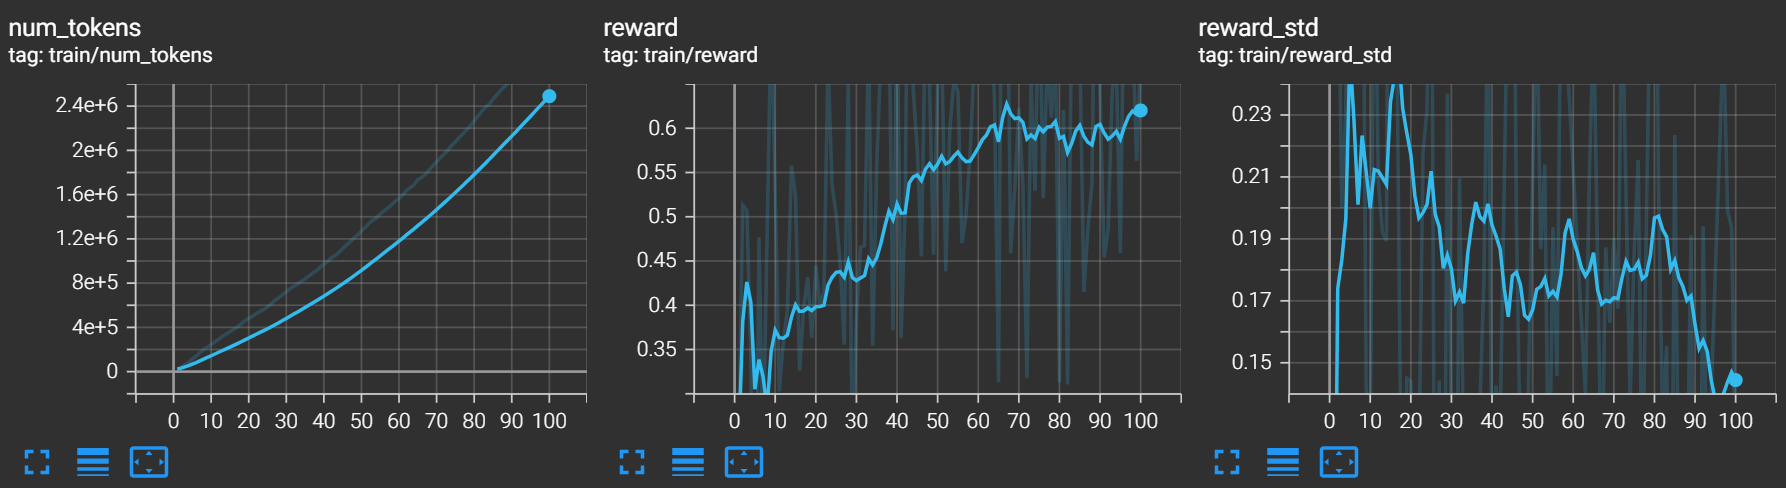

### 2.8 Inspecting the tuned model

After RL in verifiable domains, let's see what the average reward is for the test set.


In [20]:
from peft import PeftModel

policy_model = PeftModel.from_pretrained(policy_model, "checkpoints/qwen2_sorting_grpo")
policy_model = policy_model.merge_and_unload()  # optional: merges LoRA weights into base
policy_model.eval()

rlvr_response = test_model(policy_model, prompt=test_ds[0]['prompt'])
print(rlvr_response)

rlvr_reward = sorting_reward(test_ds[0]['prompt'], rlvr_response, test=True)
print('RLVR reward:', rlvr_reward)

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Sort the numbers [-14.433446591715981, 17.077524987991644, -7.7554073098261895, -13.023103573742805, -14.875241191424625, 17.03338723338379, 7.268326687417488, 9.524625622451982, -18.41086602591082, -15.315238006920378, -8.366955330463021, 10.100936452499017, 8.06225314693065, 15.800980646120173, 15.066248679511794, 0.9759910480829355, 2.460452314192679, -6.090464588466864, 23.4650160396467, 17.940368356488364, -12.017034181155495, 1.1307199076751289, -6.1064329164179085, -9.23431189462056, 18.174706450326198, -14.889486174007565, -1.003634968133131, -2.0510309757685796, -2.8022138760514466, -6.773956638899346, -17.82747785384514, 2.971243983592128, -13.758691857339532, 26.114768601407995, -16.05999009607709, -5.341085929645356, 11.431989974722168, 24.272587396840343, -1.9182486916511756, -10.385570487167005, -16.522242558812955, 13.063165928385509, 18.653417039434594, 29.

In [22]:
rlvr_eval_results = evaluate_model_on_dataset(policy_model, test_ds.select(range(10)))
print("RLVR model average reward:", rlvr_eval_results)

Evaluating model: 100%|██████████| 10/10 [05:12<00:00, 31.27s/it]

RLVR model average reward: 0.7761401626016261


Clearly, the test reward increases from 46.3% to 52.8% with SFT and then a further to 77.6% after RL tuning. 


## Takeaways

* LoRA adapters collapse the fine-tuning footprint of a dense linear layer while maintaining accuracy when the required update is approximately low rank.
* Supervised warm-starting with structured `<think>...</think>` exemplars teaches the LoRA adapter to emit both reasoning tokens and the final sorted answer before RL.
* GRPO-style updates combined with PEFT adapters on Qwen 2.5 7B provide a practical recipe for reinforcement learning on consumer hardware.
